In [2]:
from iris import irisRequests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ngl
import datetime
from numba import njit
from numba.typed import Dict
from sklearn.metrics.pairwise import haversine_distances

In [3]:
# this takes as input 'region'
# a 4-tuple containing (minlat, maxlat, minlon, maxlon)
# 'coords' with the aftershocks coordinates, it is a (N, 2) matrix
# dlat, dlon the discretization of cells
# steps is the number of cell to put an aftershock in
@njit
def construct_aftershocks_map_steps(region, coords, dlat, dlon, steps):
    N_lat = int((region[1]-region[0])/dlat)
    N_lon = int((region[3]-region[2])/dlon)
    shocks_map = np.zeros((N_lat, N_lon))
    for coord in coords:
        i,j = int((coord[0]-region[0])/dlat), int((coord[1]-region[2])/dlon)
        if(steps > 0):
            for di in range(-steps,steps+1):
                for dj in range(-steps, steps+1):
                    if(i+di >= 0 and i+di < N_lat and j+dj >= 0 and j+dj < N_lon):
                        shocks_map[i+di,j+dj] += 1
        else:
            shocks_map[i,j] += 1
    return shocks_map

In [4]:
# same as before, but only puts aftershocks in a single cell
@njit
def construct_aftershocks_map(region, coords, dlat, dlon):
    N_lat = int((region[1]-region[0])/dlat)
    N_lon = int((region[3]-region[2])/dlon)
    shocks_map = np.zeros((N_lat, N_lon))
    for coord in coords:
        i,j = int((coord[0]-region[0])/dlat), int((coord[1]-region[2])/dlon)
        shocks_map[i,j] += 1
        #if(i>0):
        #    shocks_map[i-1,j] += 1
        #if(j>0):
        #    shocks_map[i,j-1] += 1
        #if(i < N_lat-1):
        #    shocks_map[i+1,j] += 1
        #if(j < N_lon-1):
        #    shocks_map[i,j+1] += 1
    return shocks_map

In [5]:
rootpath = "csv_24/"

In [6]:
# specify regions limits
regions = {}
regions['greece'] = (30, 45,18, 44)
regions['california'] = (30, 41, -125, -113)
regions['japan'] = (20, 50, 120, 150)
regions['italy'] = (35,46,6, 19)
regions_m = {}
regions_m['japan'] = (6.5, 4.0)
regions_m['italy'] = (5.0, 3.0)
regions_m['greece'] = (6.0, 4.0)
regions_m['california'] = (5.0, 3.0)

In [7]:
# grab GPS stations list
station_list = ngl.ngl_process_list(ngl.ngl_24h_2w) # daily measurements, with 2 weeks delay

In [8]:
# fill a dictionary with all the stations coordinates inside the region box
station_info = {}
for name, region in regions.items():
    station_names, station_lats, station_lons  = ngl.get_all_stations_box(station_list, *region)
    station_info[name]= (station_names, station_lats, station_lons)

In [9]:
# save, per region, the station data
# either download or load, depending whether they are on disk or not
station_data = {}
for name, s_info in station_info.items():
    for s_cnt, s_name in enumerate(s_info[0]):
        df, status = ngl.ngl_retrieve_24h(rootpath, s_name)
        print(s_name, status)
        station_data[s_name] = df

ABEL downloaded
ADAN downloaded
ADCS downloaded
ADIY downloaded
ADN1 downloaded
ADN2 downloaded
ADY1 downloaded
AFY0 downloaded
AFYN downloaded
AFYT downloaded
AGID downloaded
AGIG downloaded
AGIO downloaded
AGNA downloaded
AGRI downloaded
AIGI downloaded
AKD1 downloaded
AKDG downloaded
AKHI downloaded
AKHR downloaded
AKHU downloaded
AKLE downloaded
AKS1 downloaded
AKSR downloaded
AKYR downloaded
ALE3 downloaded
ALNY downloaded
ALON downloaded
ALX2 downloaded
ALXR downloaded
AMA3 downloaded
AMAS downloaded
AMFI downloaded
AMMN downloaded
ANAV downloaded
ANDR downloaded
ANIK downloaded
ANK2 downloaded
ANKR downloaded
ANKY downloaded
ANMU downloaded
ANOC downloaded
ANOP downloaded
ANRK downloaded
ANTA downloaded
ANTL downloaded
ANTP downloaded
APK1 downloaded
ARDA downloaded
AREL downloaded
ARG2 downloaded
ARK1 downloaded
ARKI downloaded
ARPK downloaded
ARSA downloaded
ARST downloaded
ART1 downloaded
ART2 downloaded
ARTV downloaded
ASGA downloaded
ASSO downloaded
AST5 downloaded
ASTY dow

In [10]:
start_time = datetime.datetime(2003, 1, 1, 0, 0, 0)
end_time =  datetime.datetime(2024, 1, 1, 0, 0, 0)
catalogs = {}
for name, region in regions.items():
    download_url =irisRequests.url_events_box(start_time, end_time, region[0], region[1], region[2], region[3], minmag=3, magtype="MW")
    df = pd.read_csv(download_url, sep="|", comment="#")
    df.Time = pd.to_datetime(df.Time, errors='coerce')
    df.dropna(axis=0, inplace=True)
    df.sort_values(by="Time", inplace=True)
    df.reset_index(inplace=True, drop=True)
    catalogs[name] = df

/var/folders/r7/3208sx_91txg405qfpwxcm3m0000gr/T/ipykernel_16667/4128855107.py:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(download_url, sep="|", comment="#")
/var/folders/r7/3208sx_91txg405qfpwxcm3m0000gr/T/ipykernel_16667/4128855107.py:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(download_url, sep="|", comment="#")


In [11]:
@njit(nogil=True)
def construct_map(u, idx, d, d_cutoff = 0.01):
    # u = (N_s, 3)
    # idx = (N_s)
    # d = (N_lat, N_lon, N_s_tot)
    u_map = np.zeros((d.shape[0], d.shape[1], 3))
    for i in range(0, d.shape[0]):
        for j in range(0, d.shape[1]):
            cnt = 0
            for i_n,n in enumerate(idx):
                d_ijn = d[i,j,n]
                if(d_ijn <= d_cutoff):
                    u_map[i,j,:] = u_map[i,j,:] + u[i_n, :]
                    cnt += 1
            if(cnt > 0):
                u_map[i,j,:] = u_map[i,j,:]/float(cnt)
            else:
                u_map[i,j,0] = np.nan
                u_map[i,j,1] = np.nan
                u_map[i,j,2] = np.nan
    return u_map


greece
2003-01-27 05:26:23+00:00


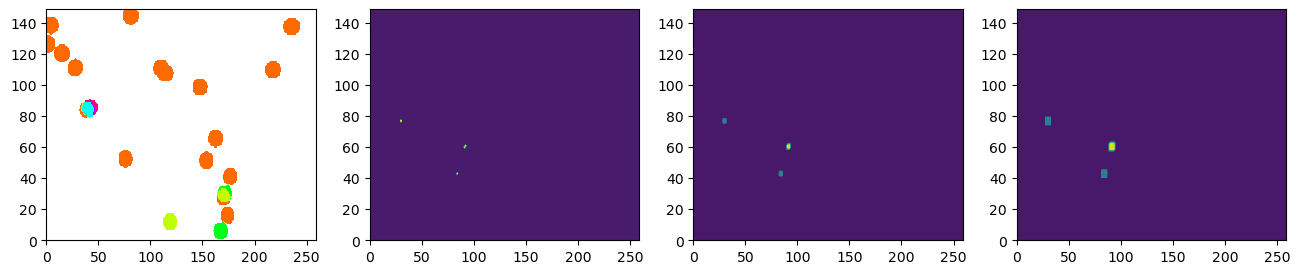

21
2003-05-01 00:27:04+00:00


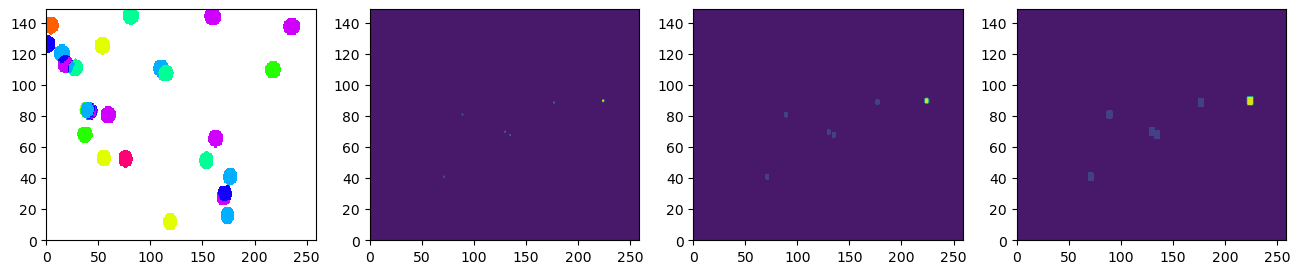

26
2003-08-14 05:14:54+00:00


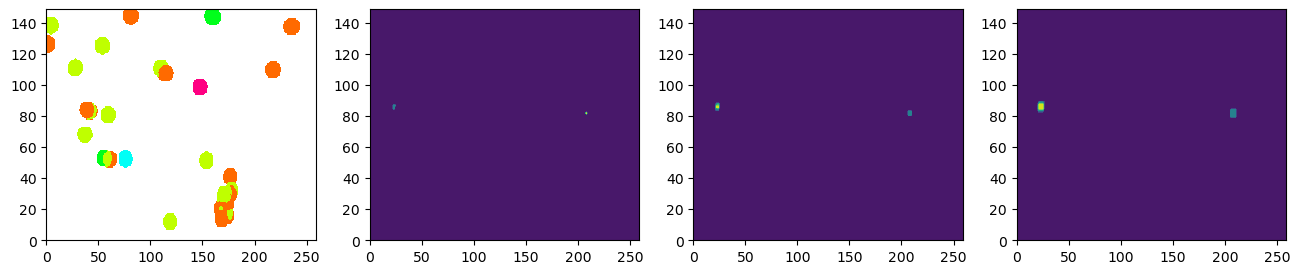

31
2004-03-17 05:20:57+00:00


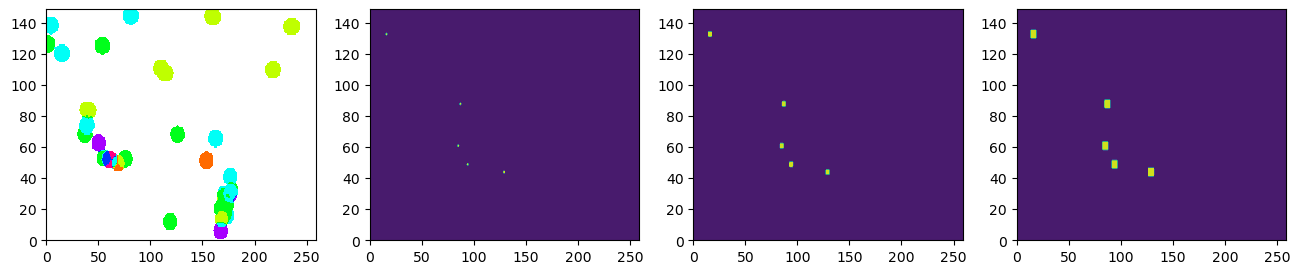

34
2006-01-08 11:34:54+00:00


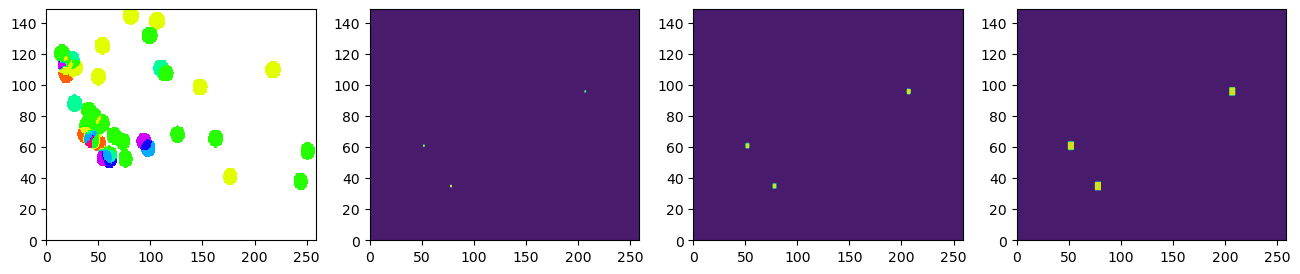

36
2008-01-06 05:14:21+00:00


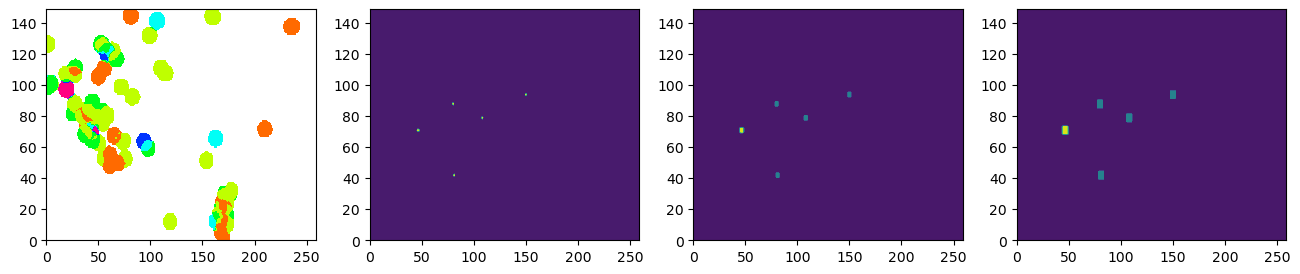

77
2008-02-14 10:09:23+00:00


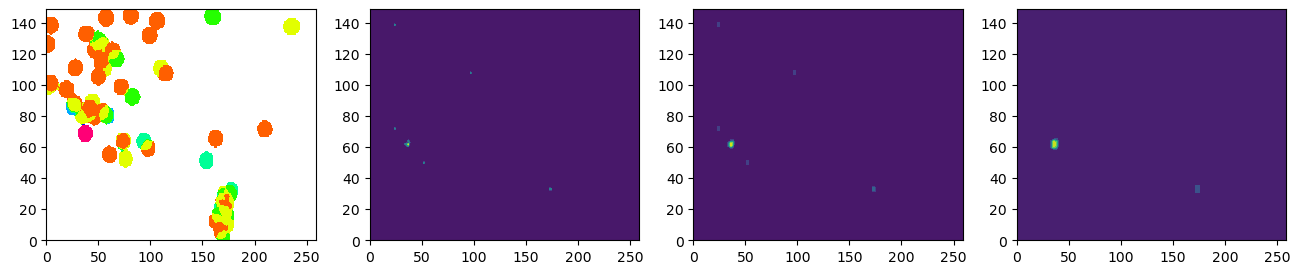

68
2008-02-14 12:08:57+00:00


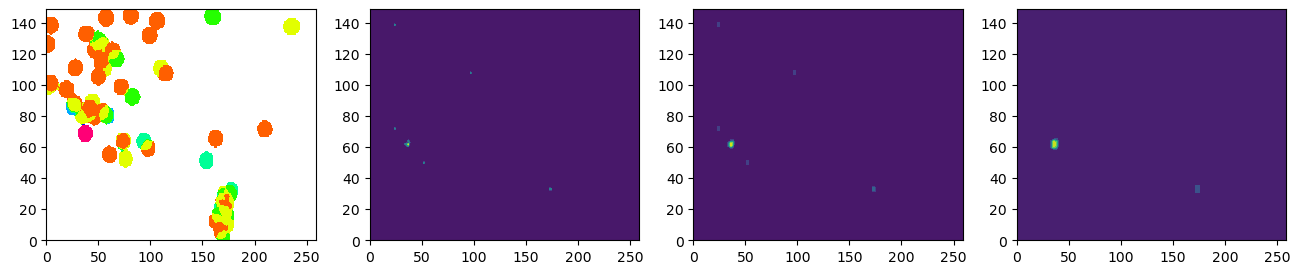

68
2008-02-20 18:27:07+00:00


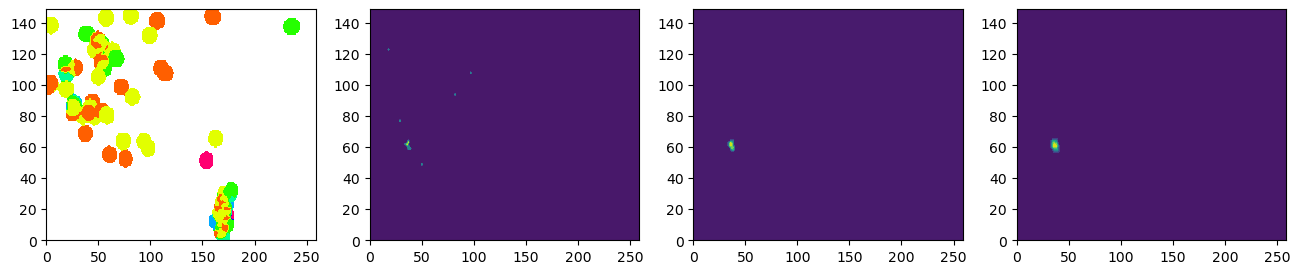

68
2008-06-08 12:25:29+00:00


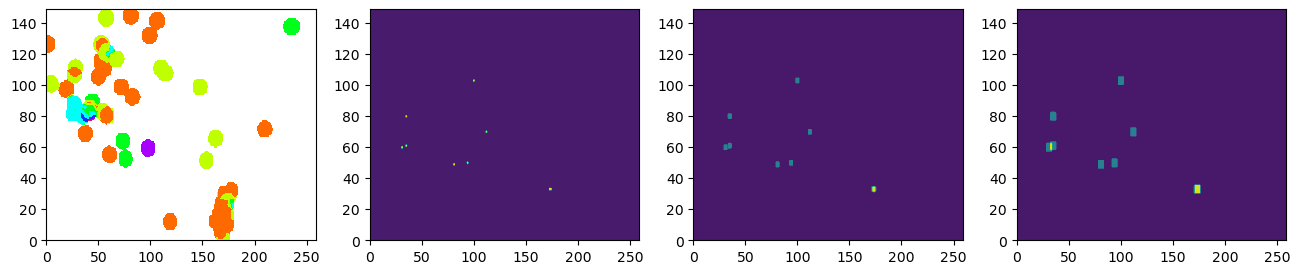

60
2008-07-15 03:26:36+00:00


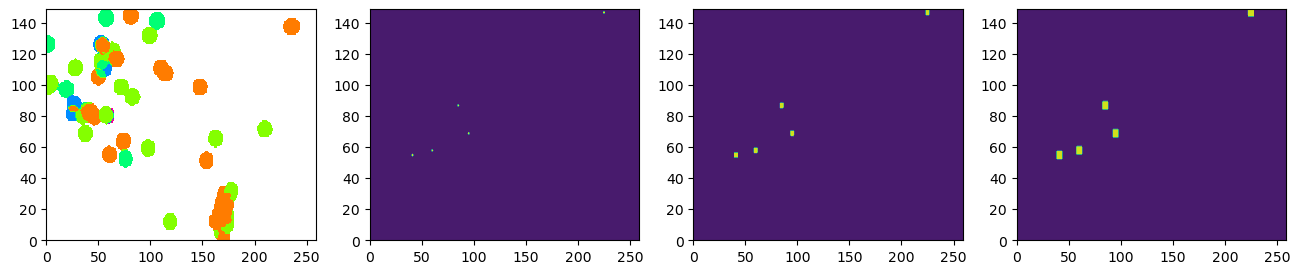

63
2009-07-01 09:30:10+00:00


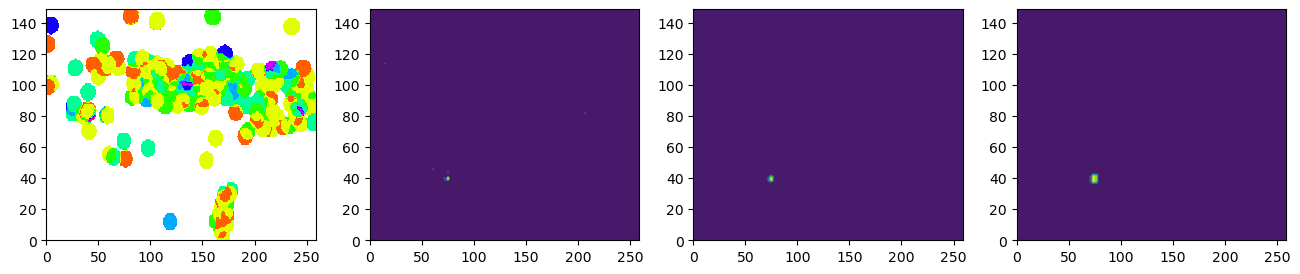

158
2009-09-07 22:41:37+00:00


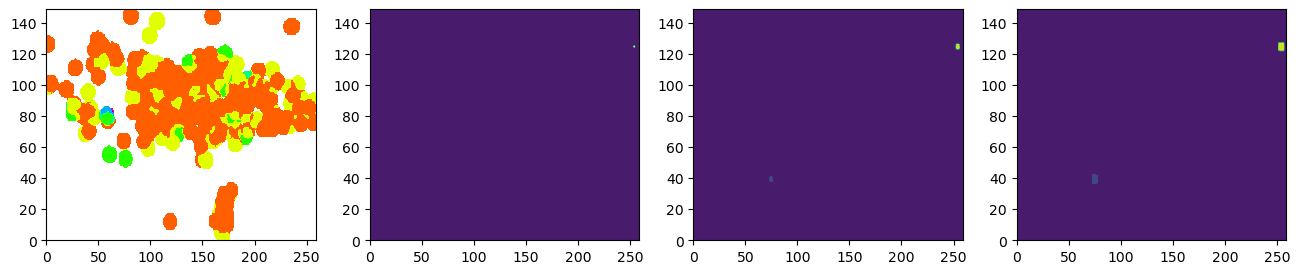

197
2010-03-08 02:32:35+00:00


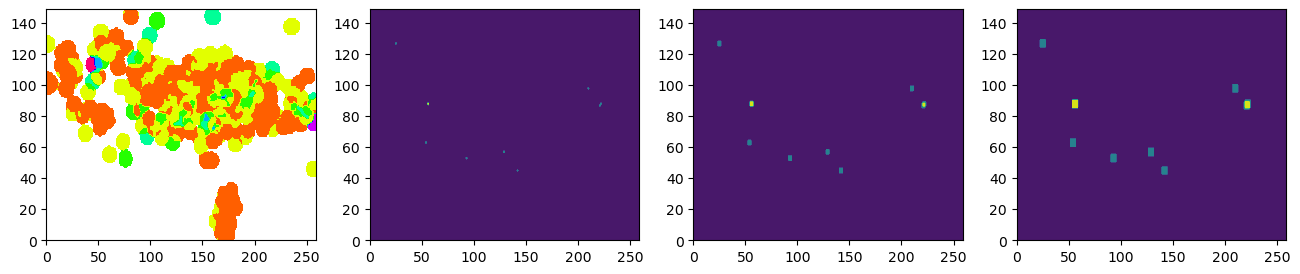

222
2011-04-01 13:29:11+00:00


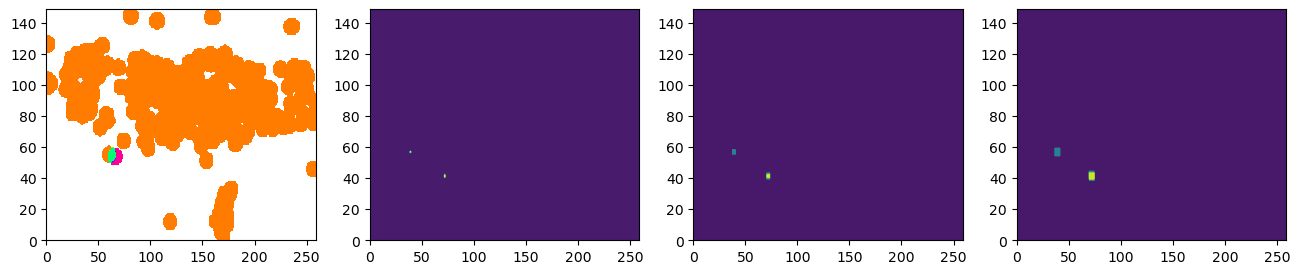

213
2011-10-23 10:41:22+00:00


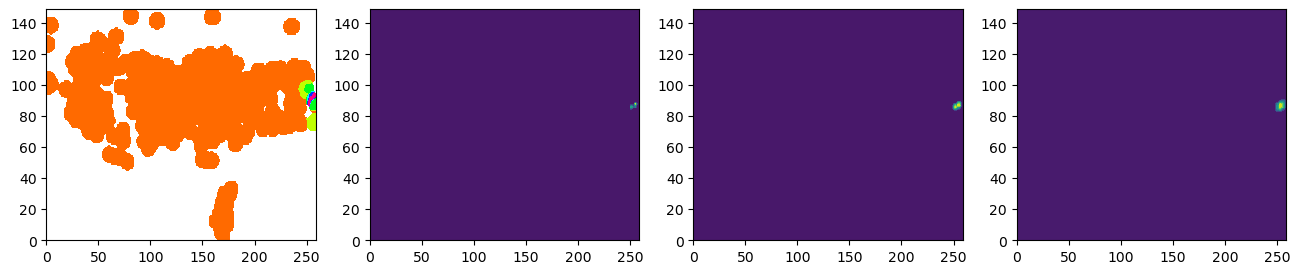

248
2011-10-23 20:45:37+00:00


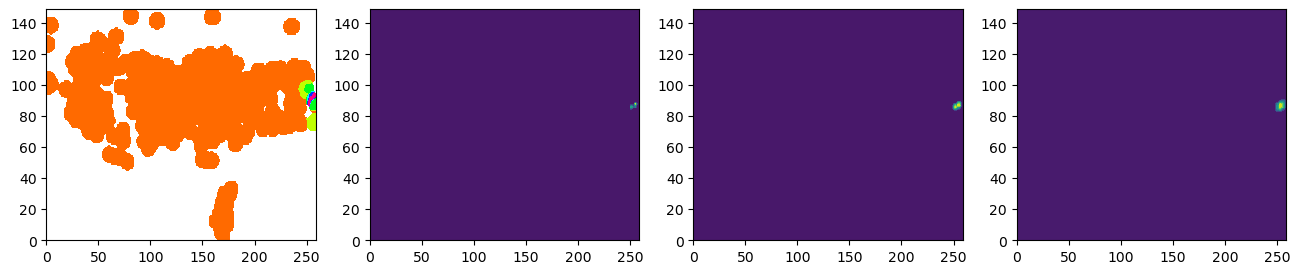

248
2012-06-10 12:44:16+00:00


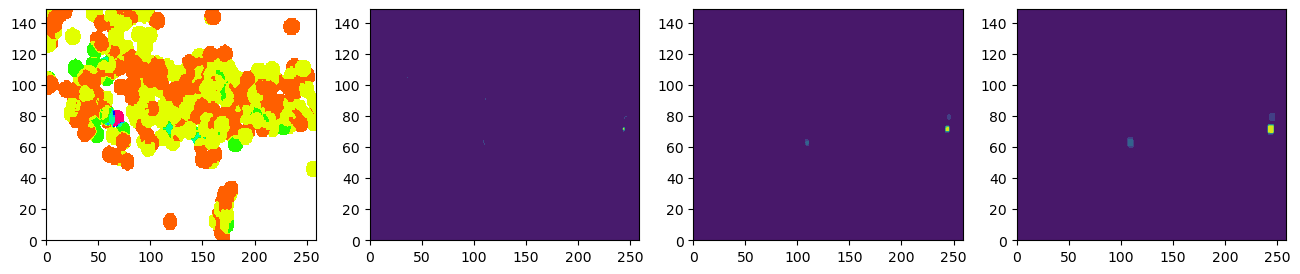

278
2013-06-15 16:11:02+00:00


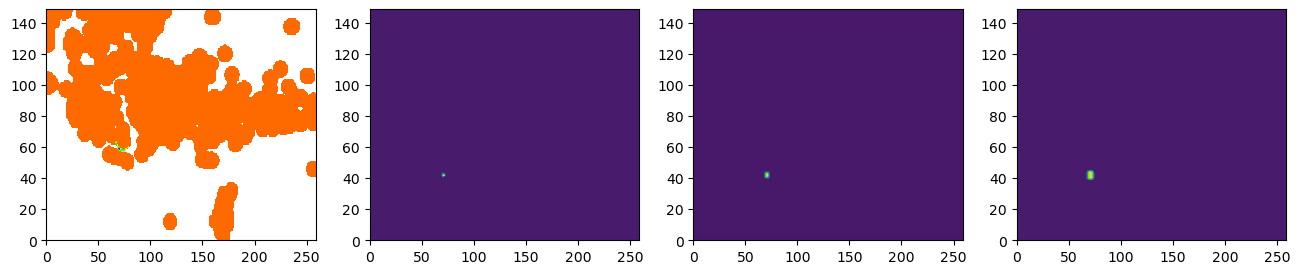

277
2013-06-16 21:39:06+00:00


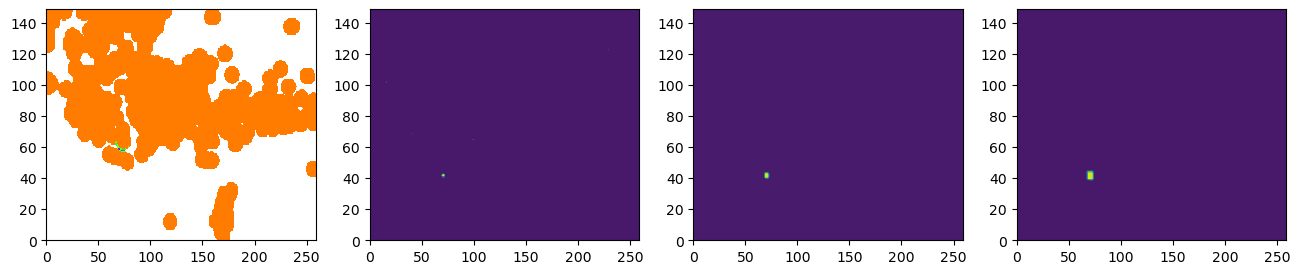

276
2013-10-12 13:11:53+00:00


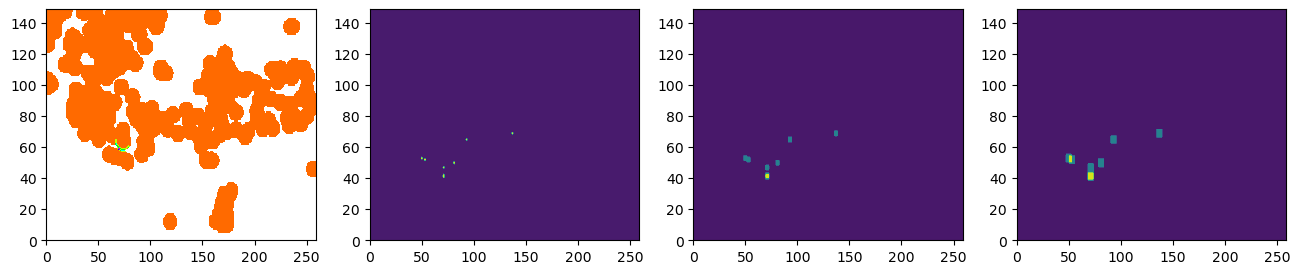

242
2014-01-26 13:55:43+00:00


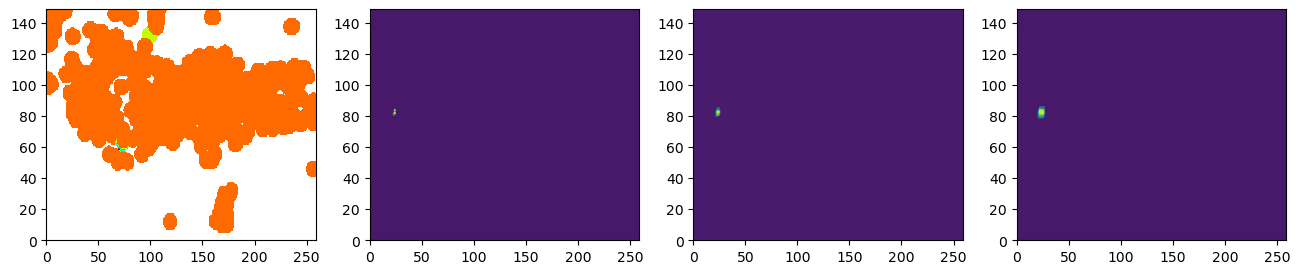

292
2014-02-03 03:08:46+00:00


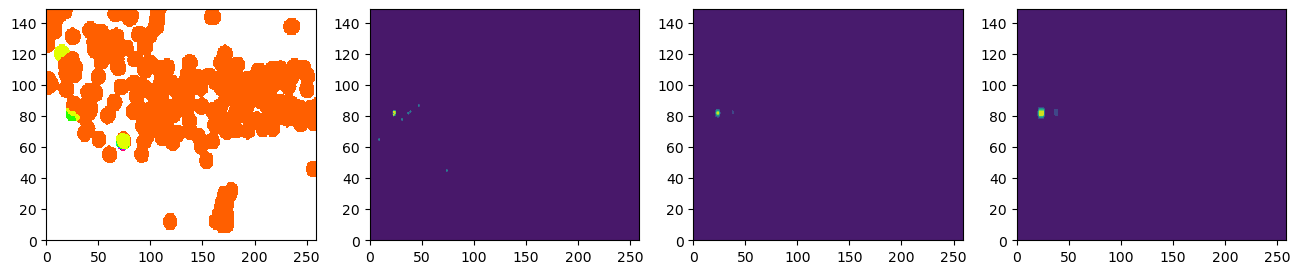

215
2014-05-24 09:25:03+00:00


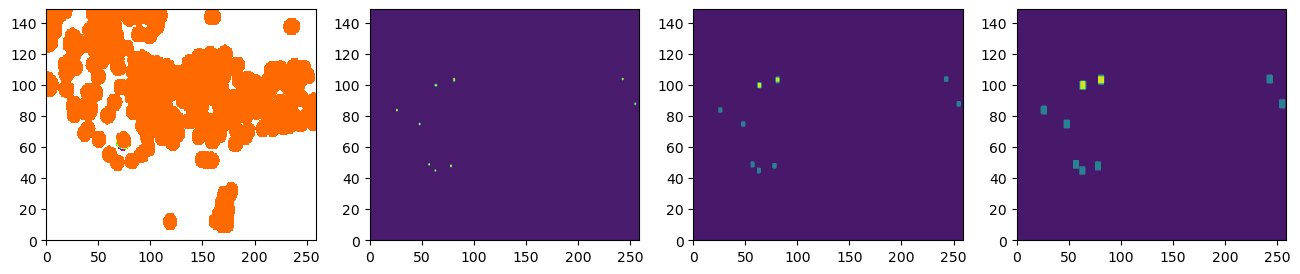

260
2015-04-16 18:07:43+00:00


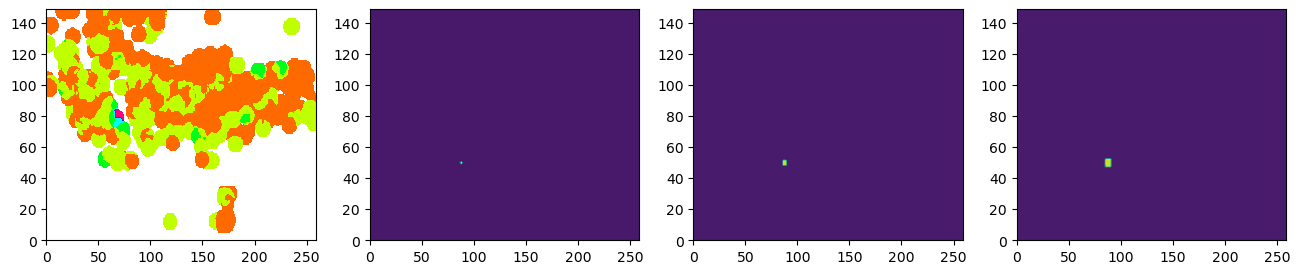

308
2015-11-17 07:10:07+00:00


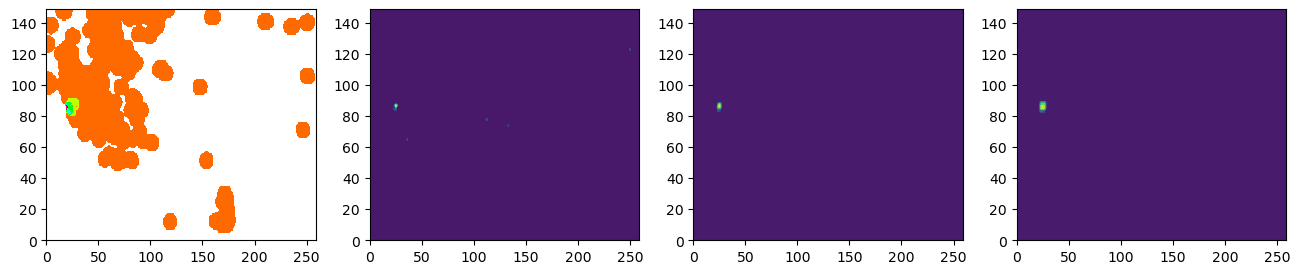

187
2017-06-12 12:28:39+00:00


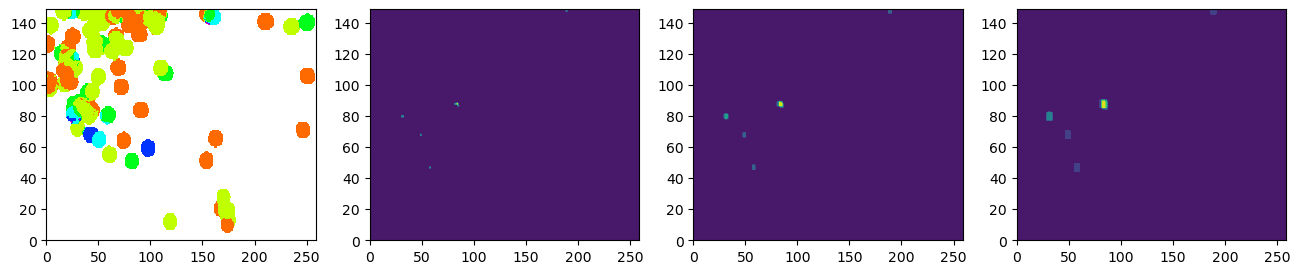

129
2017-07-20 22:31:11+00:00


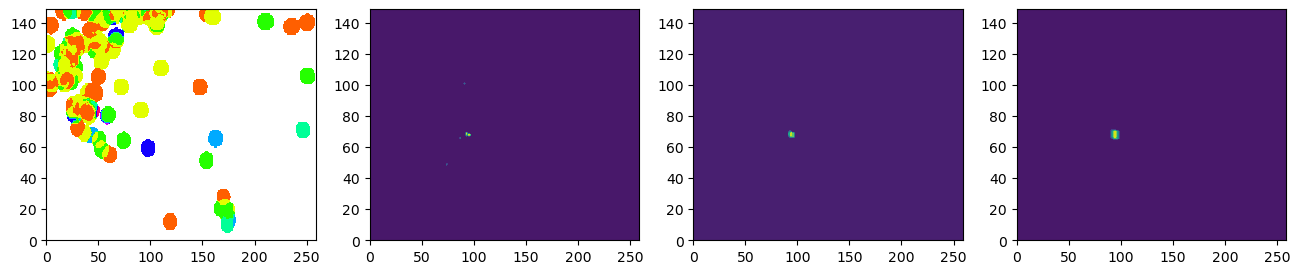

142
2018-10-25 22:54:52+00:00


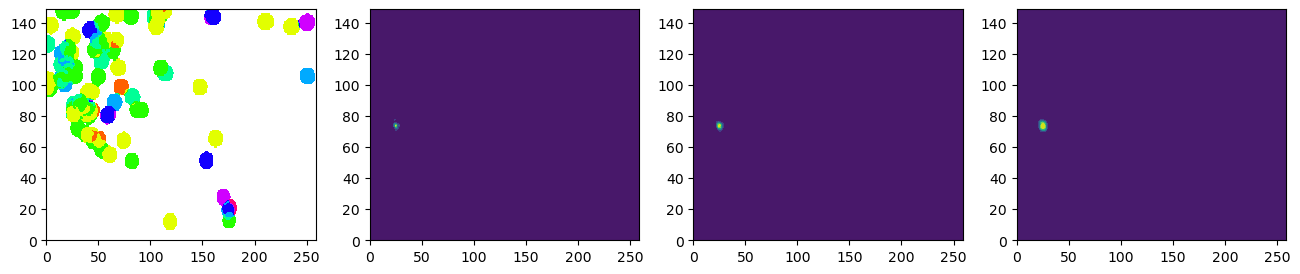

123
2019-11-26 02:54:12+00:00


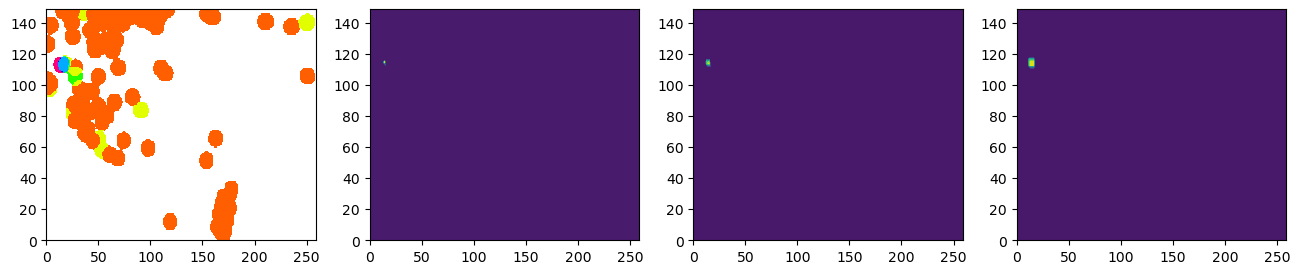

124
2019-11-27 07:23:42+00:00


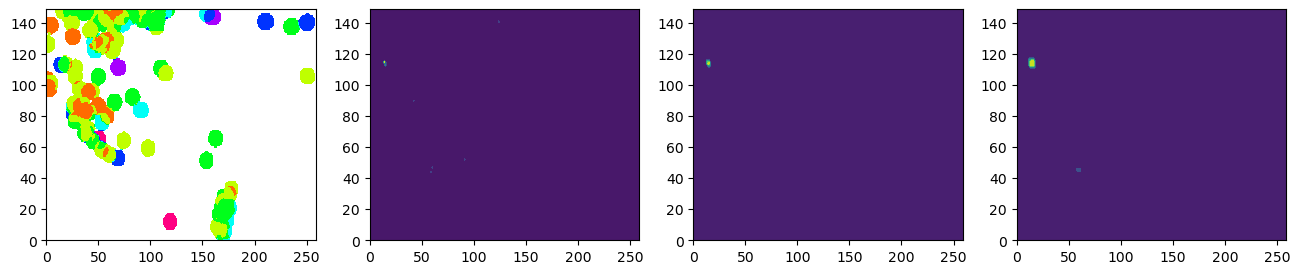

124
2020-01-24 17:55:13+00:00


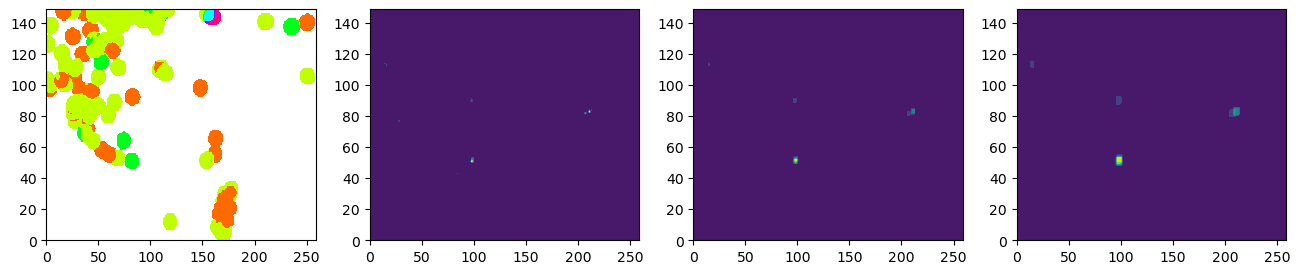

136
2020-05-02 12:51:06+00:00


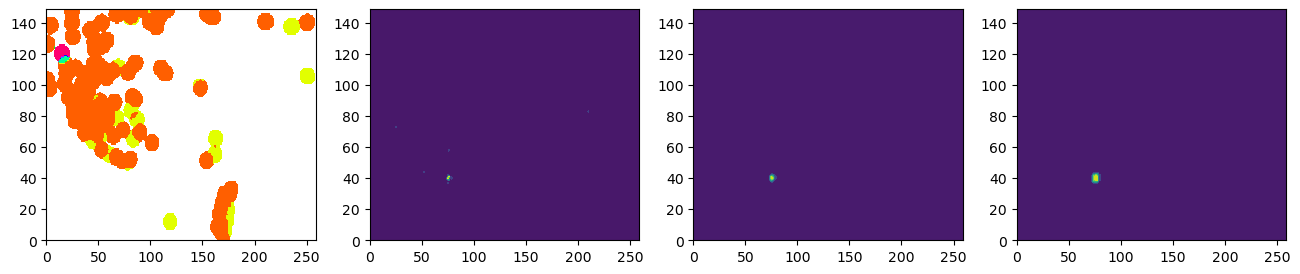

169
2020-10-30 11:51:27+00:00


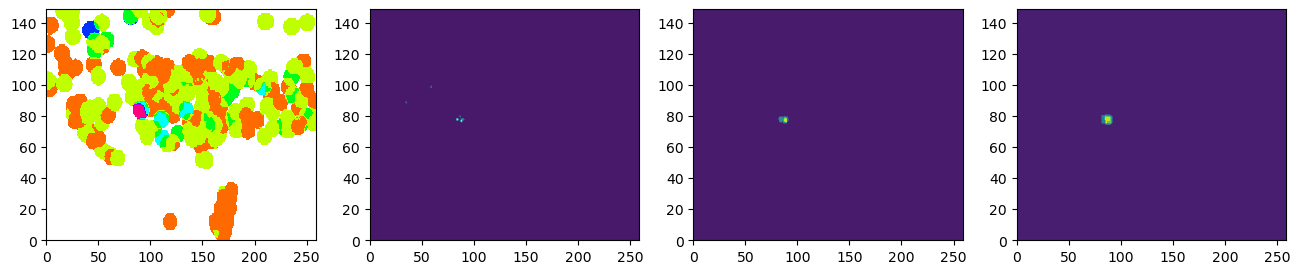

229
2021-03-03 10:16:09+00:00


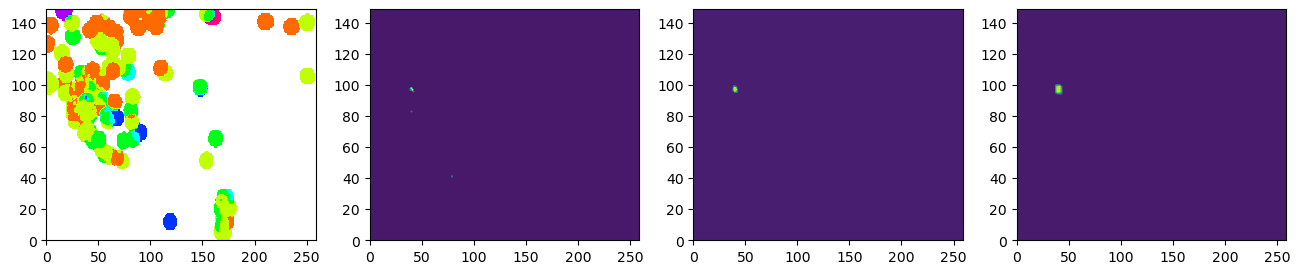

146
2021-09-27 06:17:22+00:00


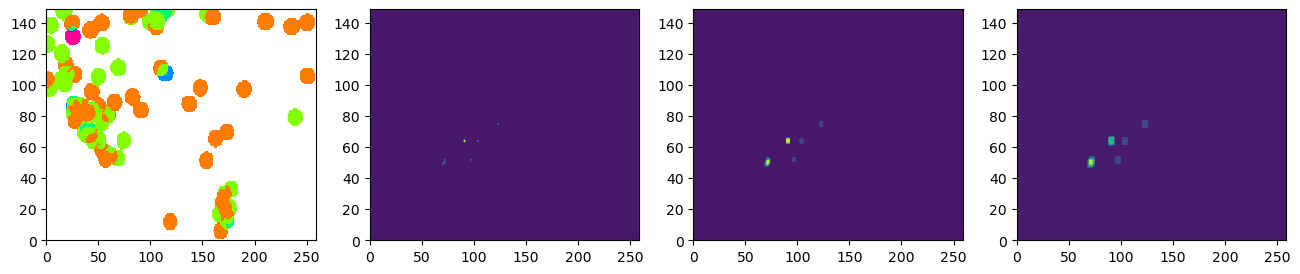

97
2021-10-12 09:24:03+00:00


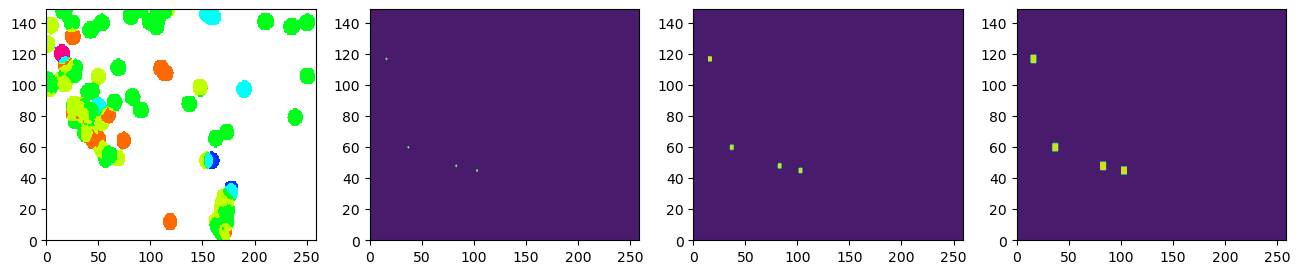

112
2022-01-11 01:07:48+00:00


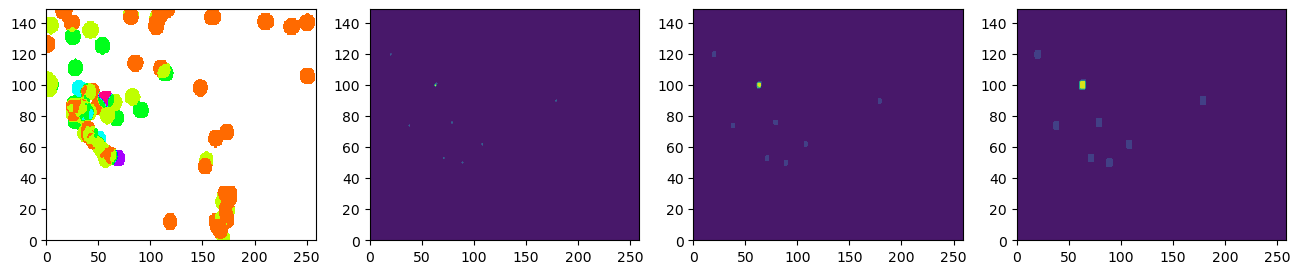

90
2022-11-23 01:08:15+00:00


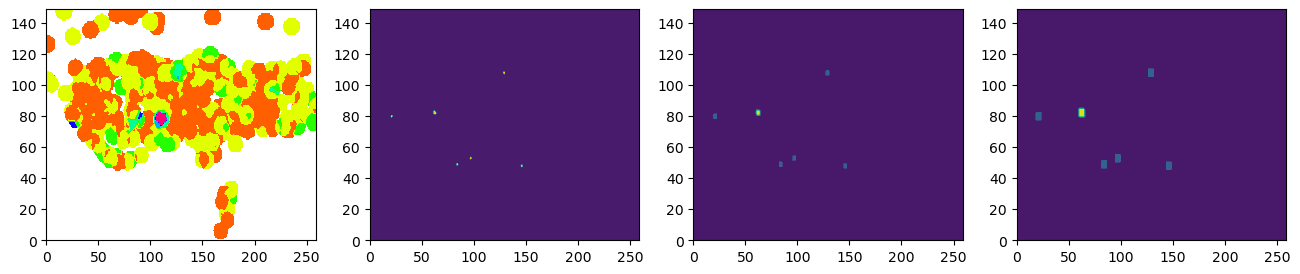

257
2023-02-06 01:17:34+00:00


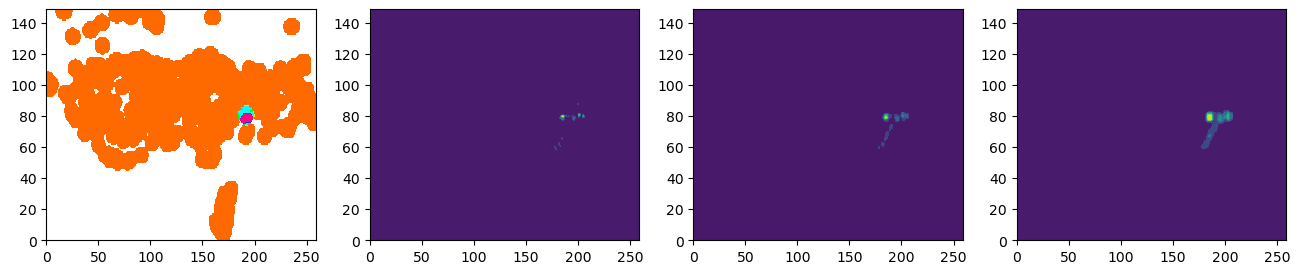

257
2023-02-06 01:28:15+00:00


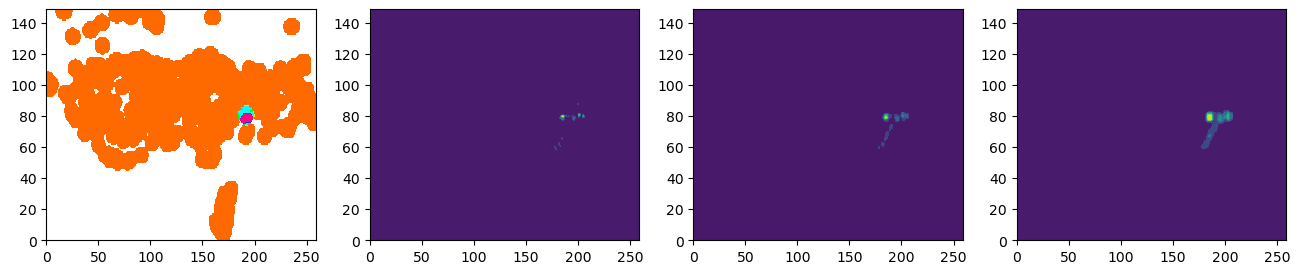

257
2023-02-06 10:24:49+00:00


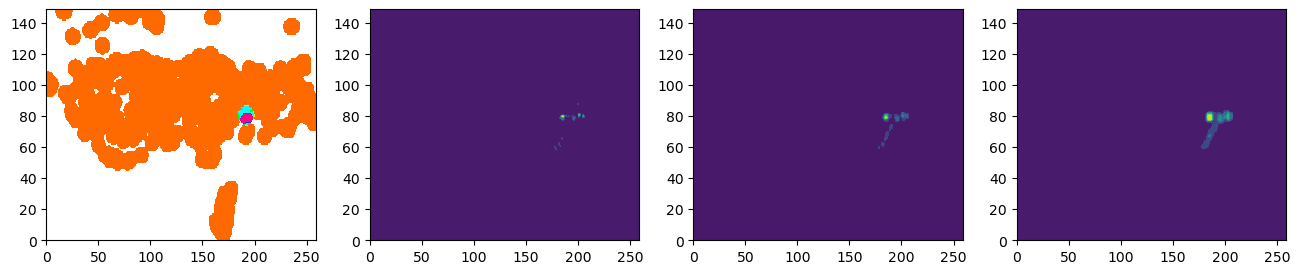

257
2023-02-06 10:26:48+00:00


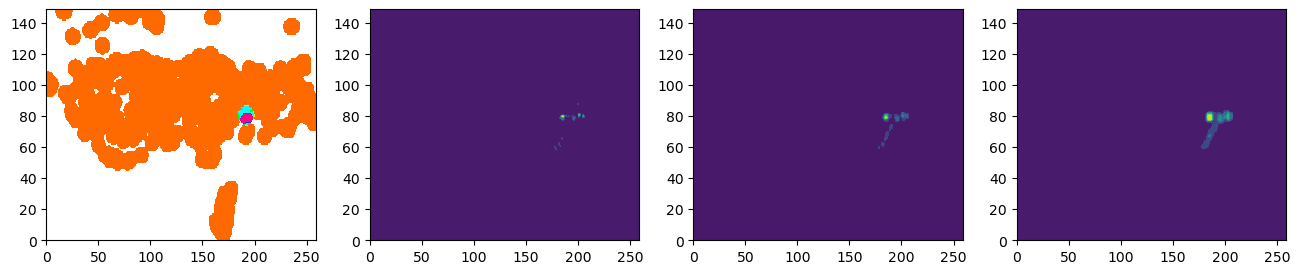

257
2023-02-06 12:02:11+00:00


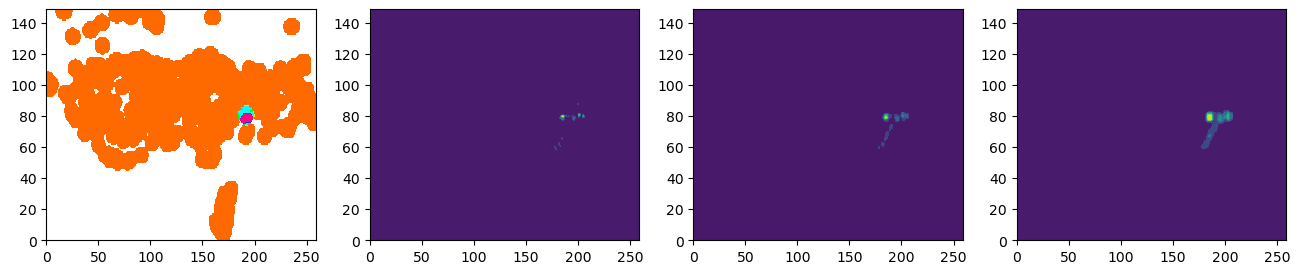

257
2023-02-20 17:04:29+00:00


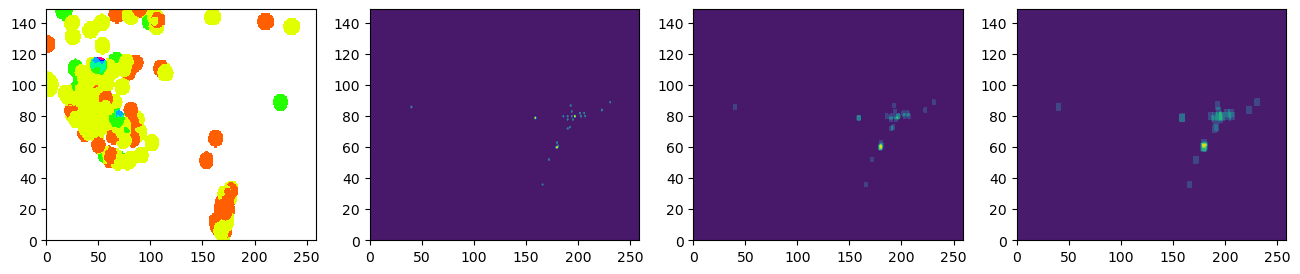

131
california
2003-02-22 12:19:08+00:00


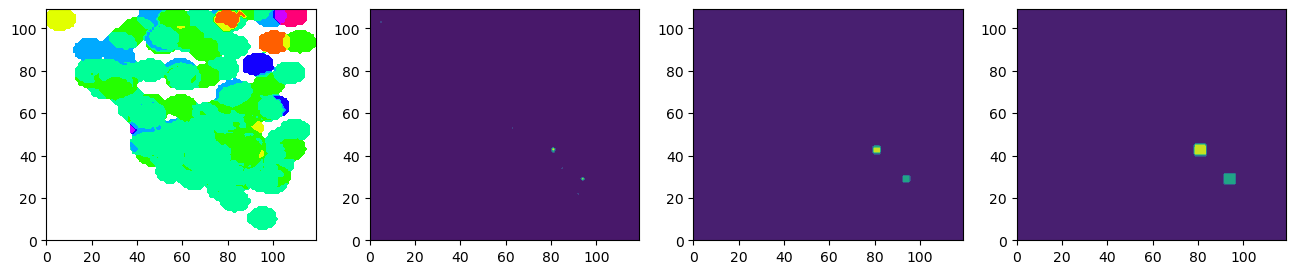

337
2003-12-22 19:15:56+00:00


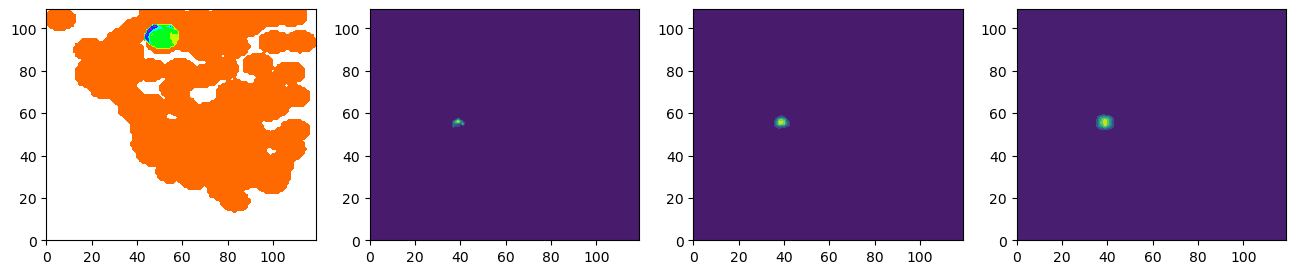

346
2003-12-23 05:30:18+00:00


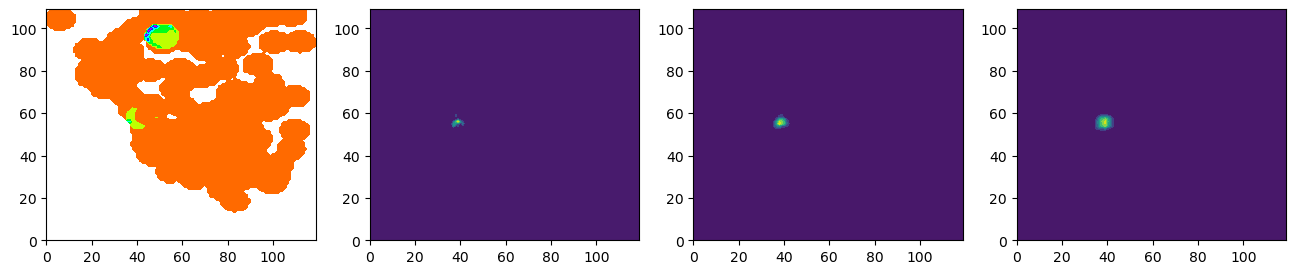

342
2003-12-23 18:17:10+00:00


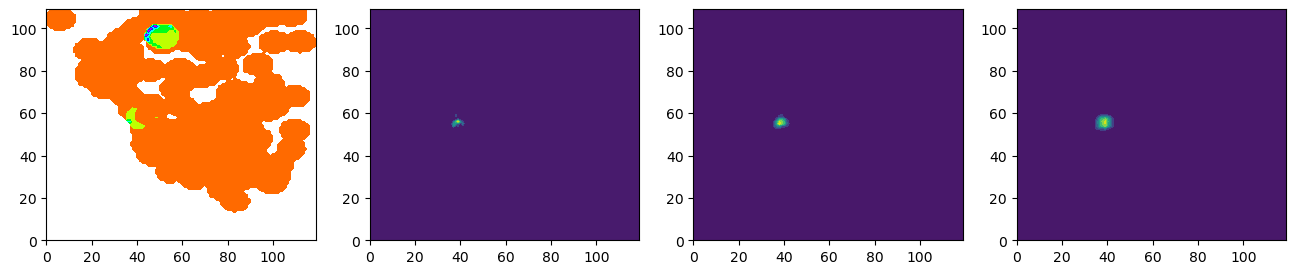

342
2004-06-15 22:28:48+00:00


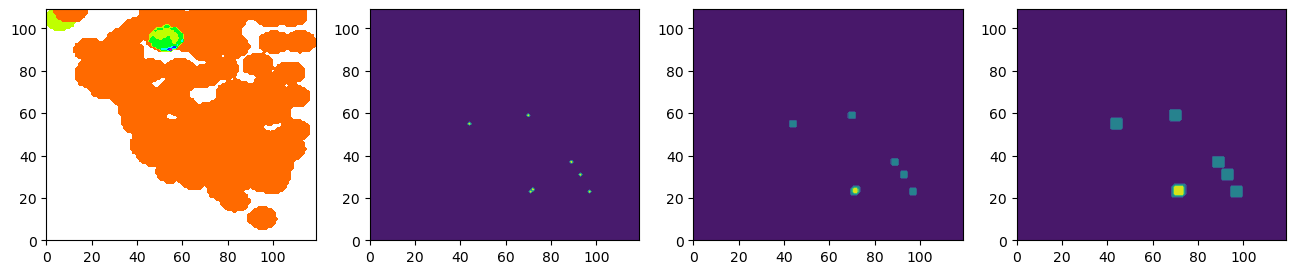

391
2004-09-18 23:02:18+00:00


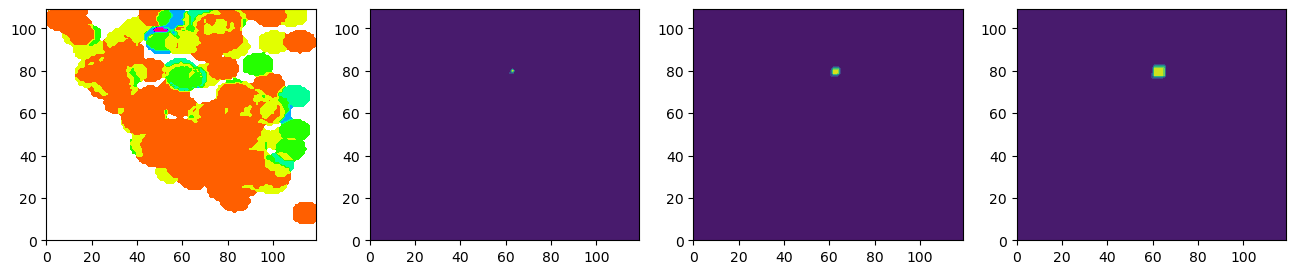

404
2004-09-18 23:43:41+00:00


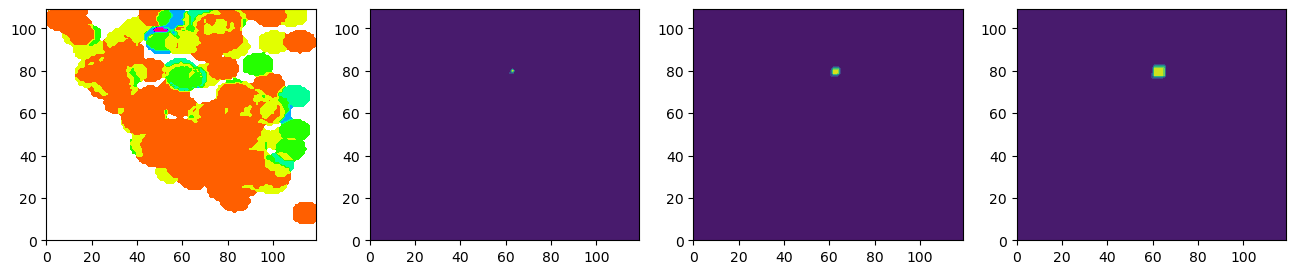

404
2004-09-18 23:47:58+00:00


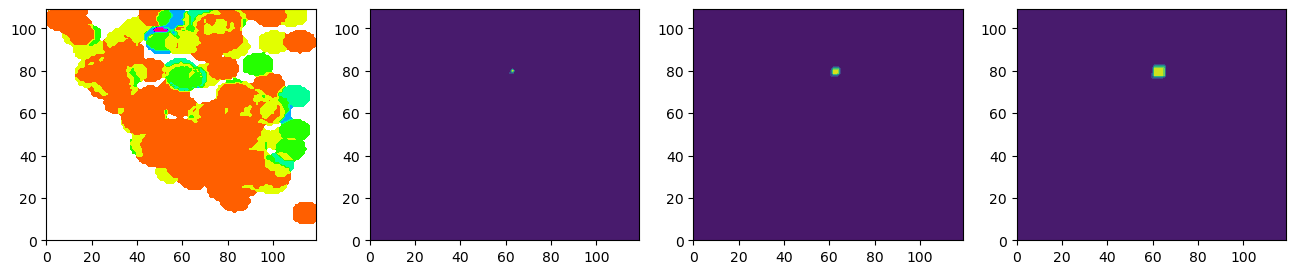

404
2004-09-28 17:15:24+00:00


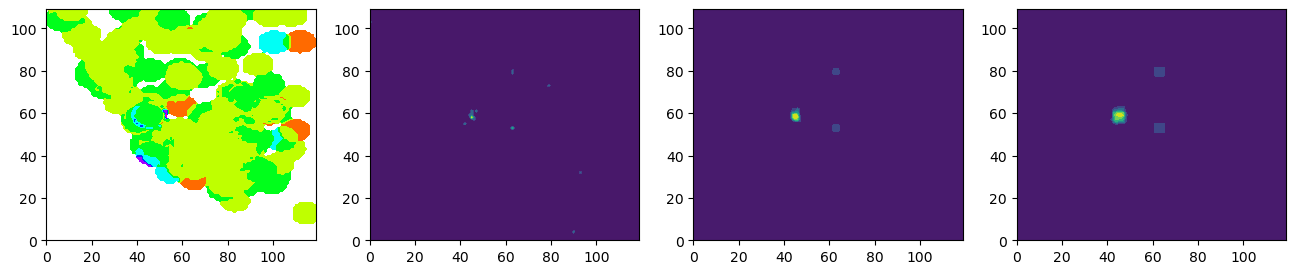

401
2004-09-29 17:10:04+00:00


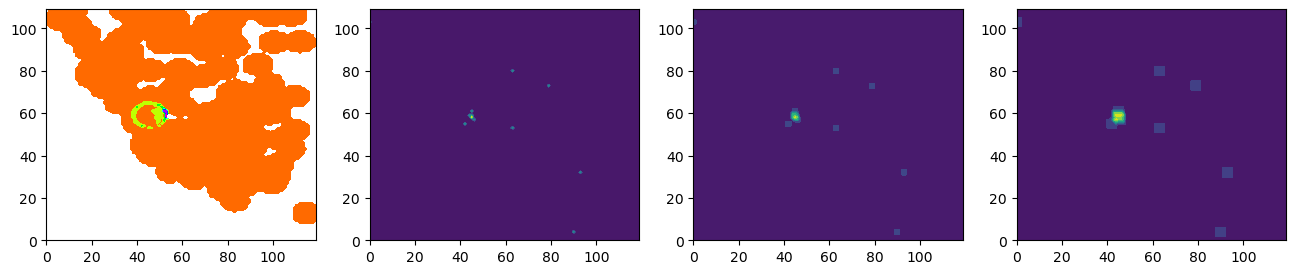

402
2004-09-29 22:54:52+00:00


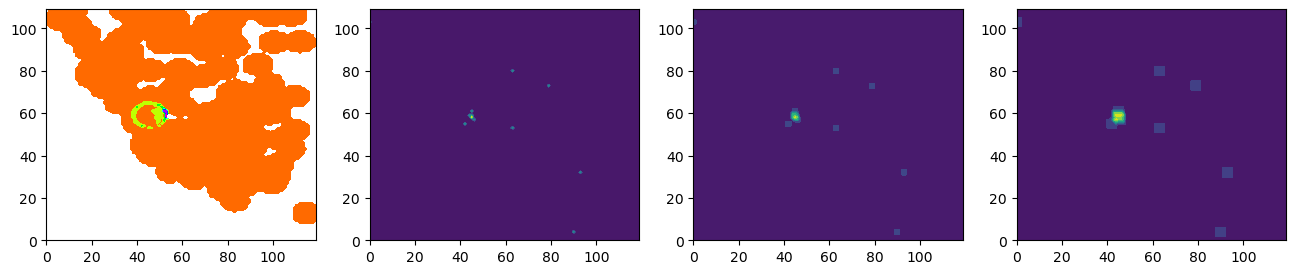

402
2004-09-30 18:54:29+00:00


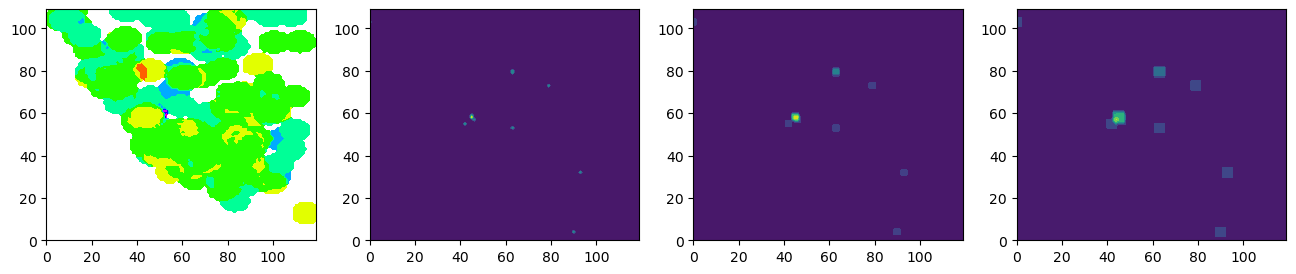

399
2004-10-20 11:35:14+00:00


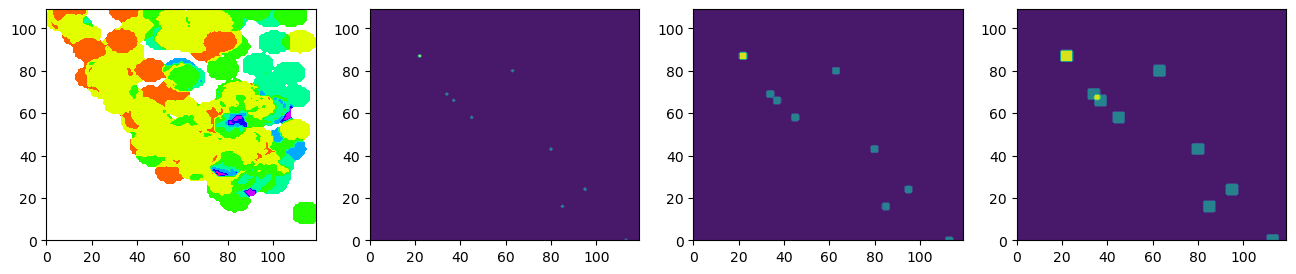

410
2005-04-16 19:18:12+00:00


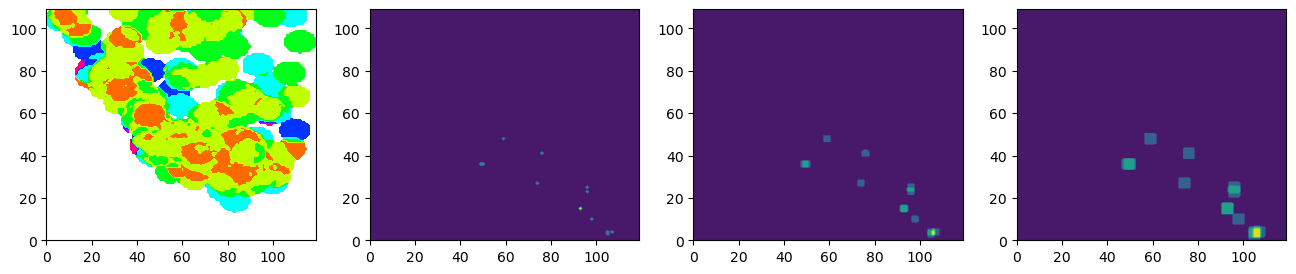

443
2005-04-27 00:32:57+00:00


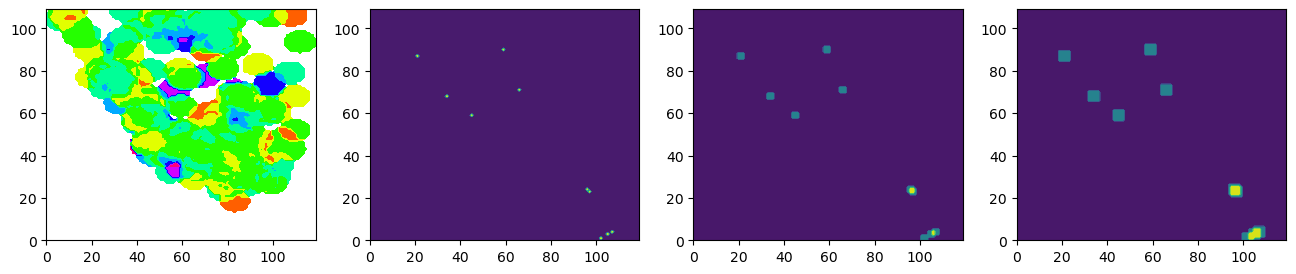

440
2005-05-21 00:39:31+00:00


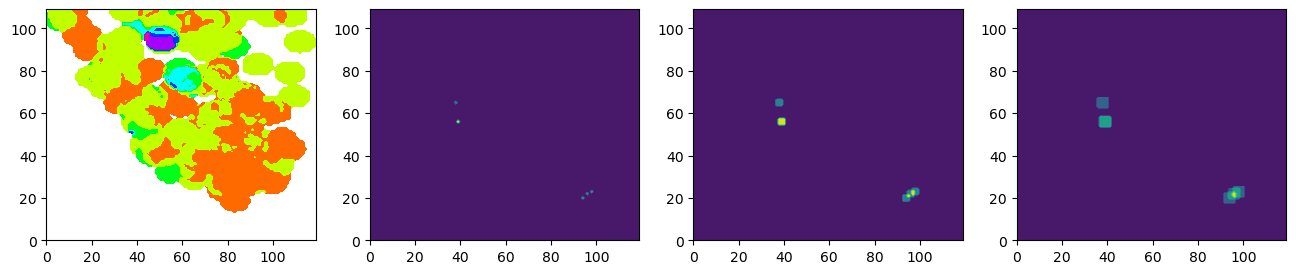

436
2005-06-12 15:41:45+00:00


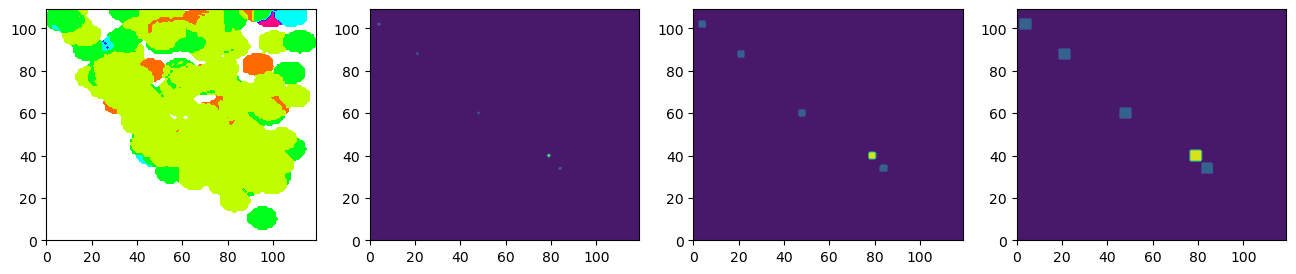

451
2005-08-31 23:07:15+00:00


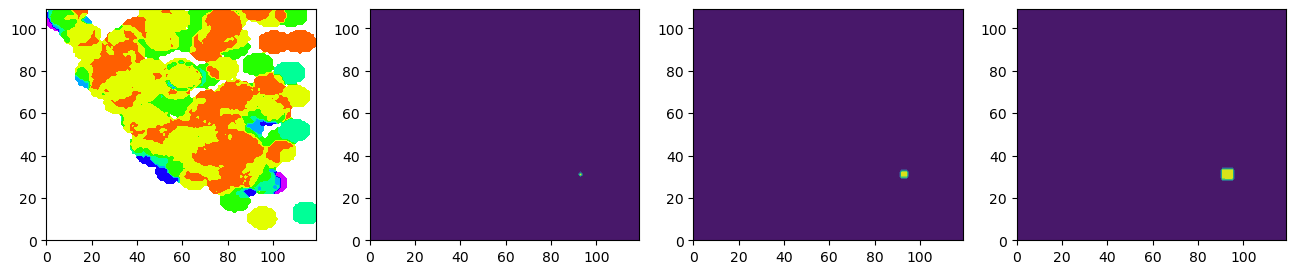

430
2005-08-31 23:32:10+00:00


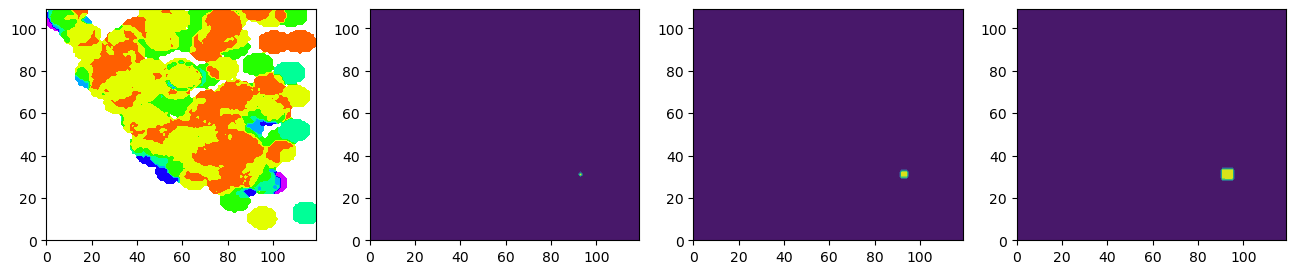

430
2005-09-02 01:27:18+00:00


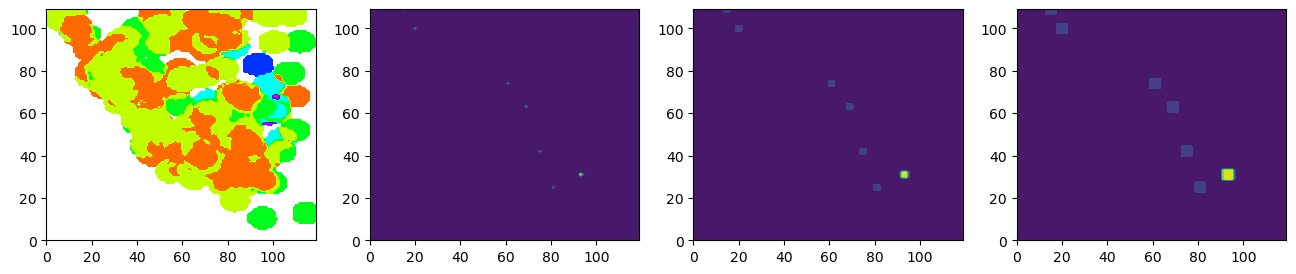

437
2006-02-16 17:48:00+00:00


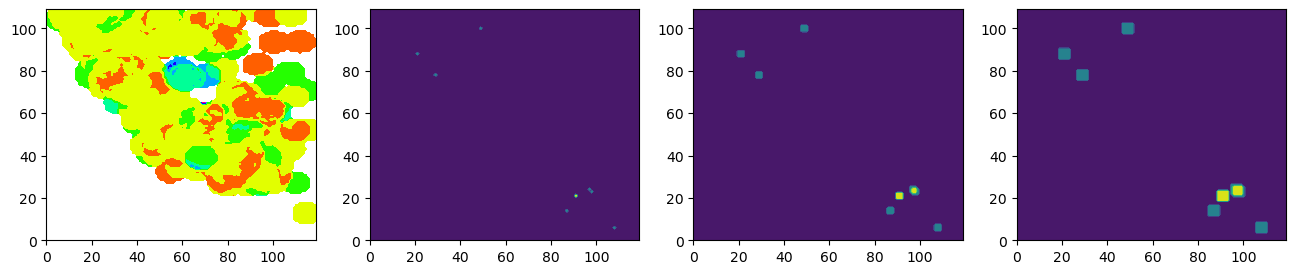

545
2006-05-01 21:04:42+00:00


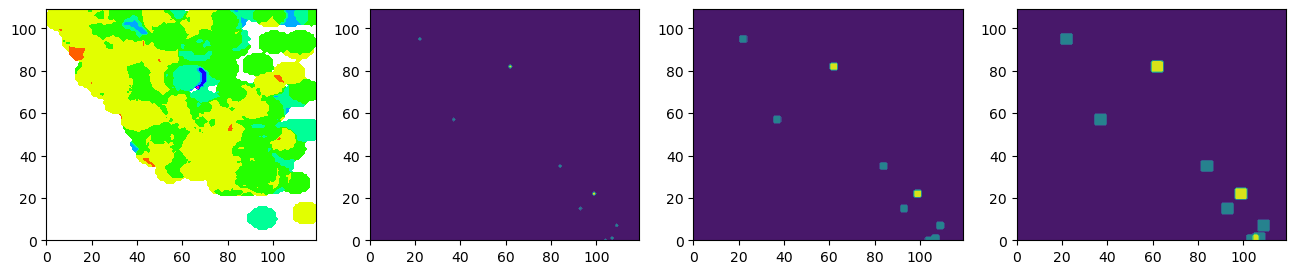

584
2006-05-05 06:36:19+00:00


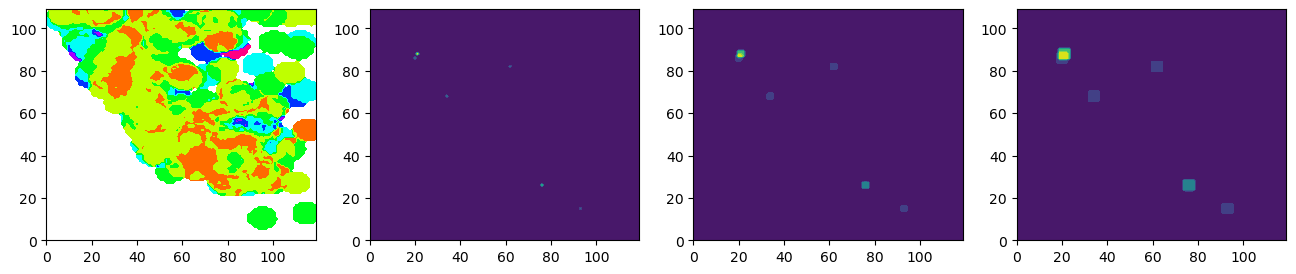

573
2006-05-24 04:20:27+00:00


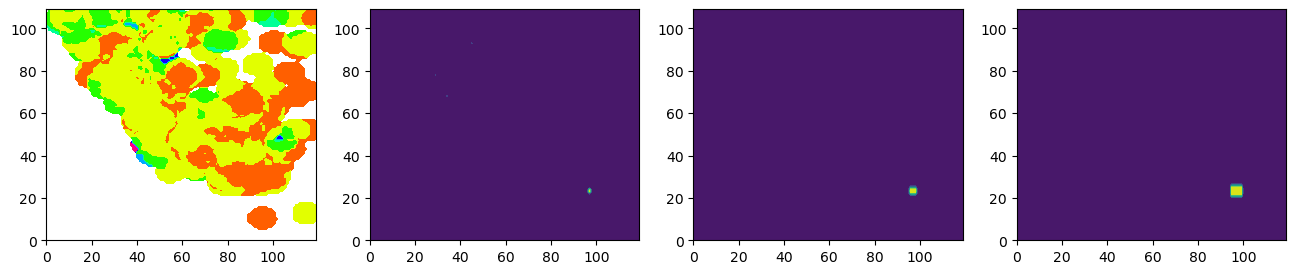

591
2006-09-14 00:11:05+00:00


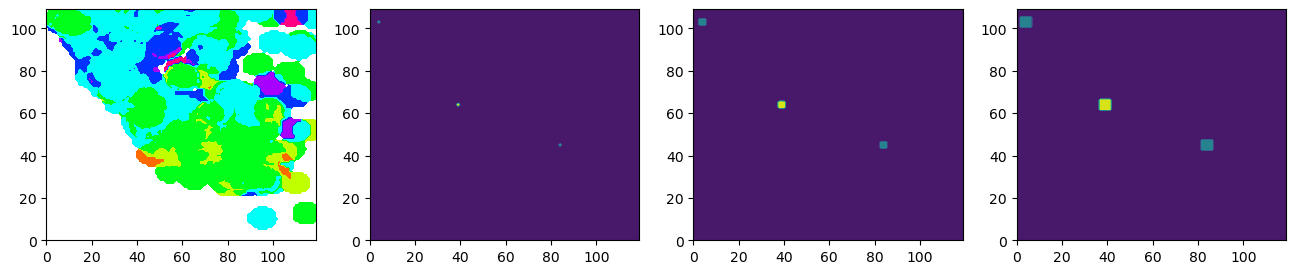

623
2006-11-09 08:38:13+00:00


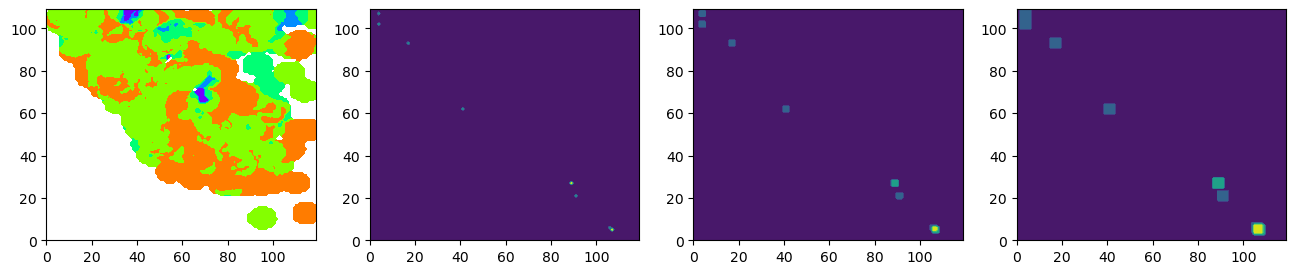

659
2007-02-26 12:19:58+00:00


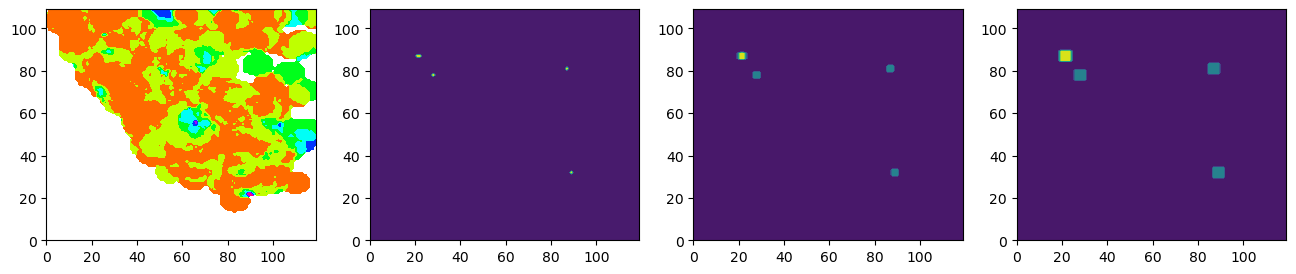

730
2007-05-09 07:50:08+00:00


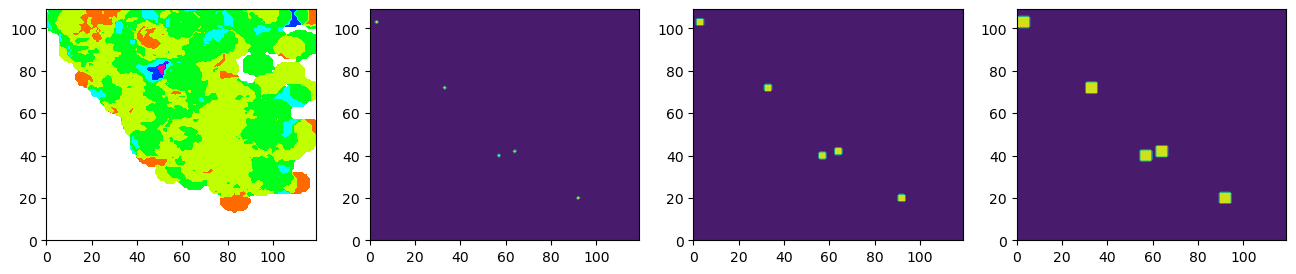

752
2007-10-31 03:04:55+00:00


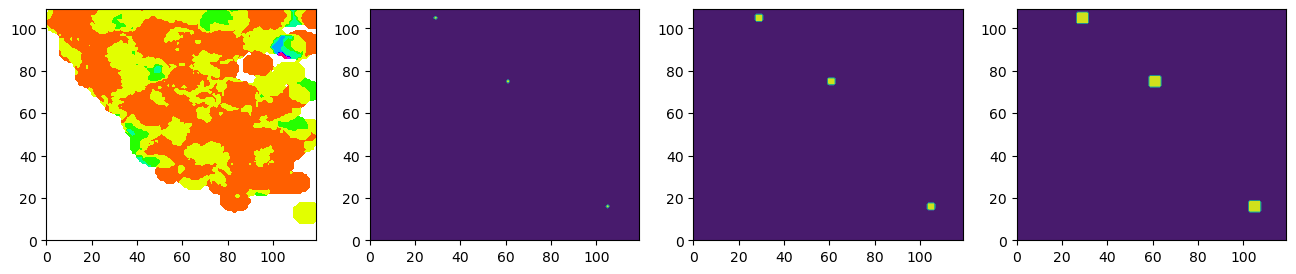

823
2008-01-19 23:13:05+00:00


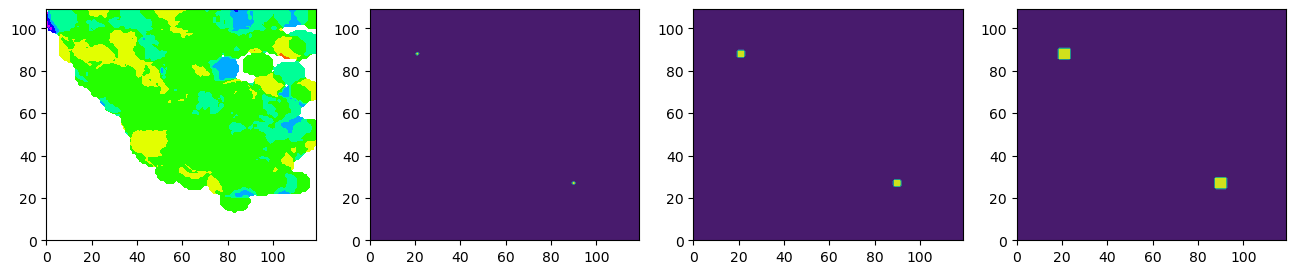

816
2008-02-09 07:12:07+00:00


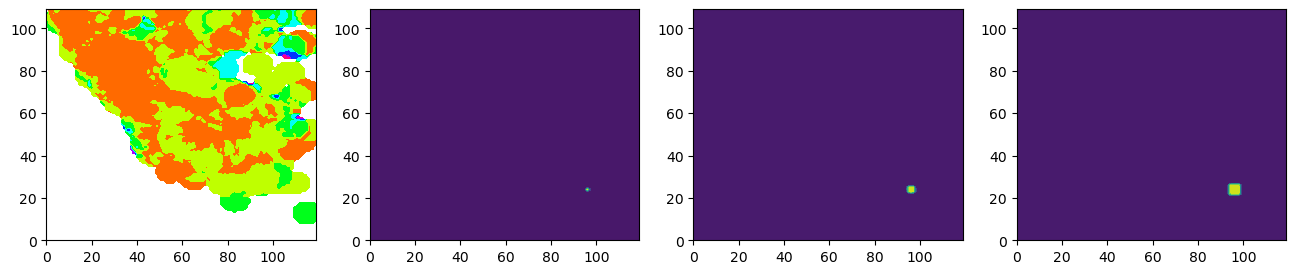

810
2008-02-11 18:29:34+00:00


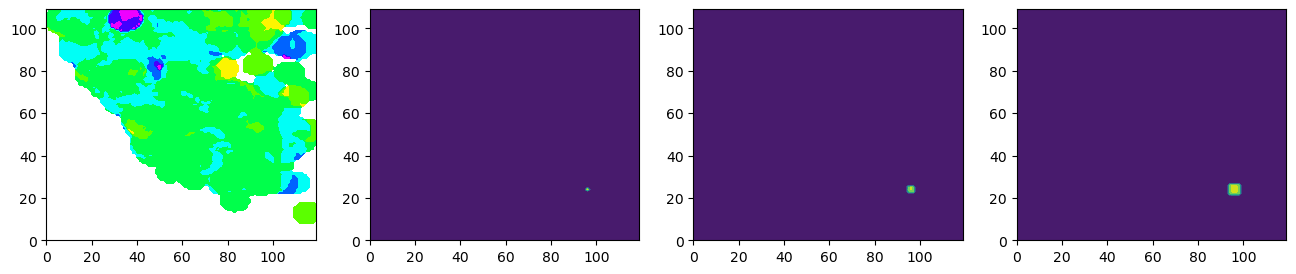

813
2008-02-12 04:32:38+00:00


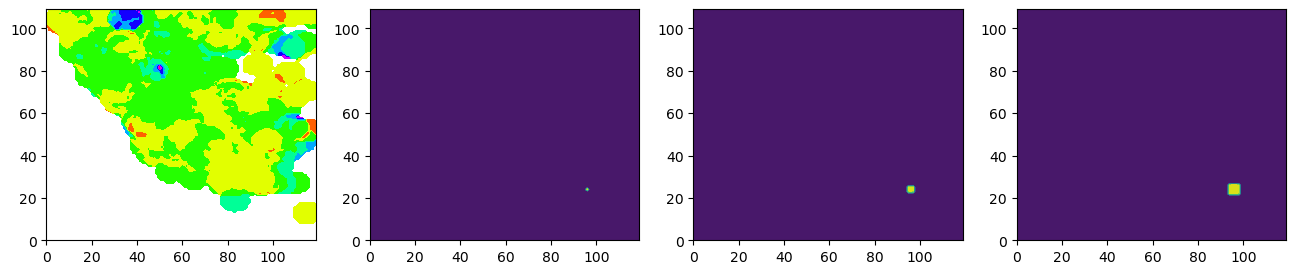

812
2008-02-19 22:41:29+00:00


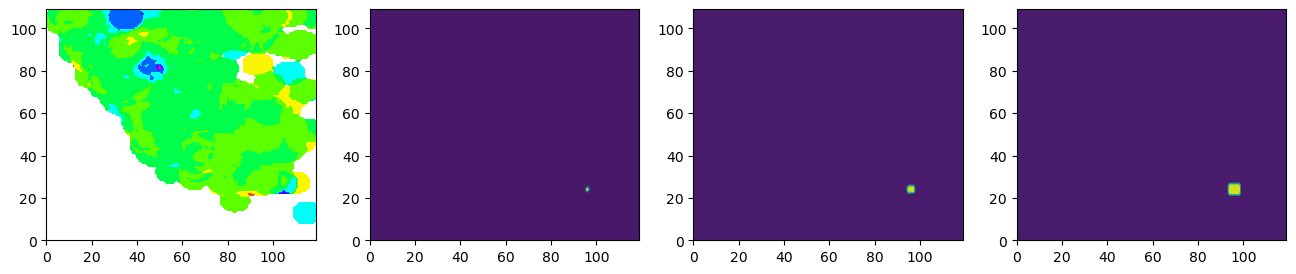

820
2008-04-26 06:40:11+00:00


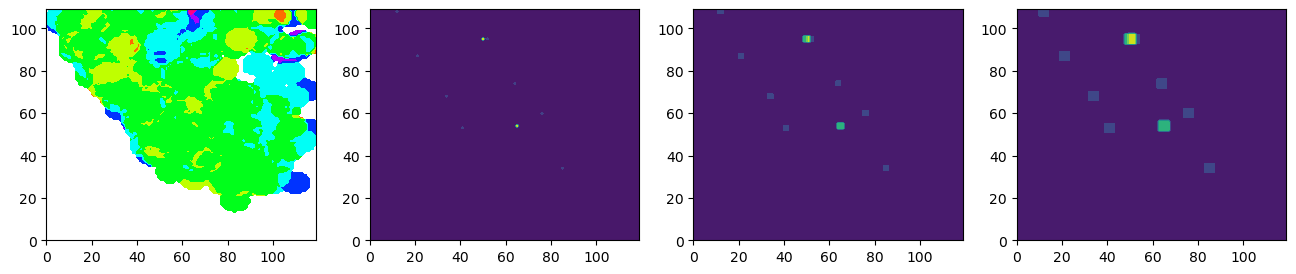

850
2008-04-30 03:03:06+00:00


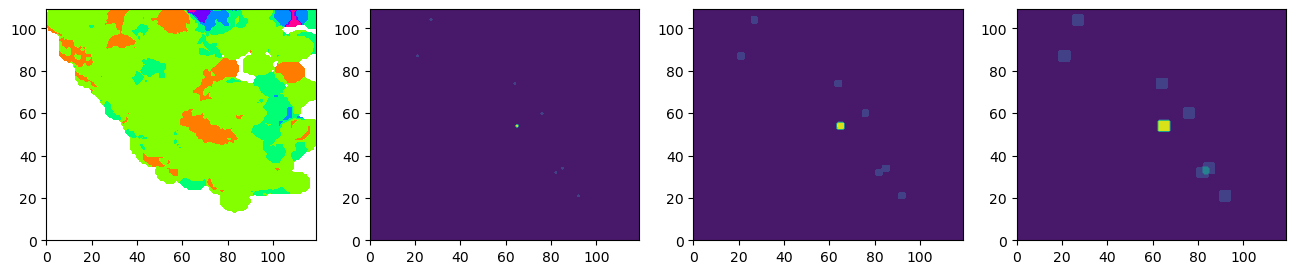

843
2008-06-30 22:49:59+00:00


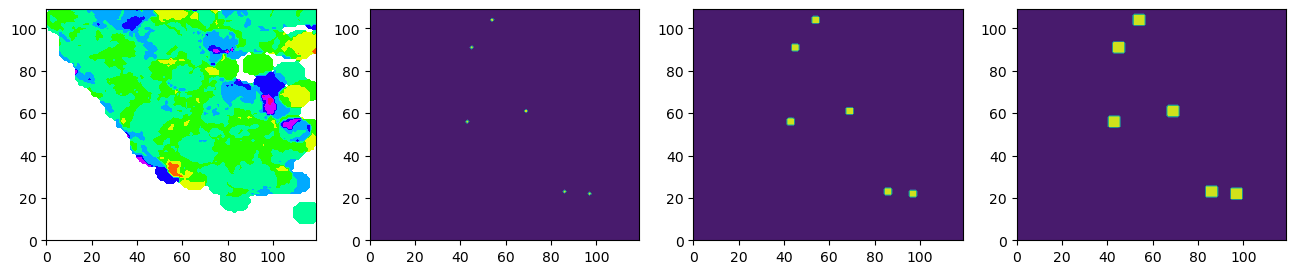

877
2008-07-29 18:42:16+00:00


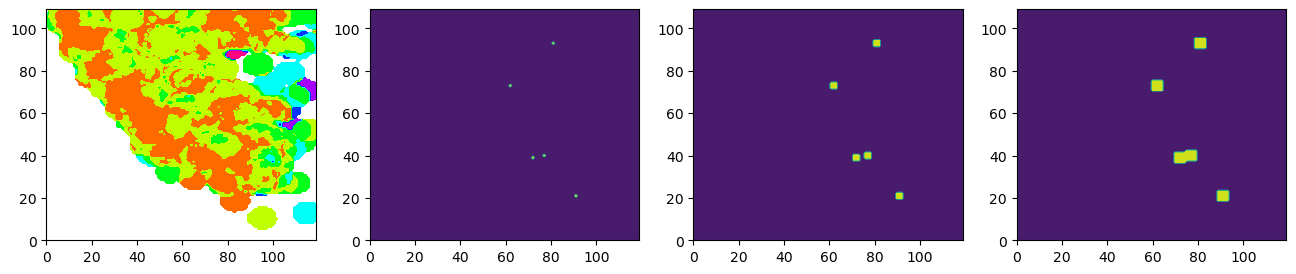

885
2008-10-26 09:27:20+00:00


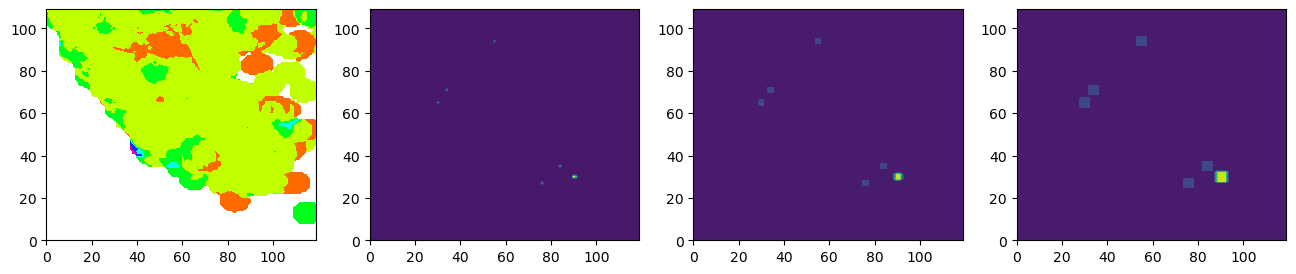

894
2008-12-06 04:18:43+00:00


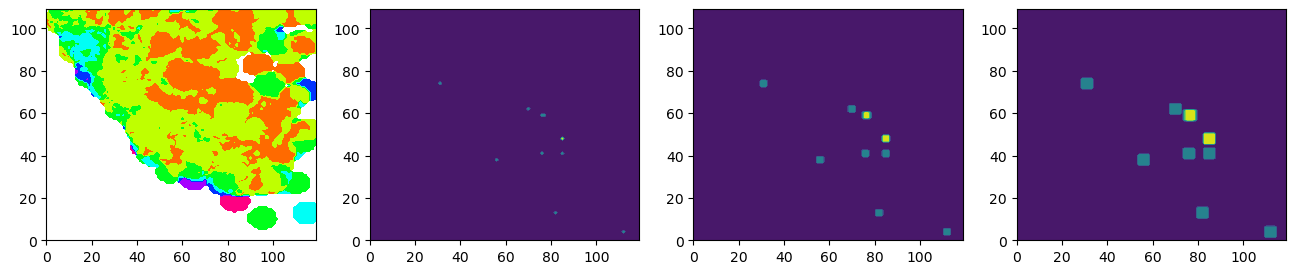

912
2009-03-24 11:55:43+00:00


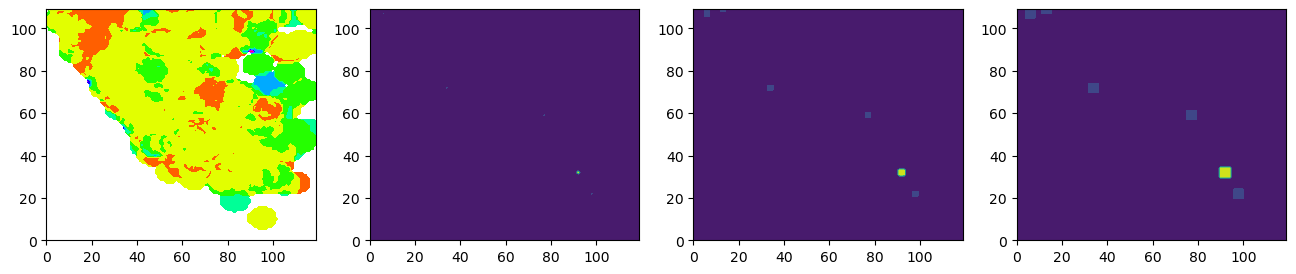

885
2009-05-18 03:39:35+00:00


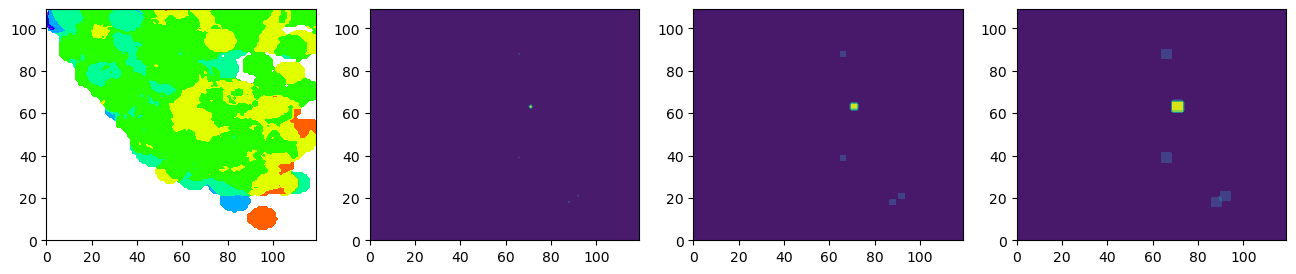

929
2009-08-07 10:49:34+00:00


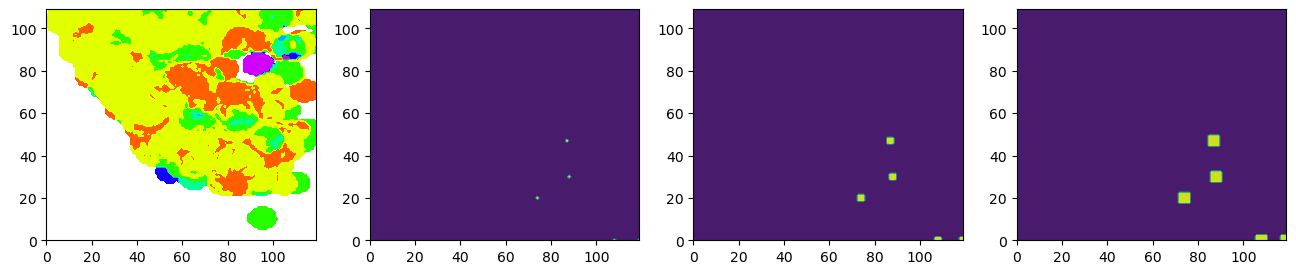

910
2009-09-19 22:55:18+00:00


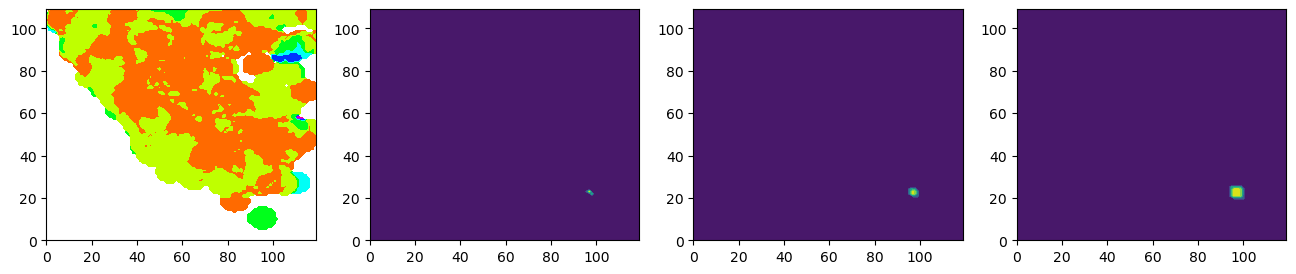

922
2009-10-01 10:01:25+00:00


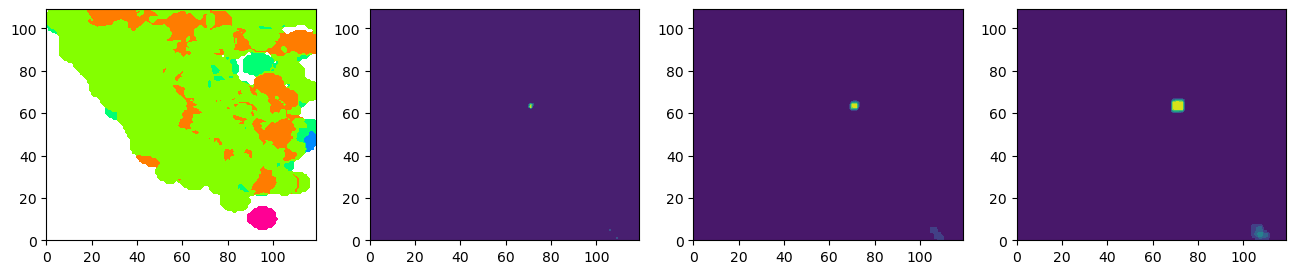

900
2009-10-03 01:16:01+00:00


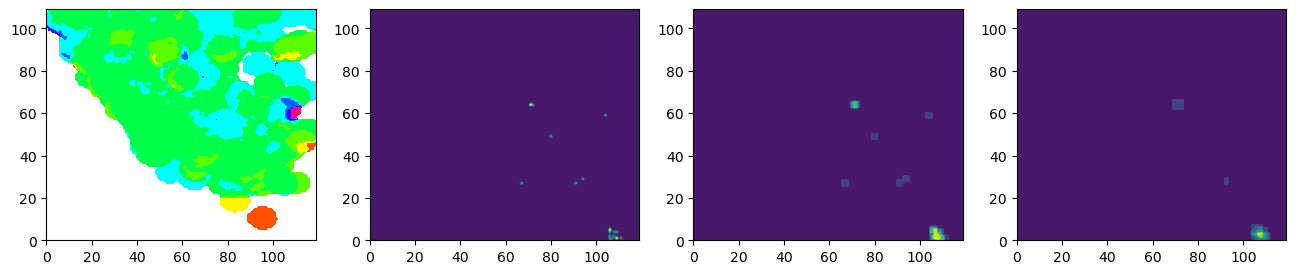

911
2009-11-16 21:21:30+00:00


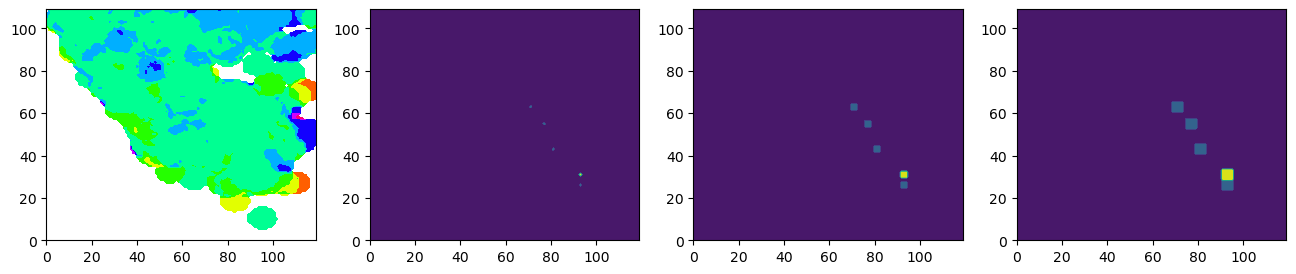

919
2009-12-30 18:48:58+00:00


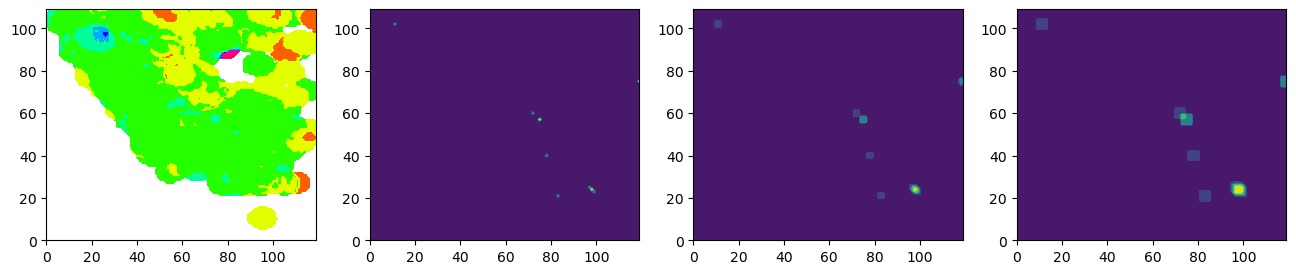

899
2010-01-10 00:27:41+00:00


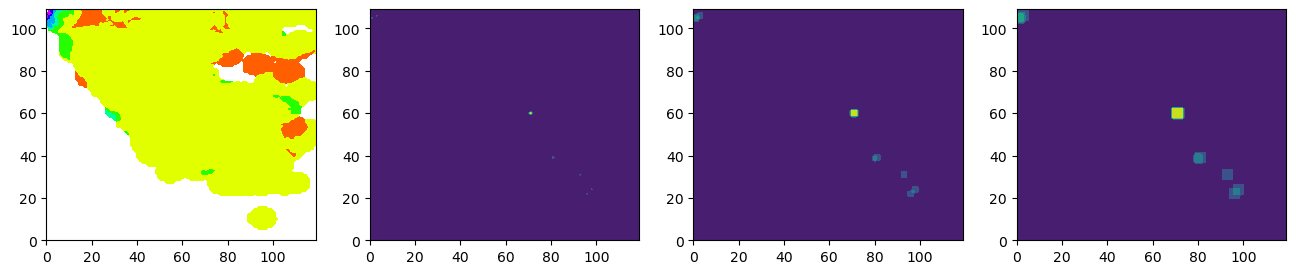

904
2010-02-04 20:20:22+00:00


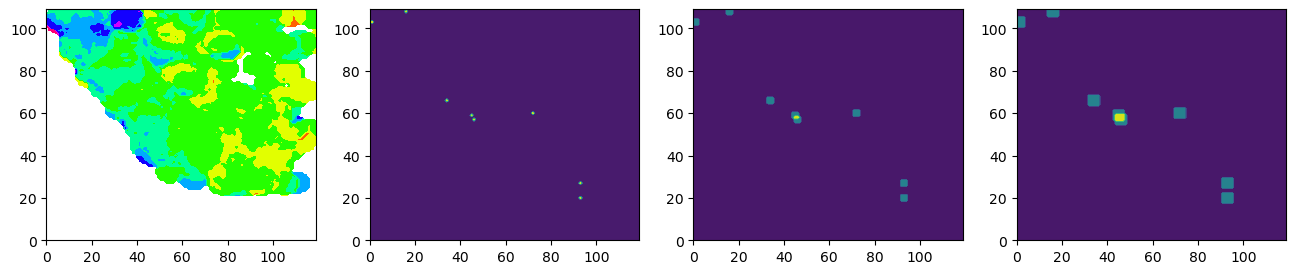

893
2010-04-04 22:40:43+00:00


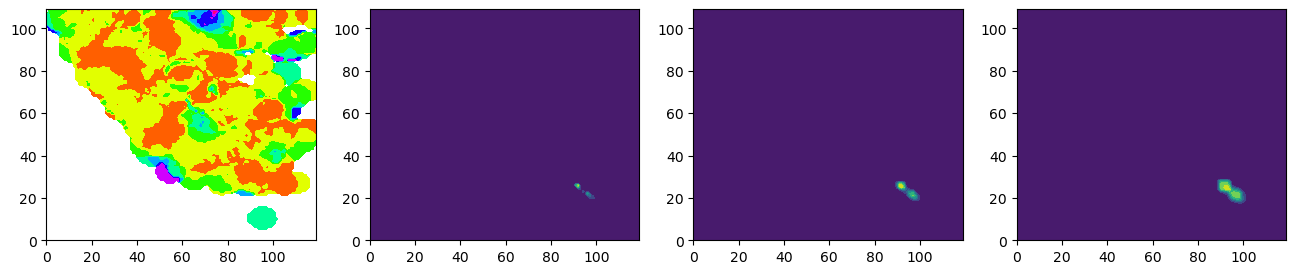

874
2010-04-04 22:50:17+00:00


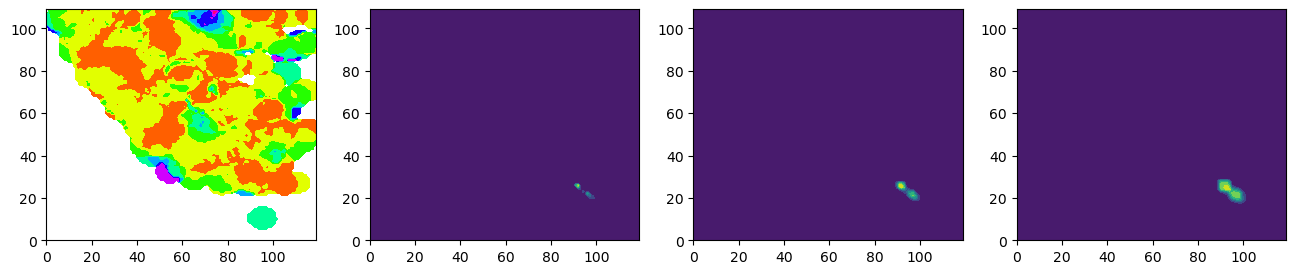

874
2010-04-04 23:15:13+00:00


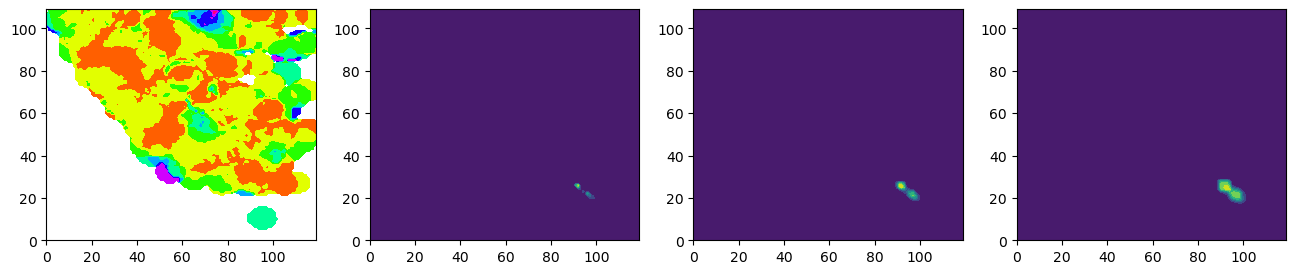

874
2010-04-04 23:25:07+00:00


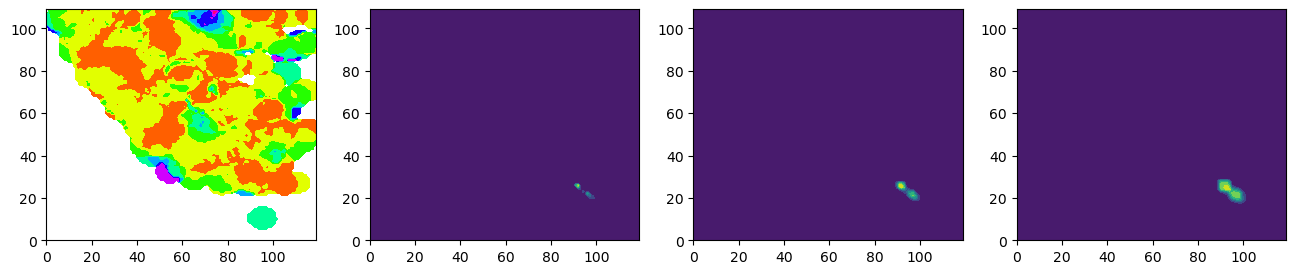

874
2010-04-05 00:07:09+00:00


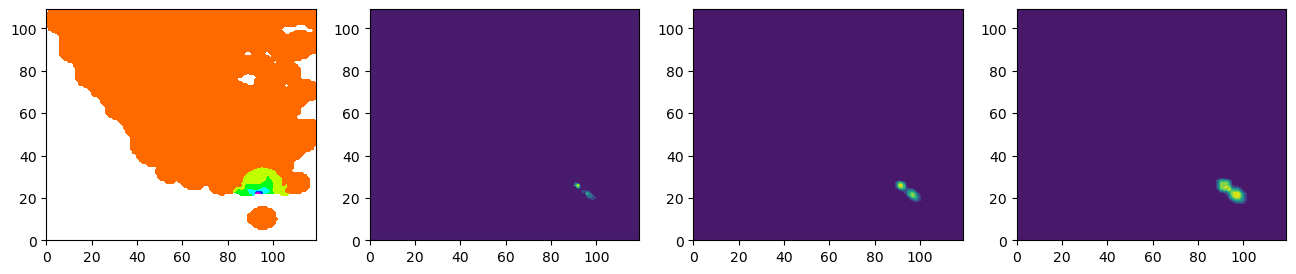

871
2010-04-05 11:14:15+00:00


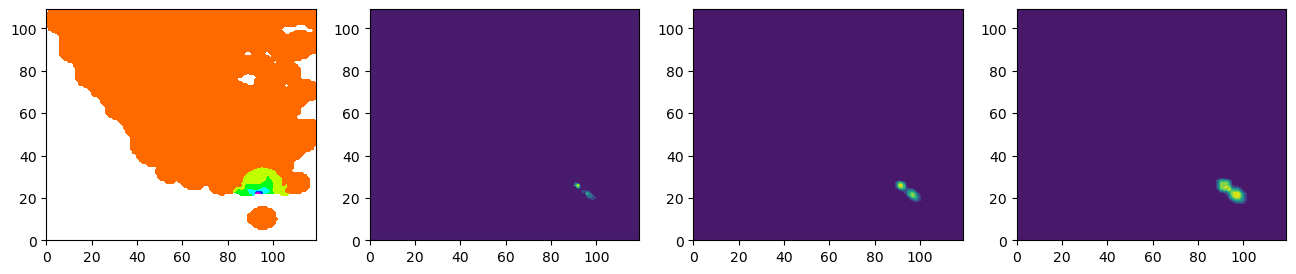

871
2010-04-05 13:33:05+00:00


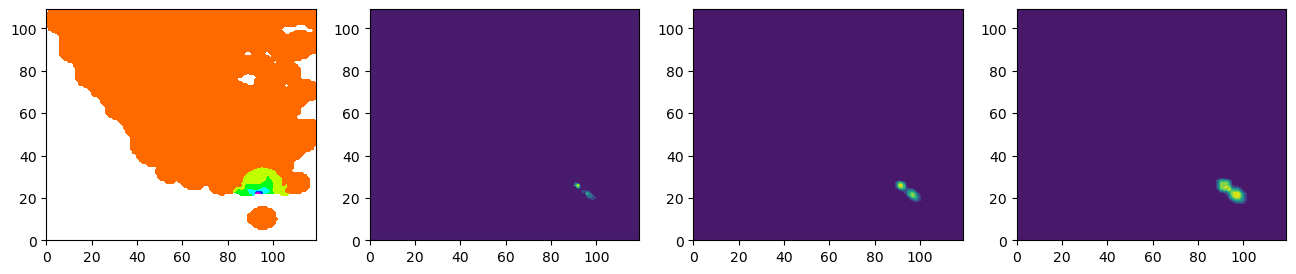

871
2010-04-08 16:44:26+00:00


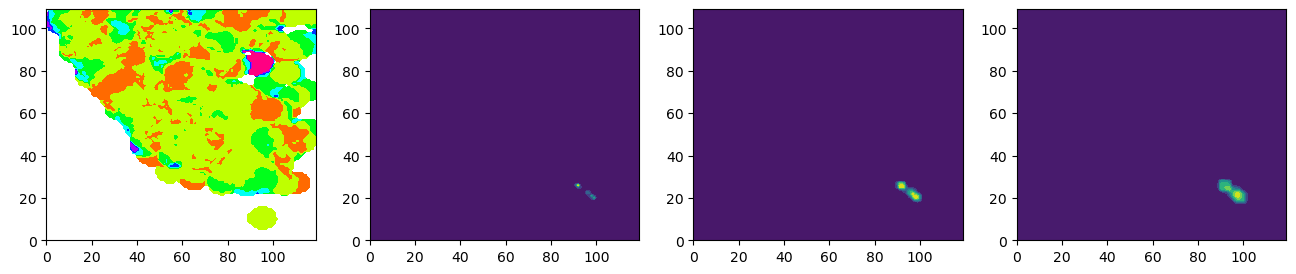

872
2010-05-08 18:33:11+00:00


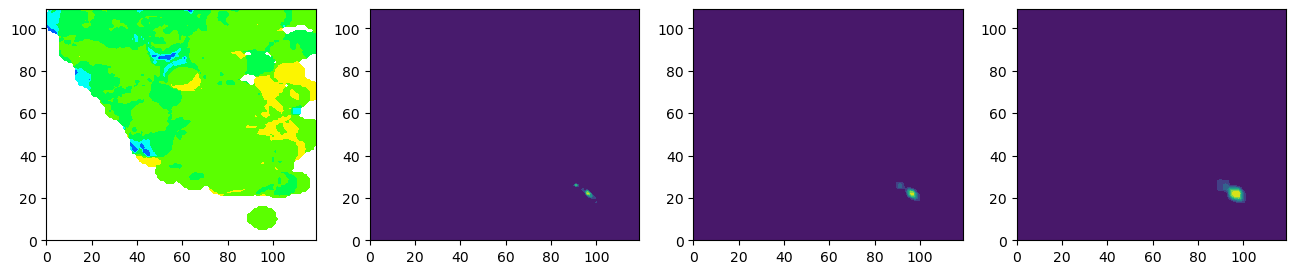

933
2010-05-22 17:30:58+00:00


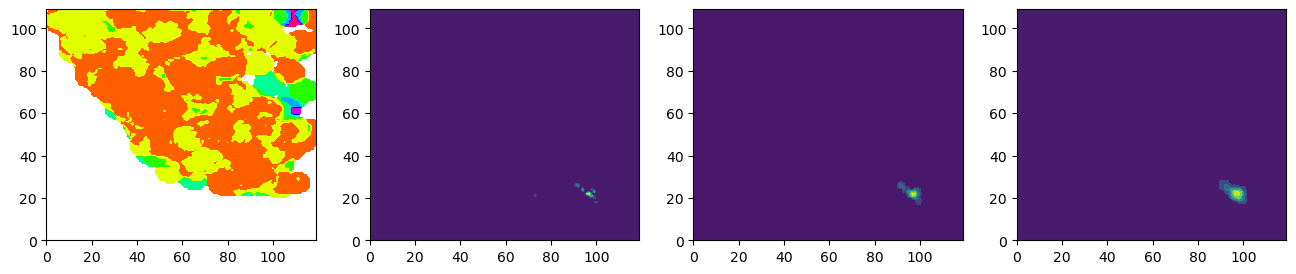

924
2010-06-15 04:26:58+00:00


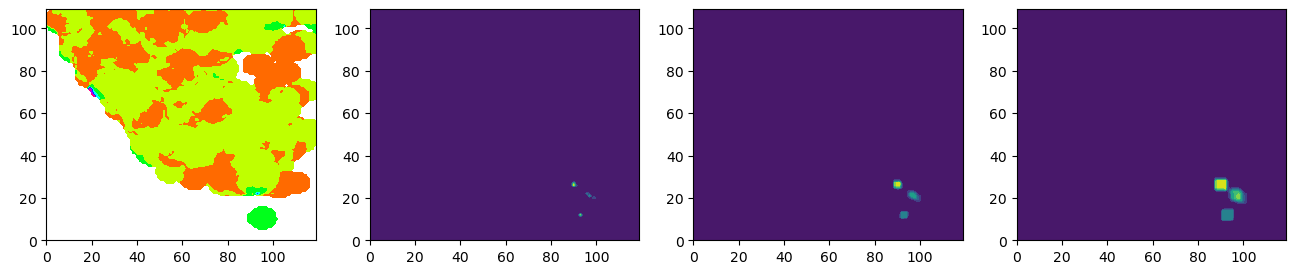

942
2010-07-07 23:53:34+00:00


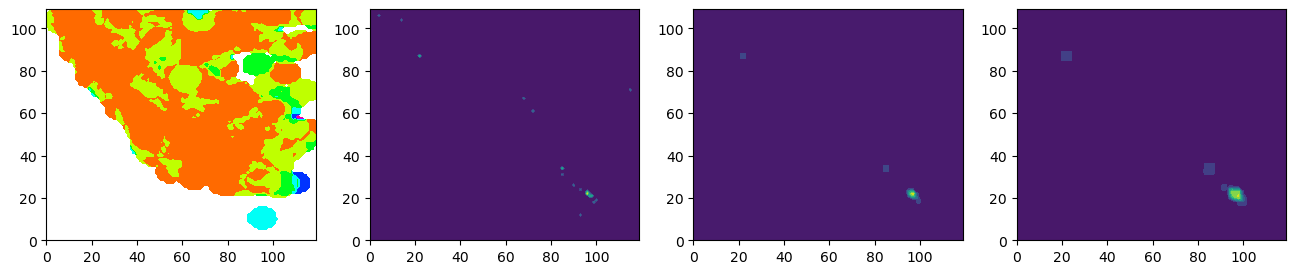

939
2010-09-14 10:52:19+00:00


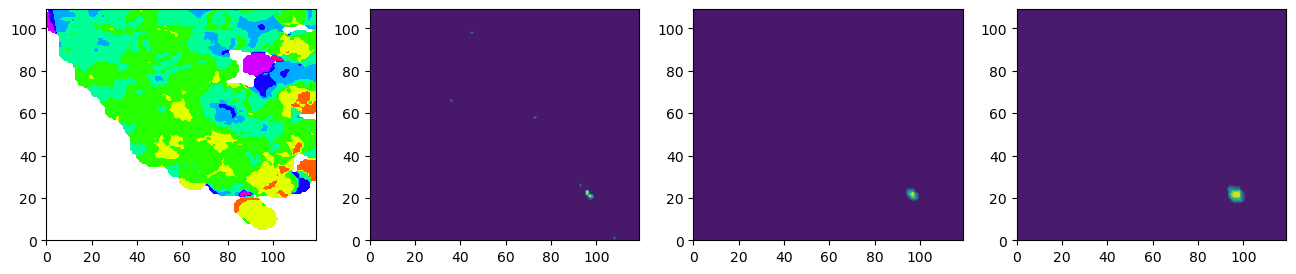

942
2011-02-18 17:47:36+00:00


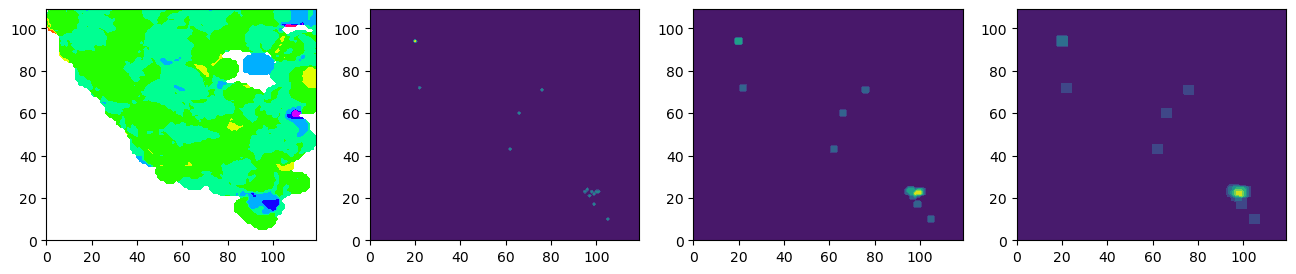

951
2012-08-26 19:31:22+00:00


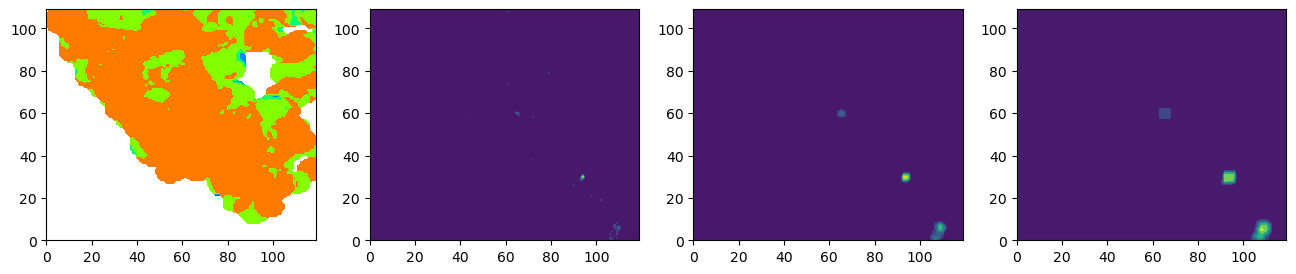

990
2012-08-26 20:57:57+00:00


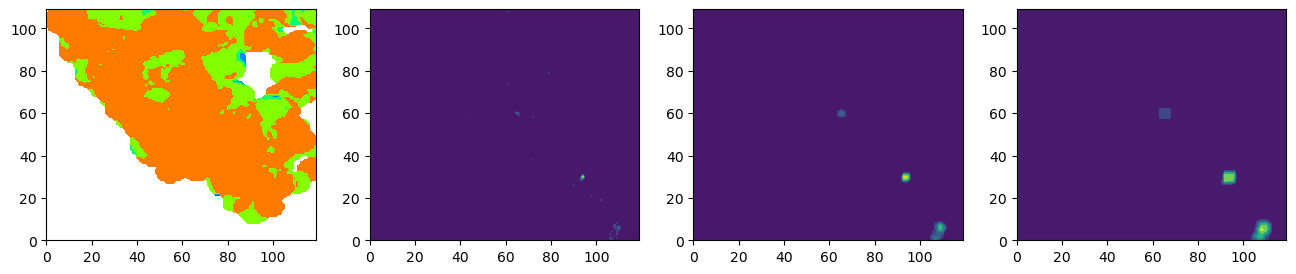

990
2012-08-27 05:23:20+00:00


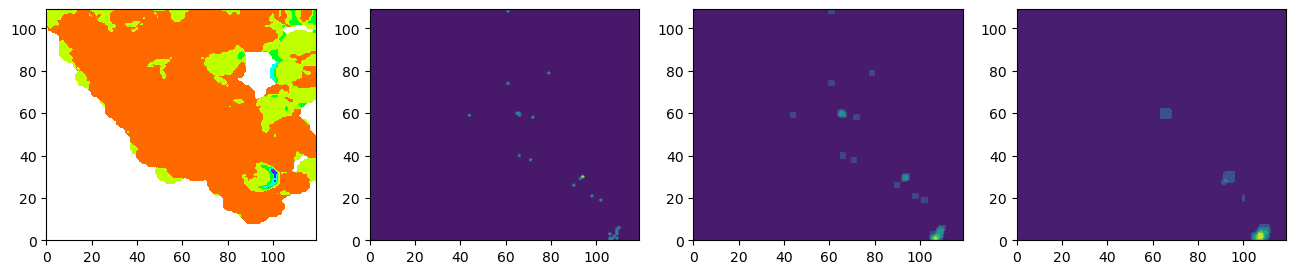

993
2012-08-27 23:15:59+00:00


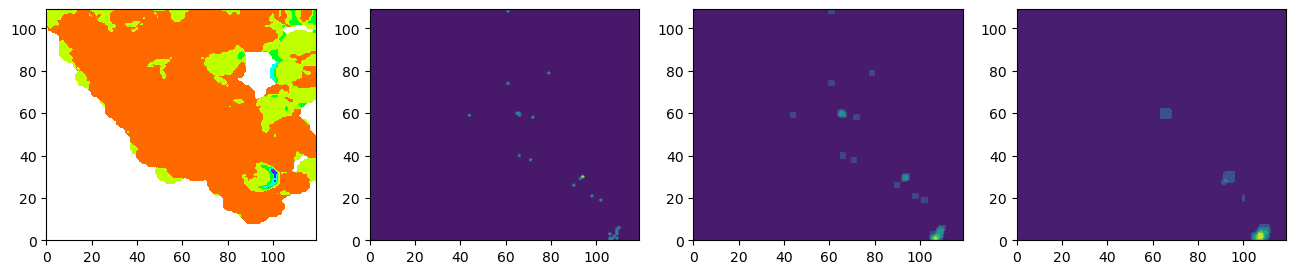

993
2012-10-21 06:55:10+00:00


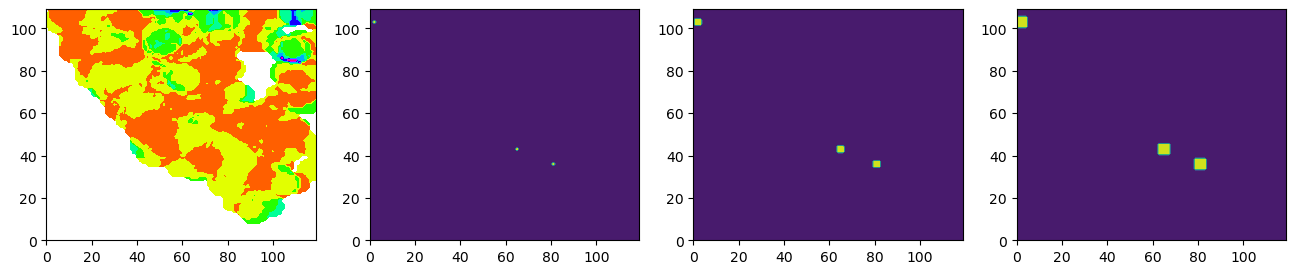

983
2012-12-14 10:36:01+00:00


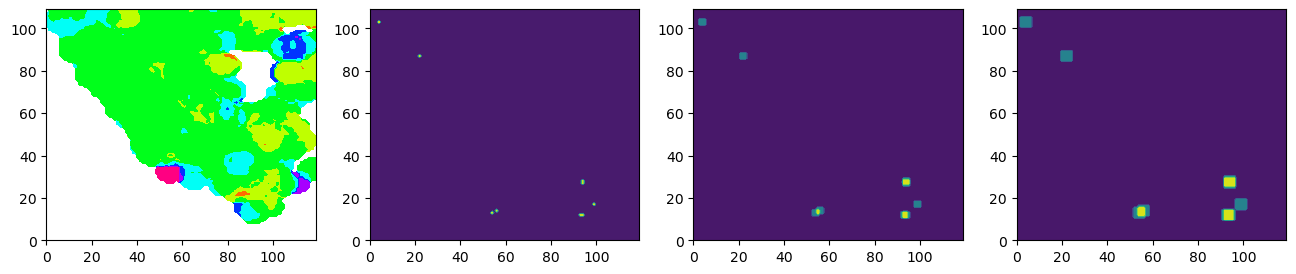

968
2012-12-14 10:50:28+00:00


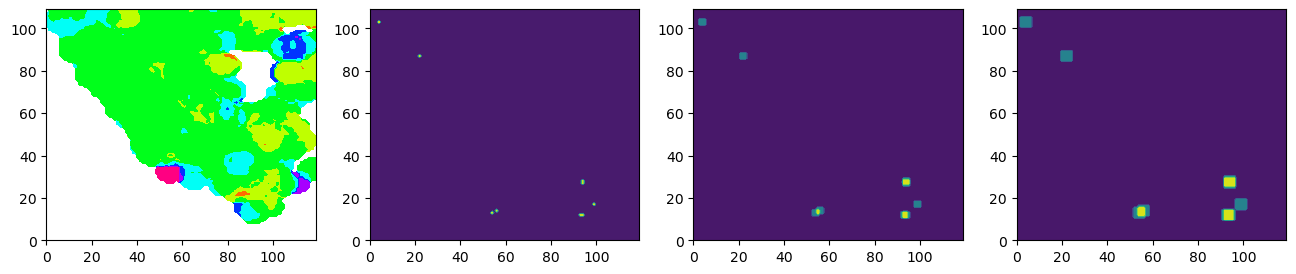

968
2013-02-13 00:10:15+00:00


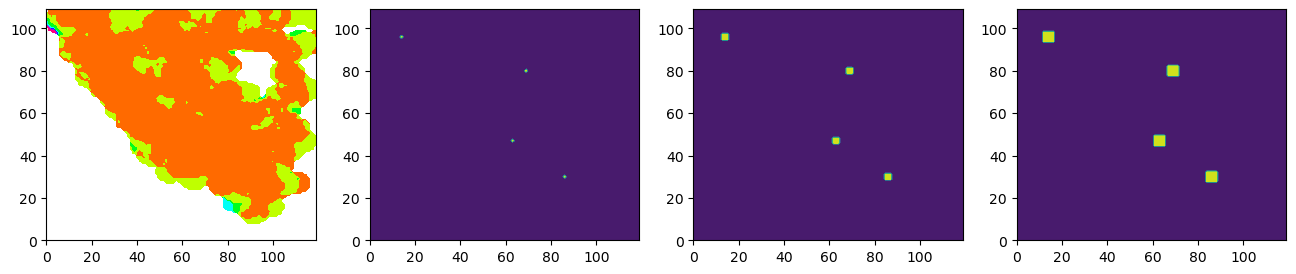

991
2013-05-24 03:47:08+00:00


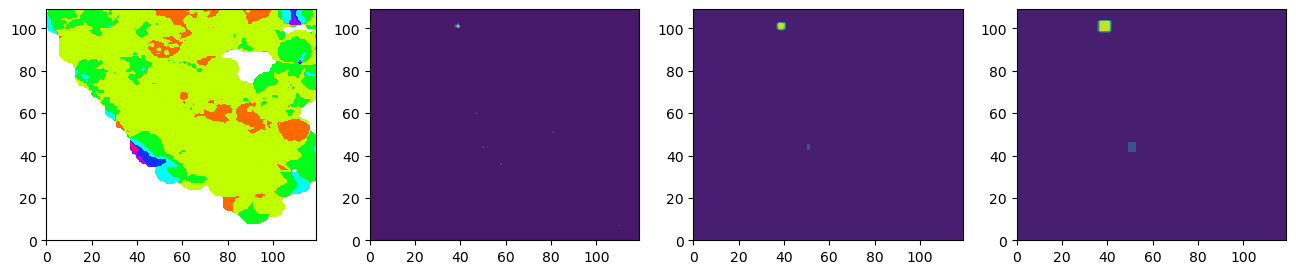

1019
2013-06-07 03:17:53+00:00


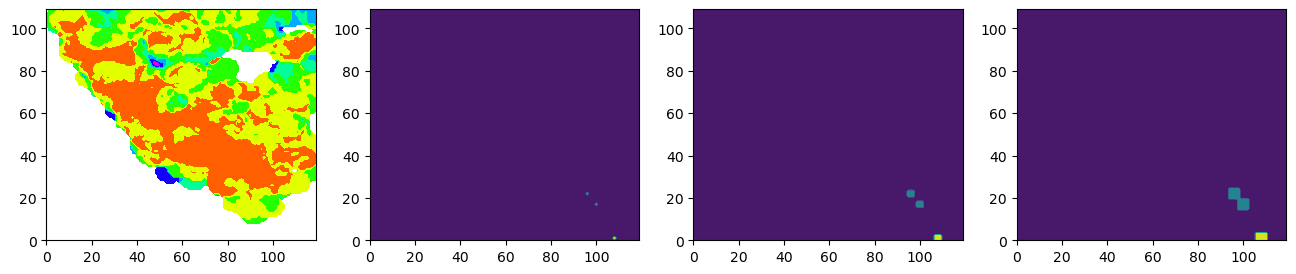

1026
2013-10-11 23:05:36+00:00


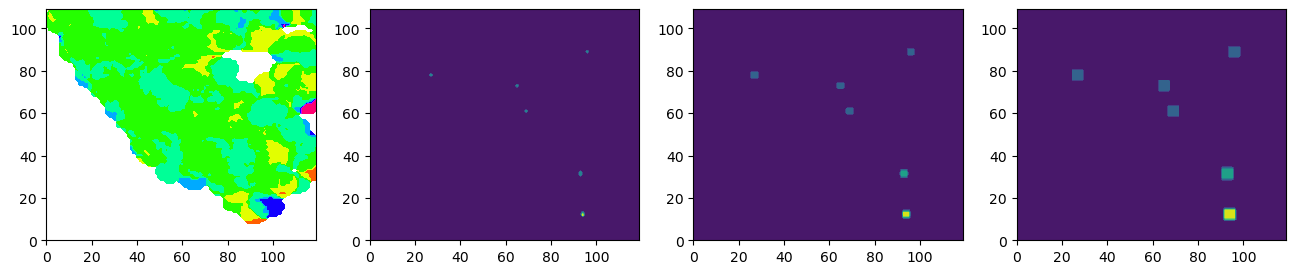

986
2013-12-20 05:27:08+00:00


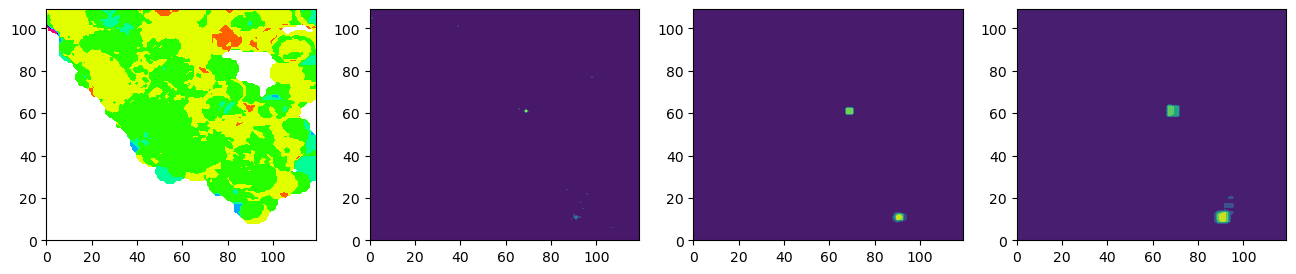

964
2014-03-21 17:37:13+00:00


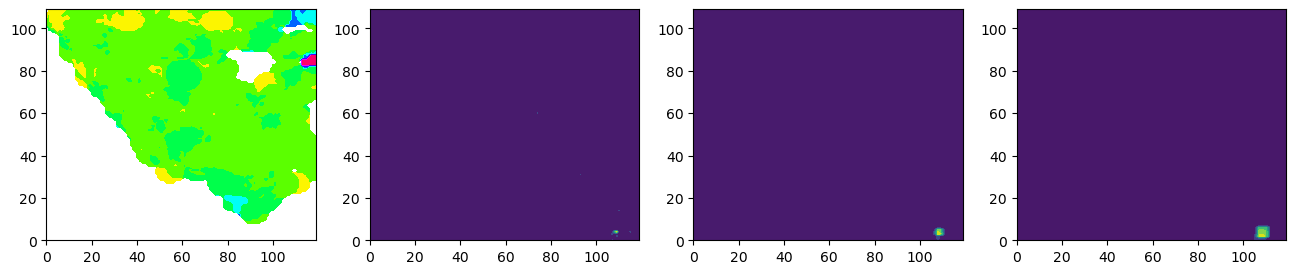

1029
2014-03-21 17:50:12+00:00


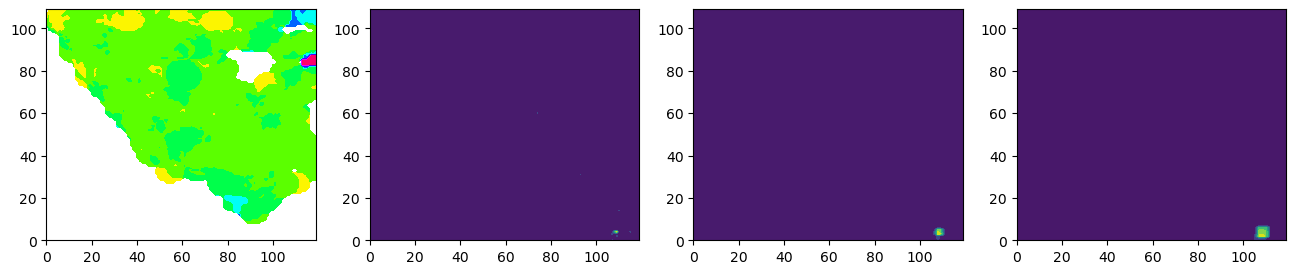

1029
2014-03-22 00:58:10+00:00


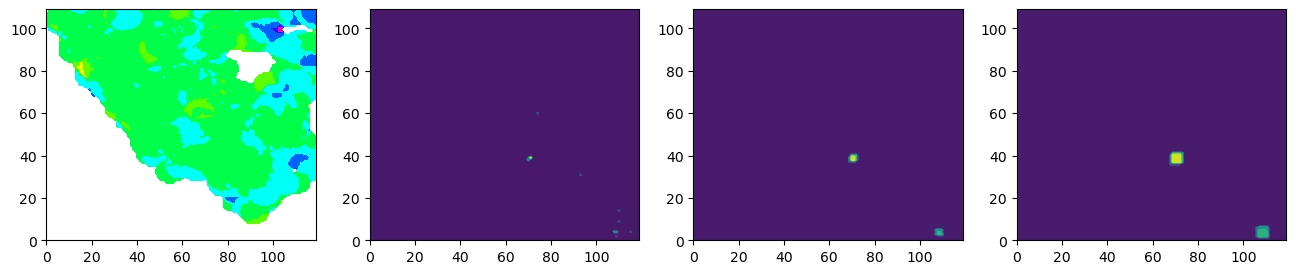

1036
2014-03-29 04:09:43+00:00


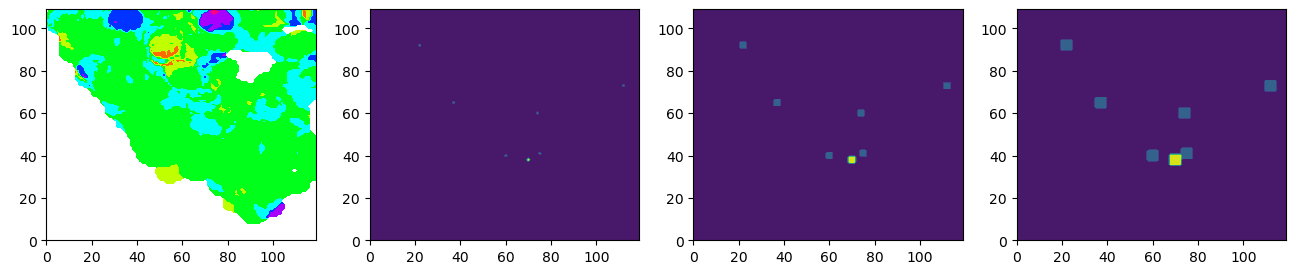

1036
2014-08-24 10:20:45+00:00


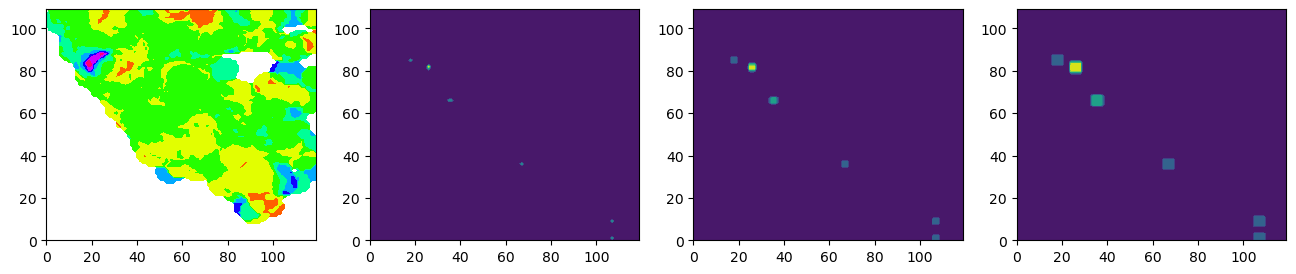

1022
2014-09-15 06:50:09+00:00


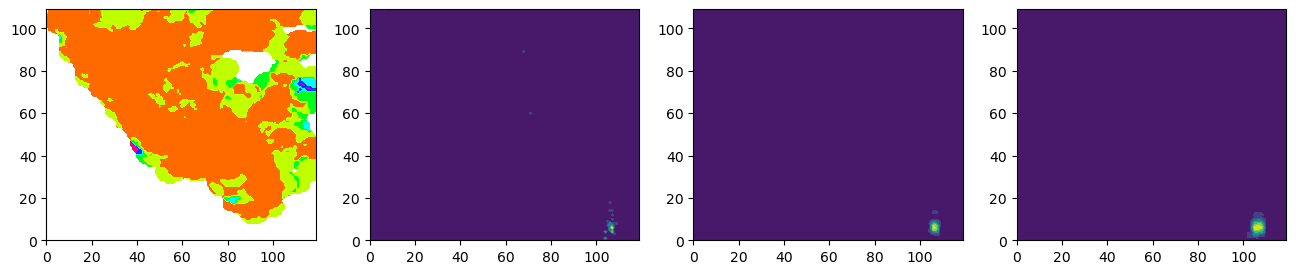

1022
2014-09-15 12:23:41+00:00


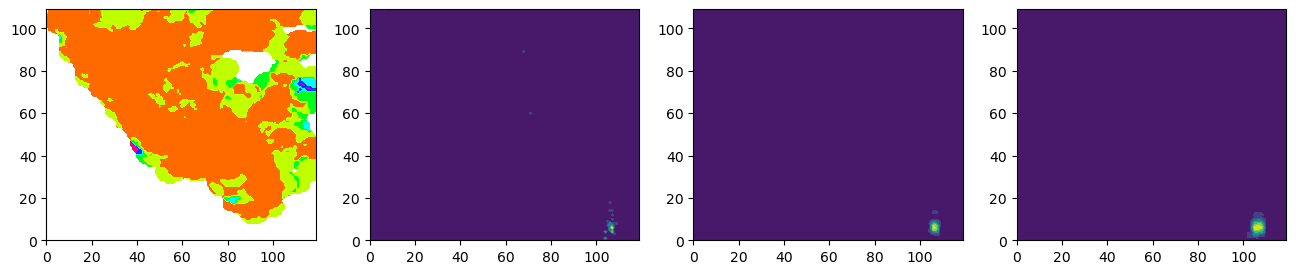

1022
2014-09-15 18:27:20+00:00


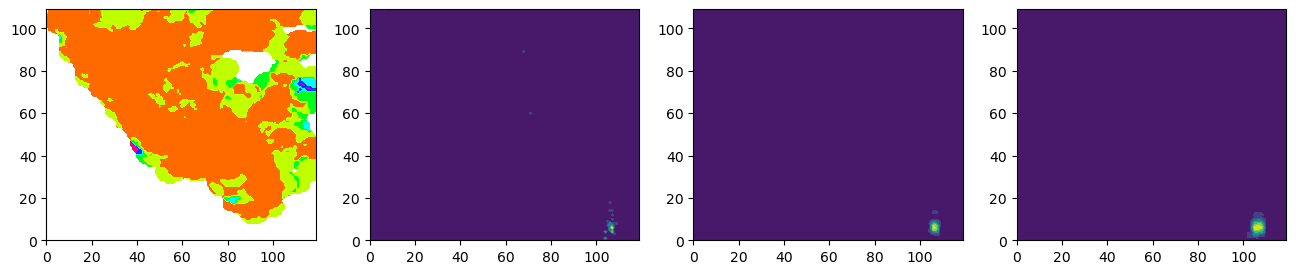

1022
2015-01-28 21:08:54+00:00


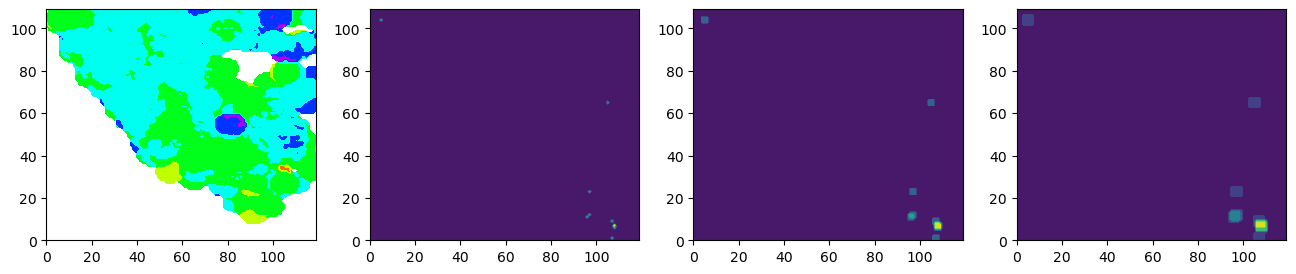

1019
2015-02-09 01:45:02+00:00


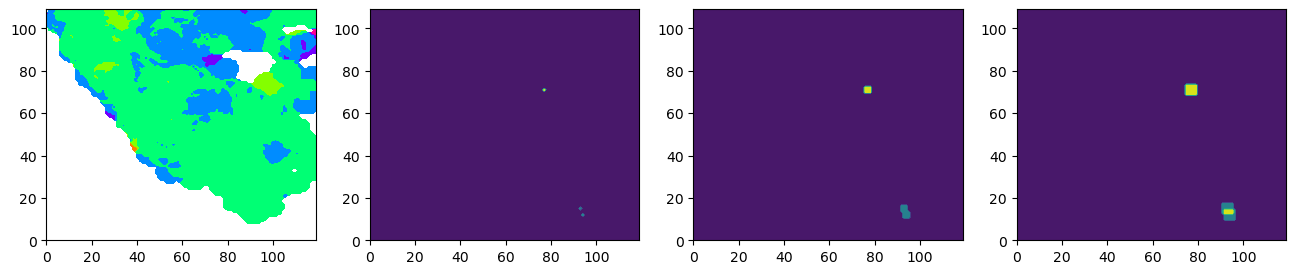

1025
2015-05-22 18:47:43+00:00


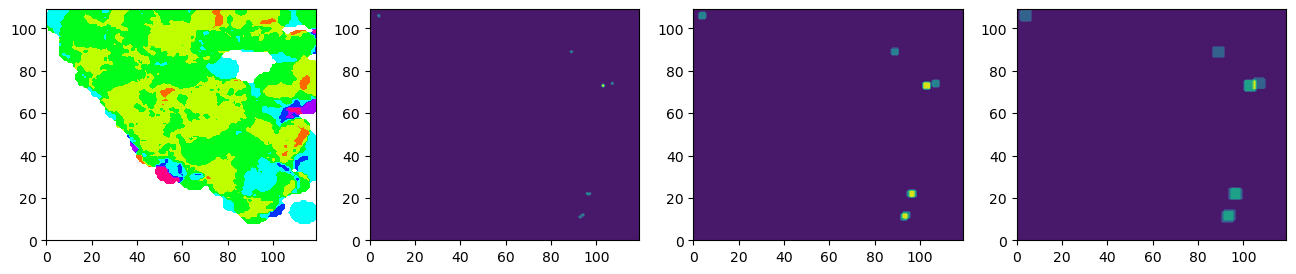

1031
2016-06-10 08:04:38+00:00


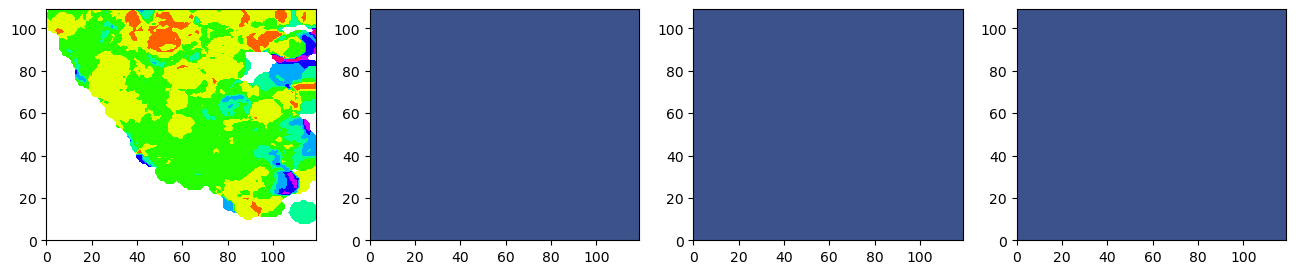

1088
2016-12-14 16:41:05+00:00


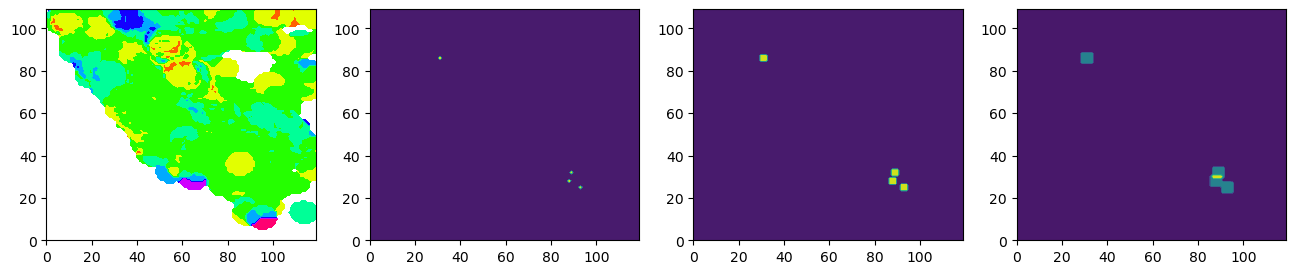

1070
2016-12-28 08:18:00+00:00


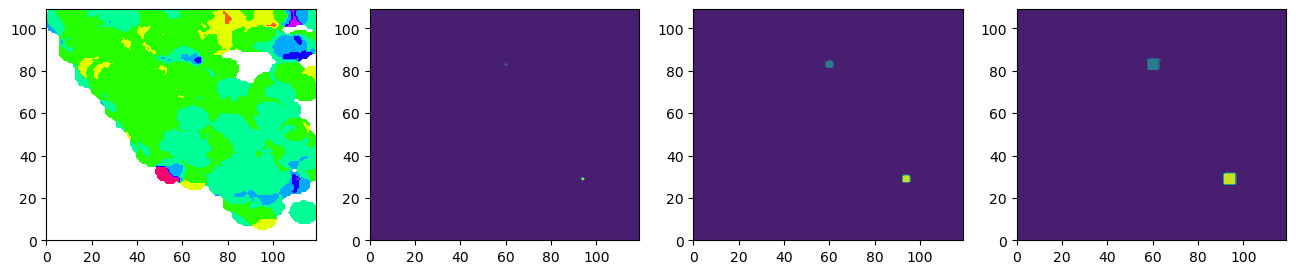

1027
2016-12-28 08:22:12+00:00


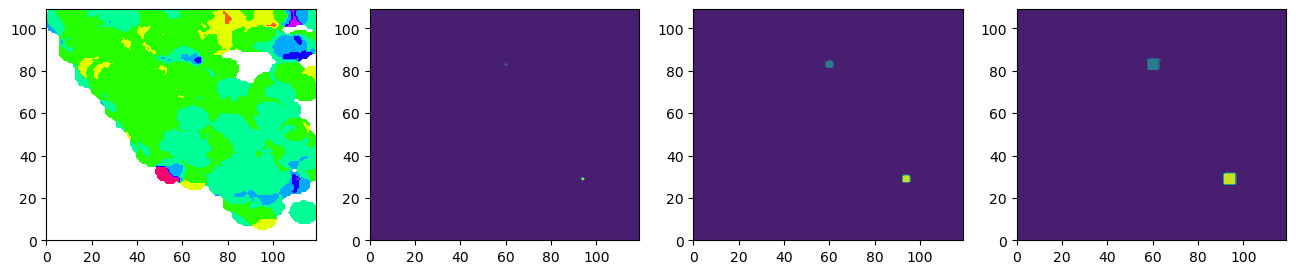

1027
2016-12-28 09:13:47+00:00


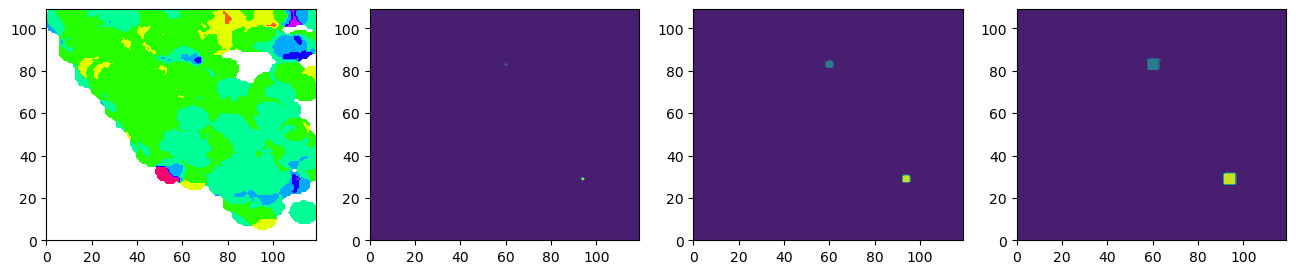

1027
2018-04-05 19:29:16+00:00


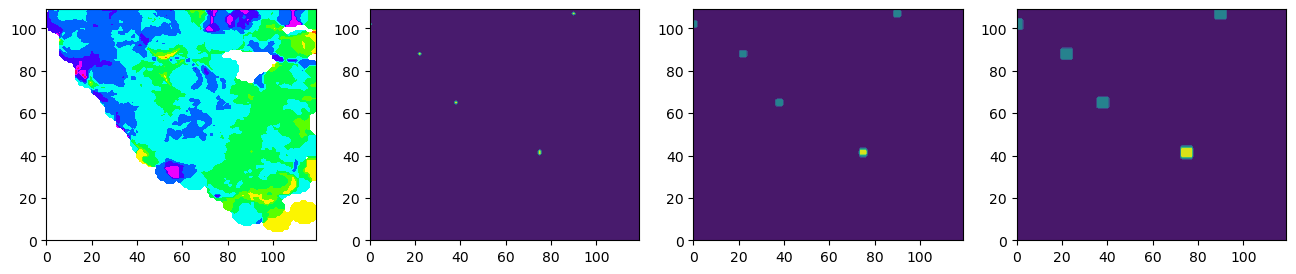

1106
2019-04-06 21:01:41+00:00


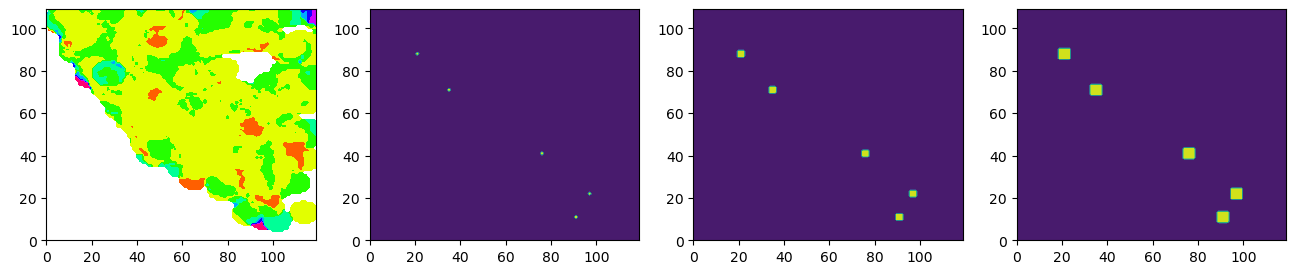

1079
2019-06-23 03:53:02+00:00


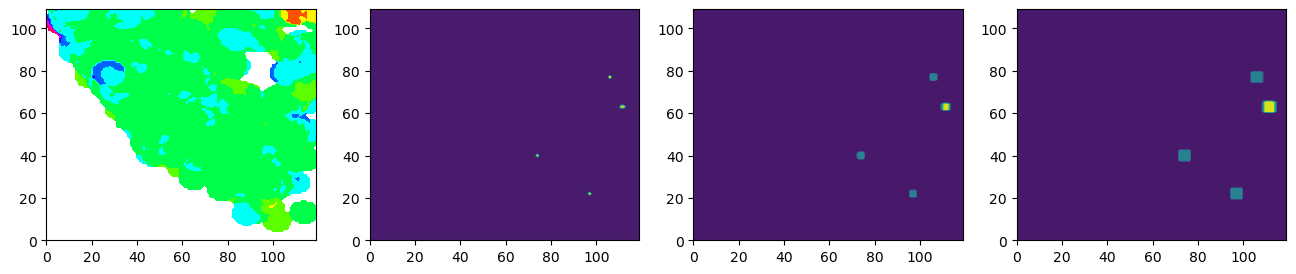

1078
2019-07-04 17:33:49+00:00


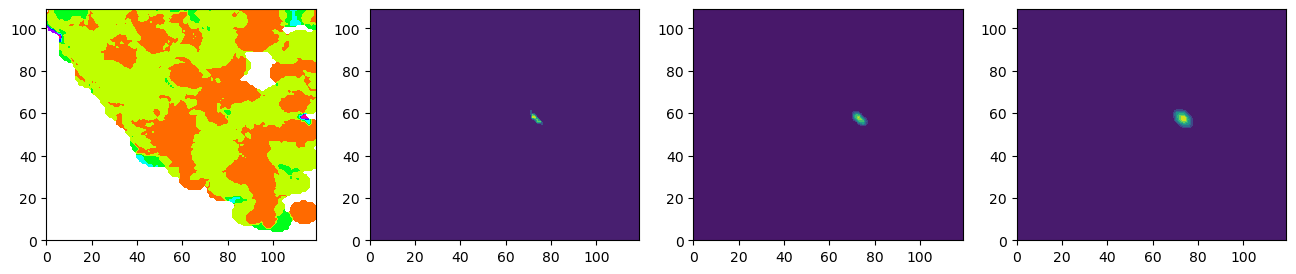

1085
2019-07-05 11:07:53+00:00


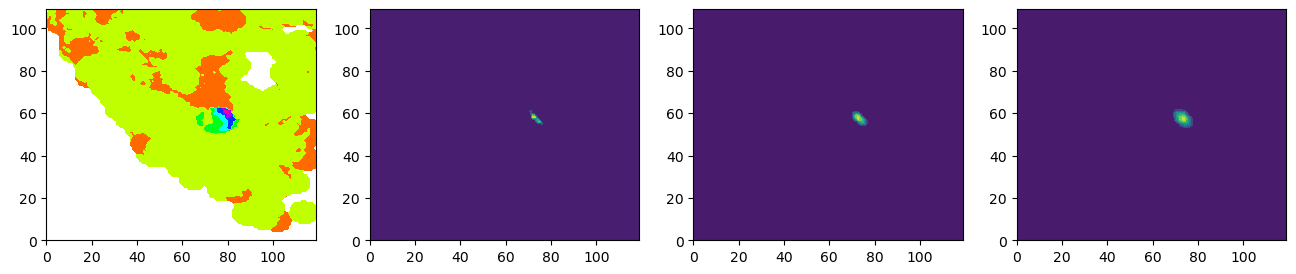

1066
2019-07-06 03:19:53+00:00


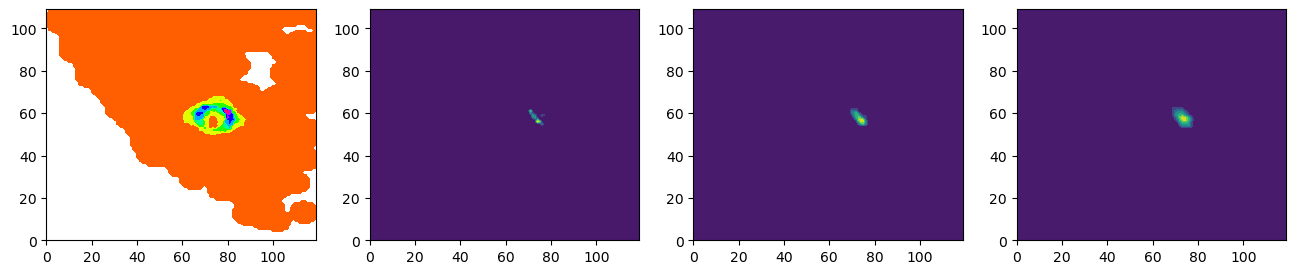

1063
2019-07-06 03:22:35+00:00


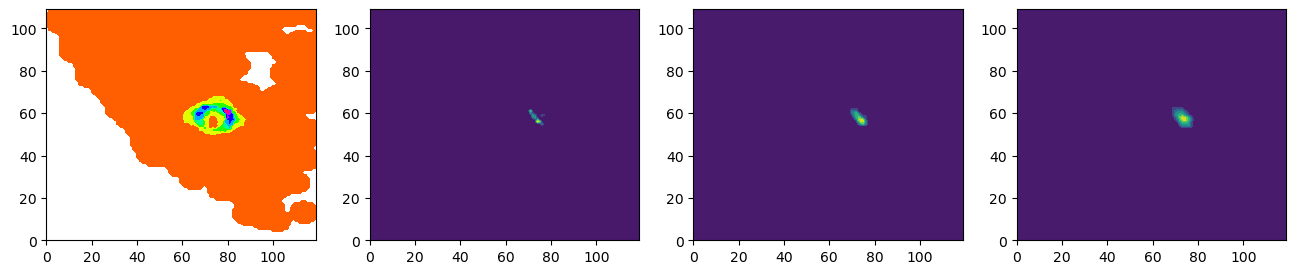

1063
2019-07-06 03:22:48+00:00


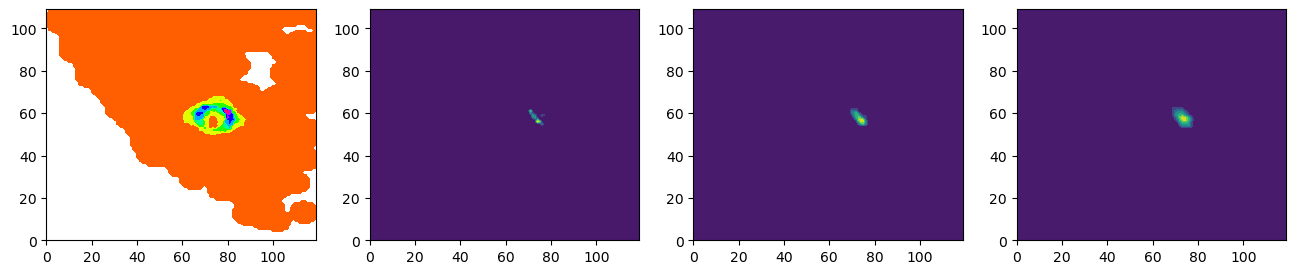

1063
2019-07-06 03:47:53+00:00


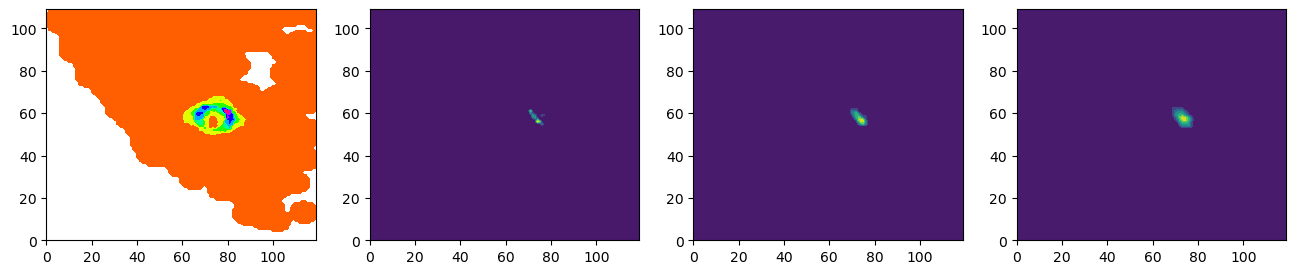

1063
2019-07-06 04:07:04+00:00


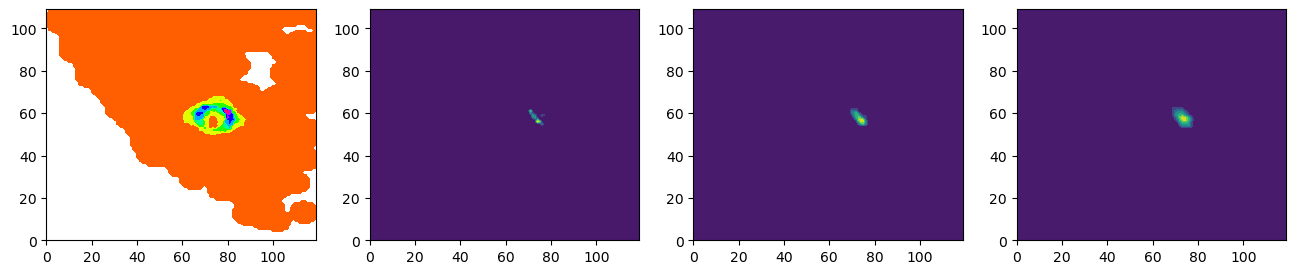

1063
2019-07-06 04:18:55+00:00


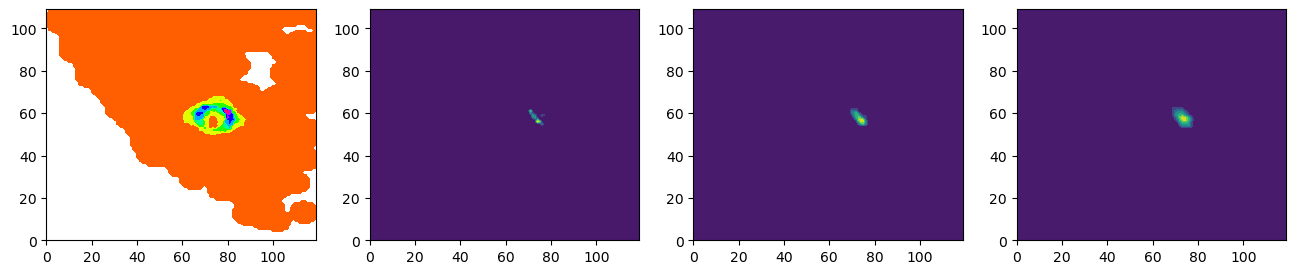

1063
2019-07-06 04:36:55+00:00


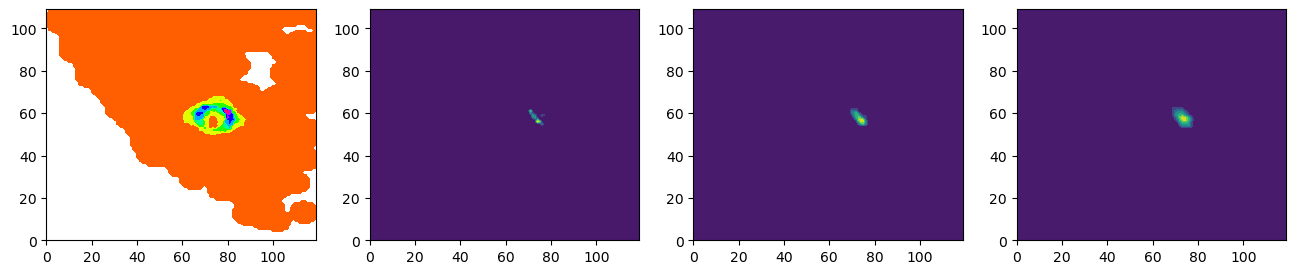

1063
2019-08-22 20:49:50+00:00


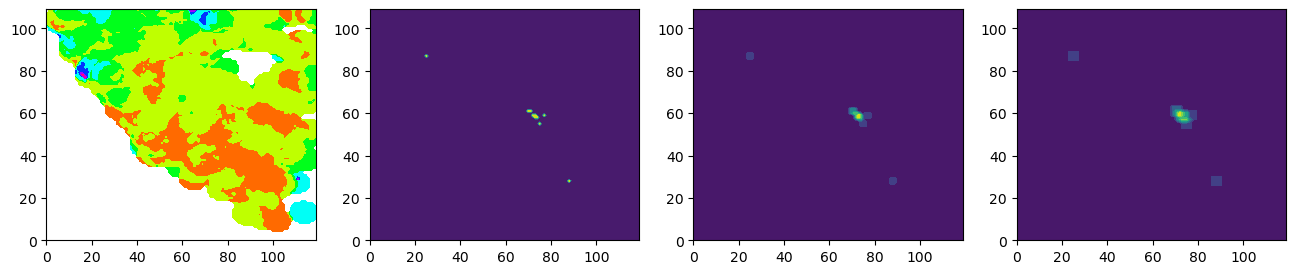

1113
2020-03-07 03:52:03+00:00


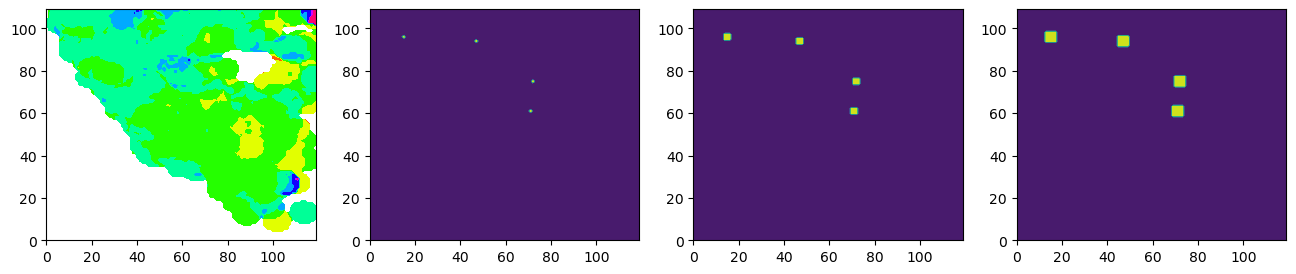

1086
2020-03-18 22:08:20+00:00


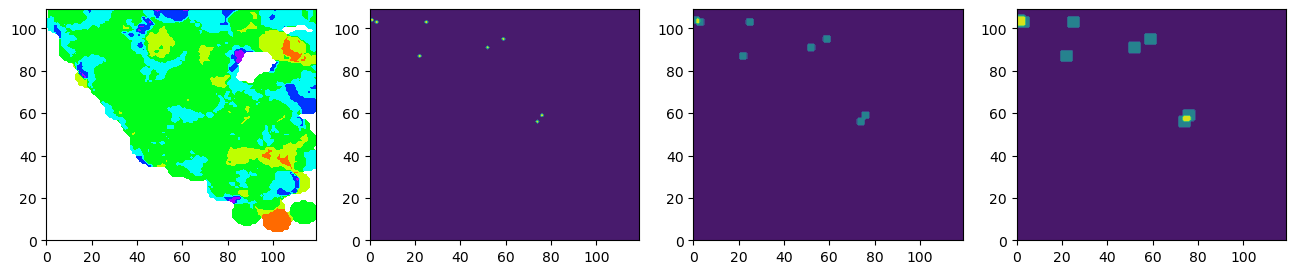

1081
2020-03-25 02:58:37+00:00


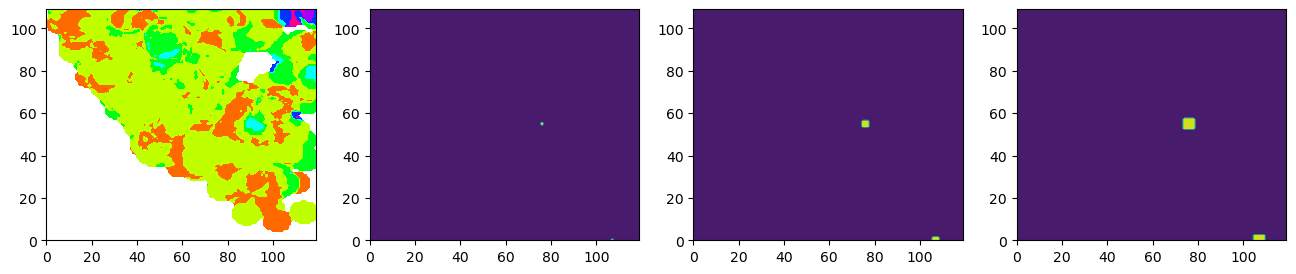

1047
2020-04-11 14:36:37+00:00


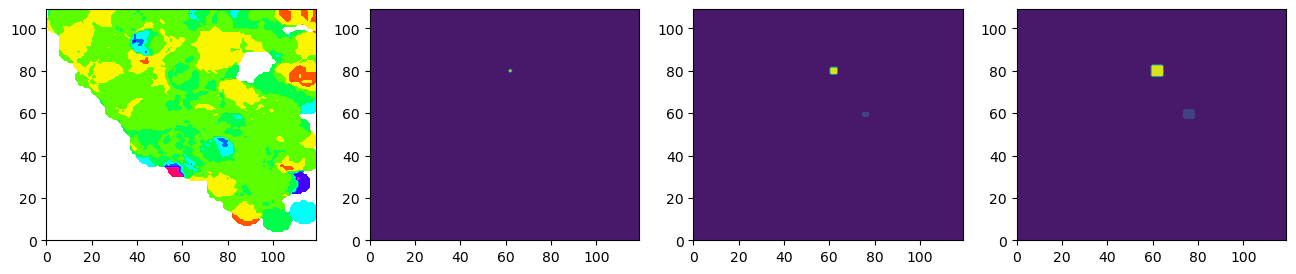

1025
2020-05-15 11:03:27+00:00


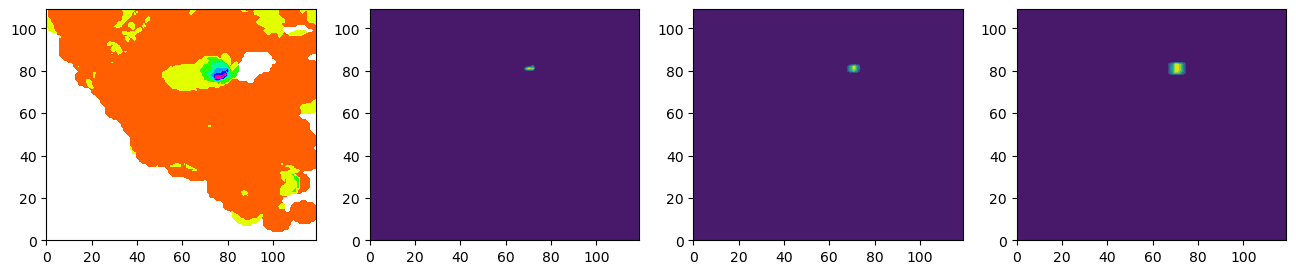

1073
2020-05-15 11:26:01+00:00


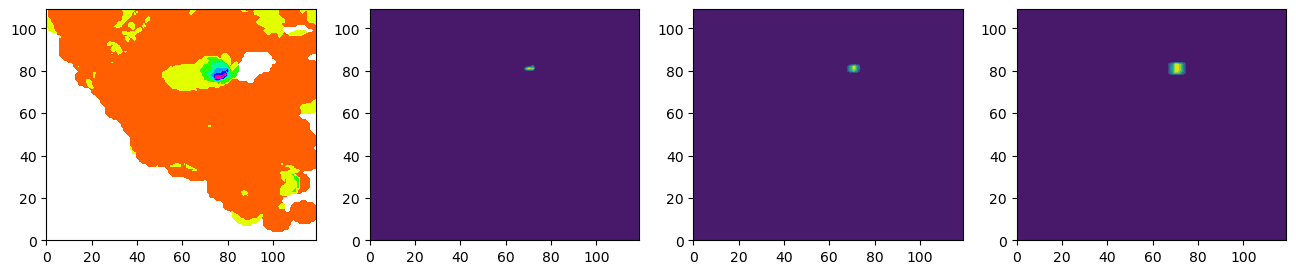

1073
2020-05-20 12:36:53+00:00


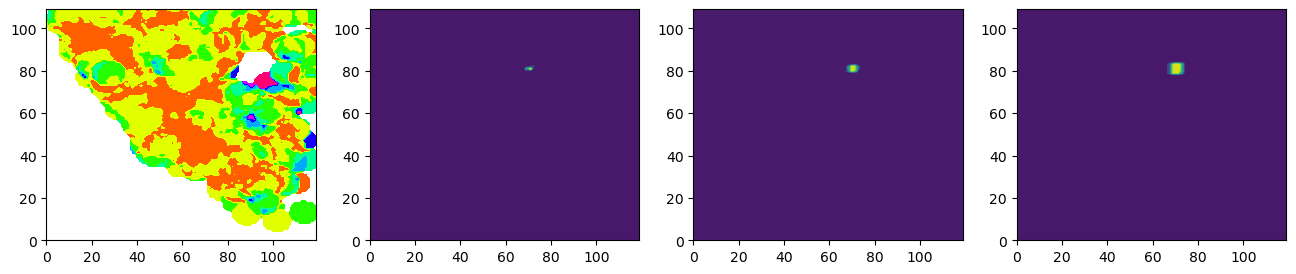

1082
2020-06-04 01:32:11+00:00


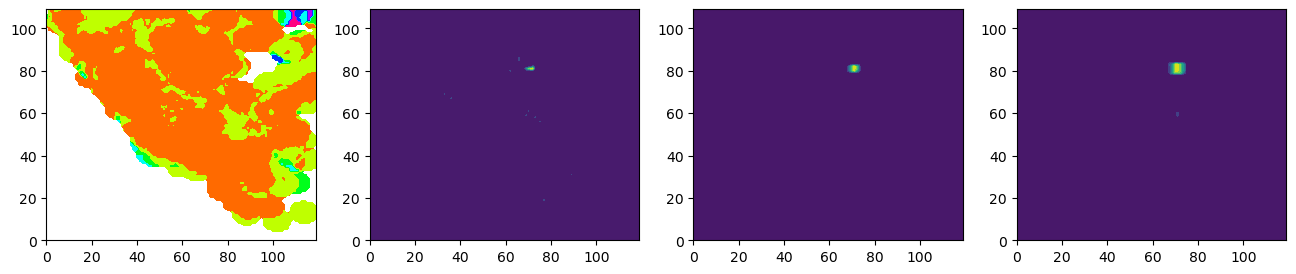

1098
2020-06-24 17:40:49+00:00


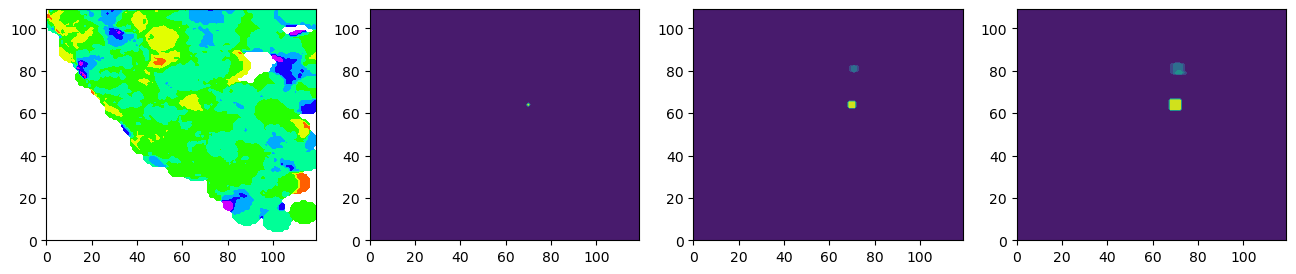

1097
2020-08-17 15:30:33+00:00


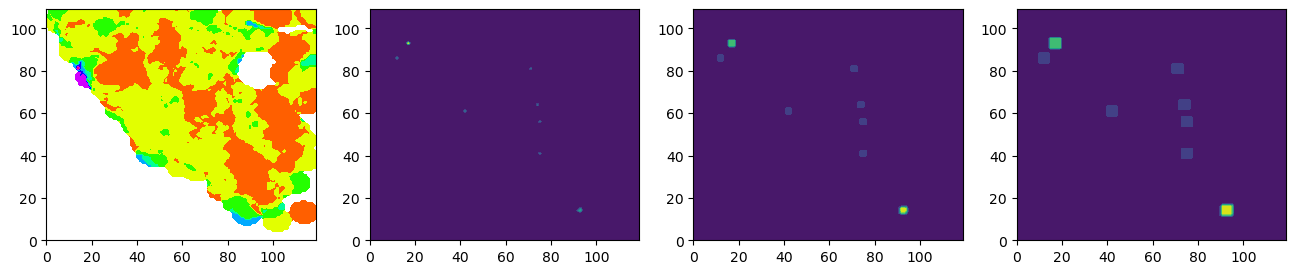

1095
2020-11-13 09:13:51+00:00


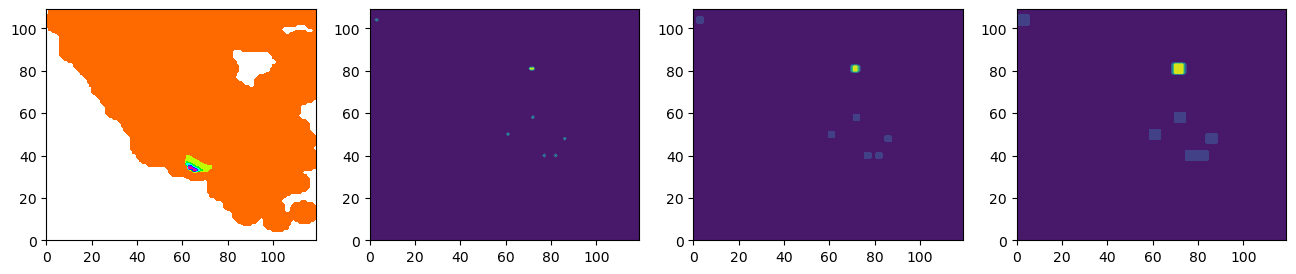

1012
2020-11-13 09:14:21+00:00


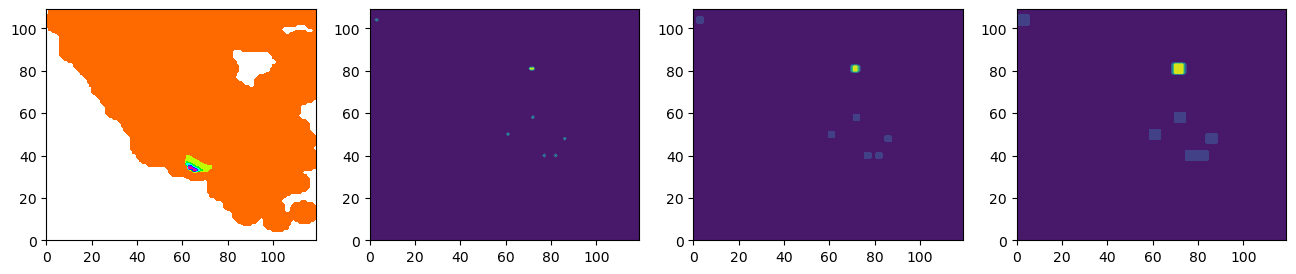

1012
2020-12-01 23:32:56+00:00


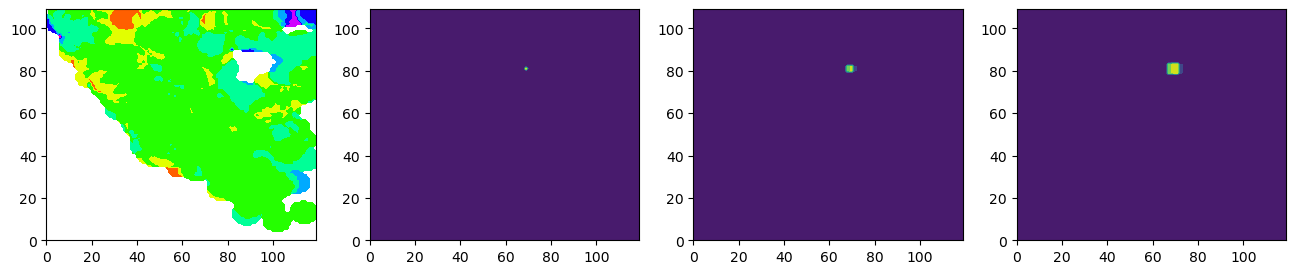

1059
2021-06-05 17:55:58+00:00


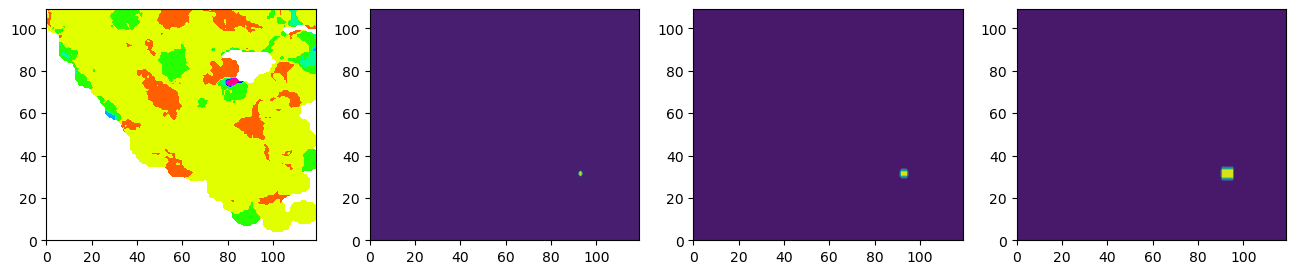

1067
2021-07-08 22:49:48+00:00


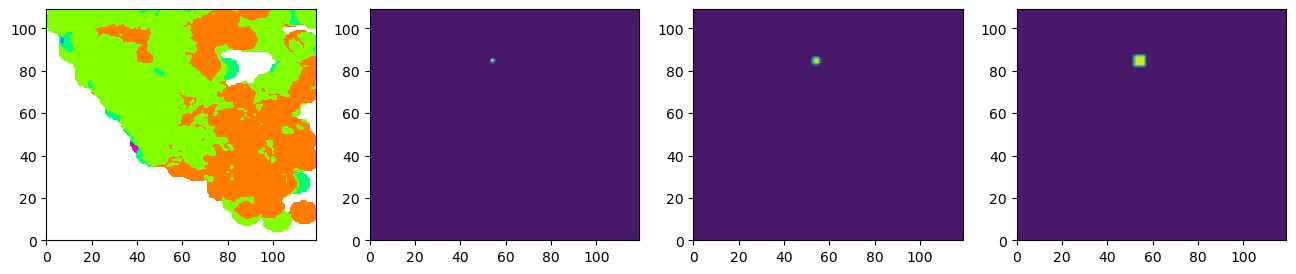

1042
2021-07-08 22:50:14+00:00


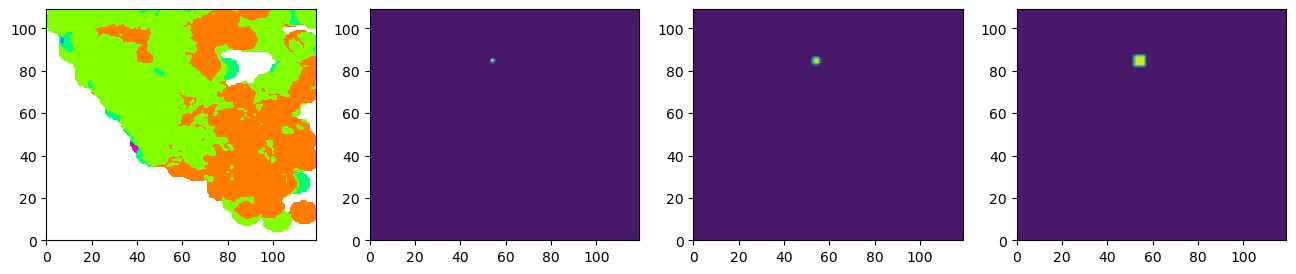

1042
2021-07-18 06:46:12+00:00


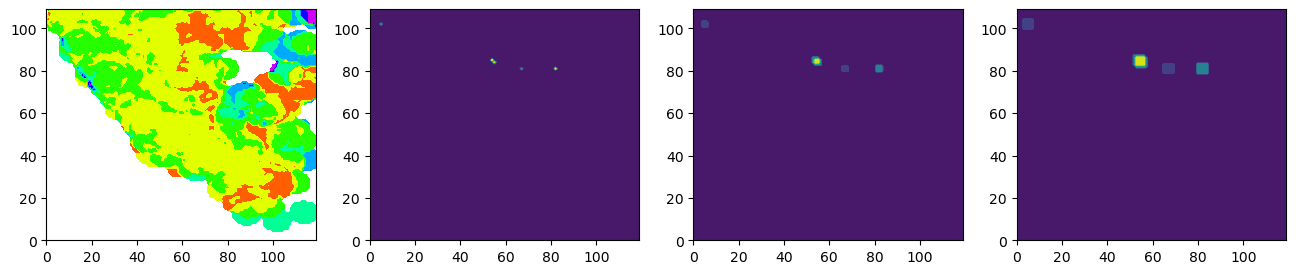

1043
2021-12-20 20:10:20+00:00


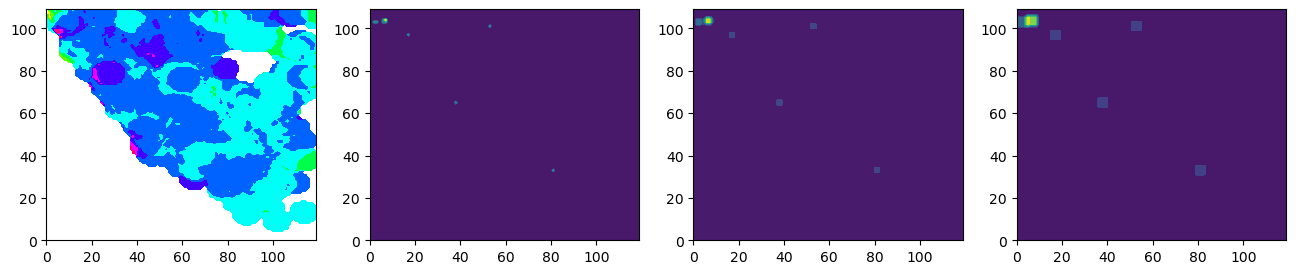

1000
2021-12-20 20:10:31+00:00


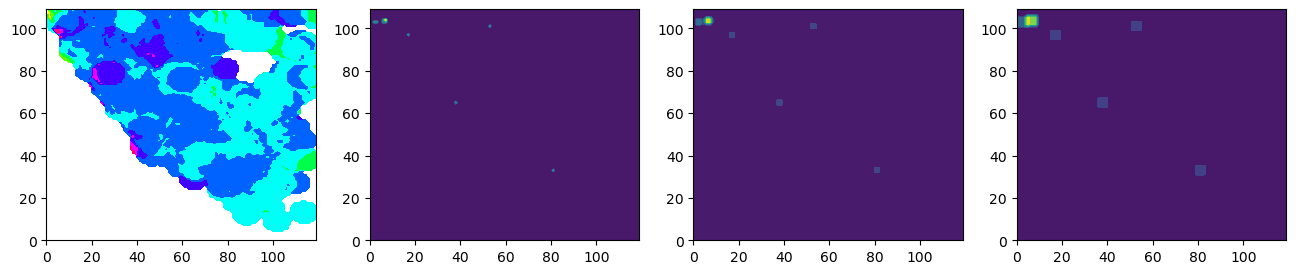

1000
2022-01-06 00:28:07+00:00


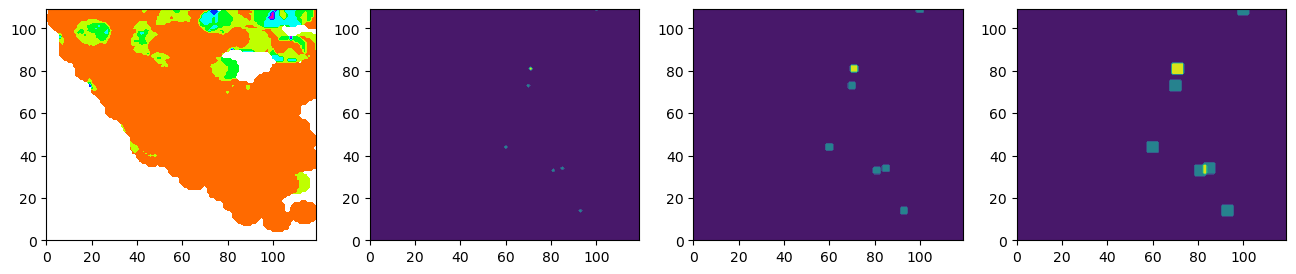

997
2022-06-18 04:51:29+00:00


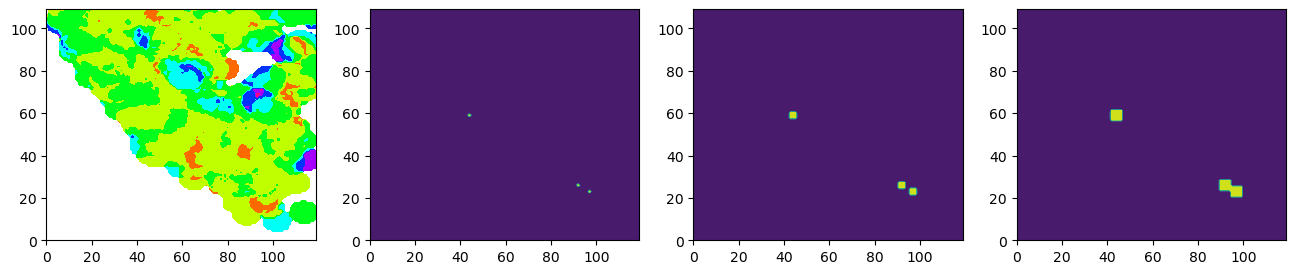

1060
2022-06-18 05:00:45+00:00


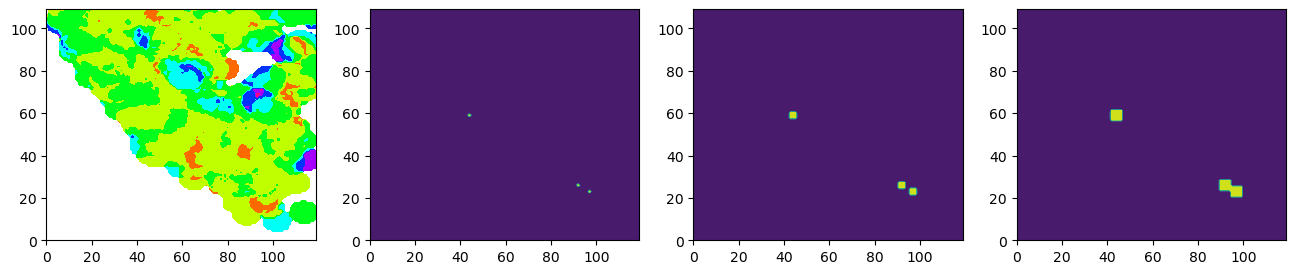

1060
2022-06-18 05:03:14+00:00


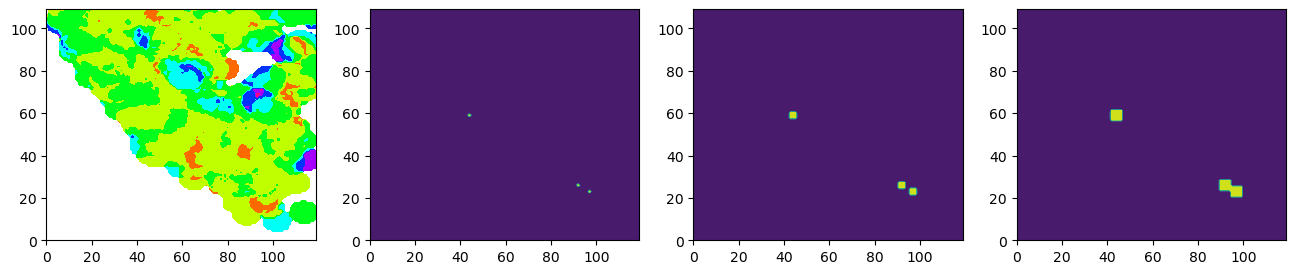

1060
2022-10-25 18:42:02+00:00


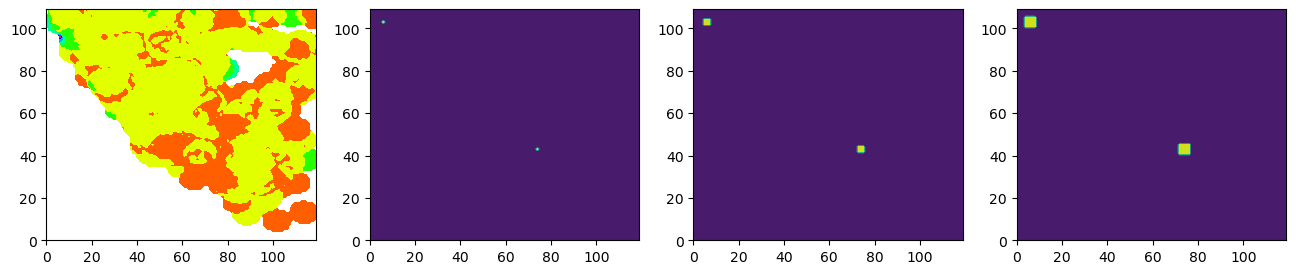

1013
2022-11-22 16:39:05+00:00


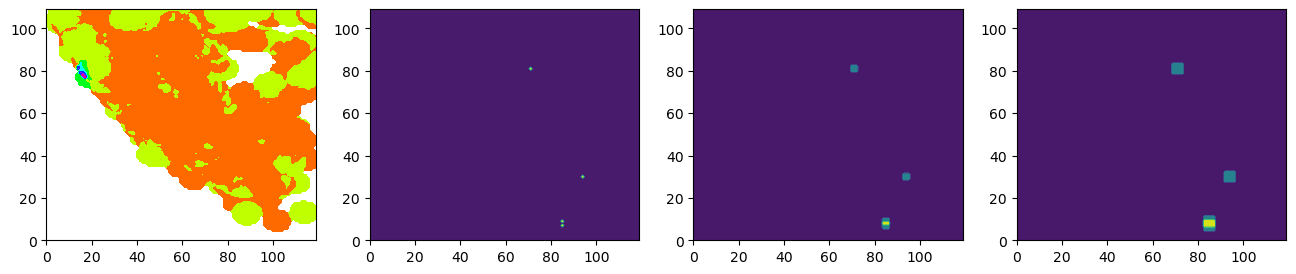

978
2022-12-20 10:34:24+00:00


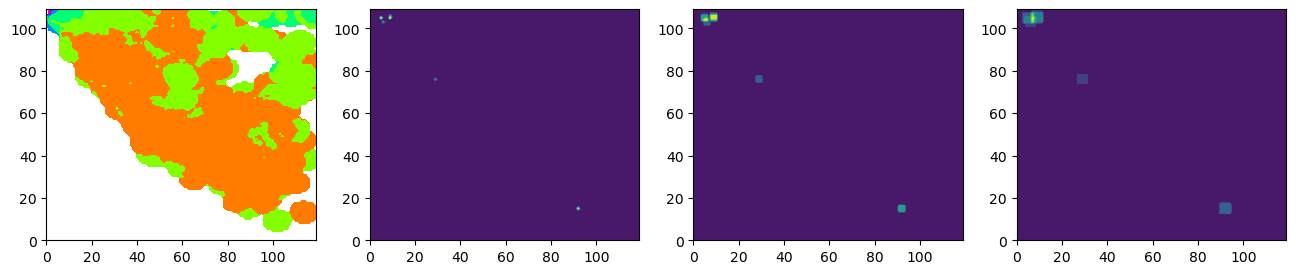

965
2023-01-01 18:35:04+00:00


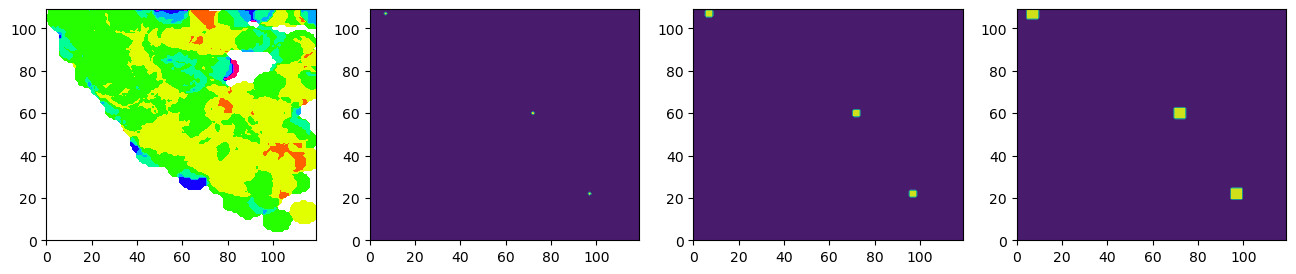

944
2023-05-11 23:19:41+00:00


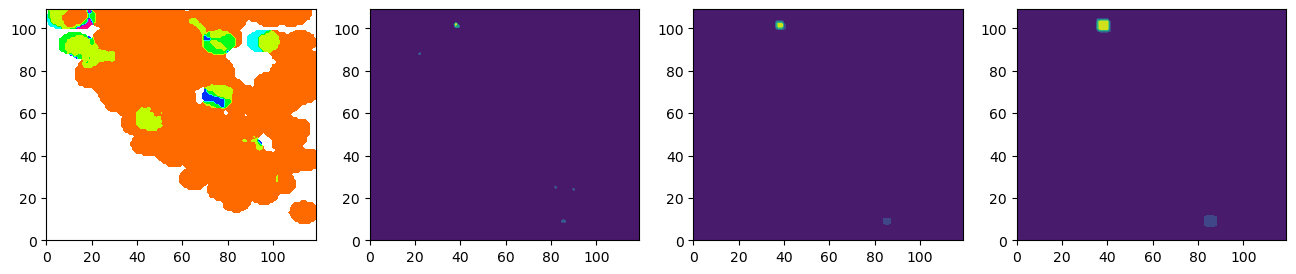

513
2023-05-12 10:18:41+00:00


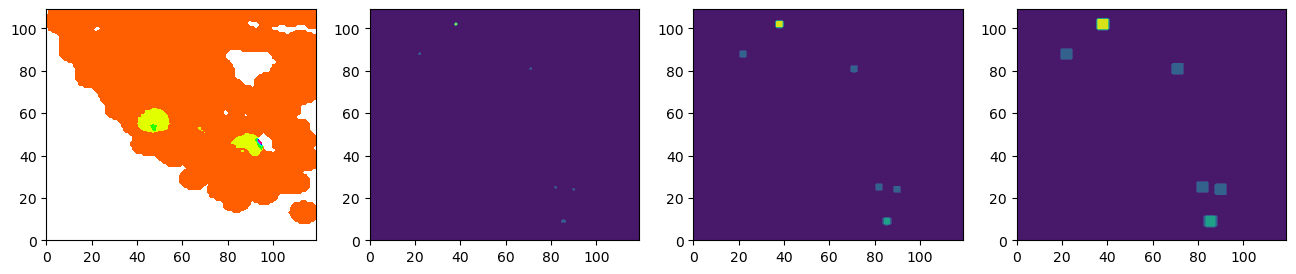

594
2023-08-20 21:41:00+00:00


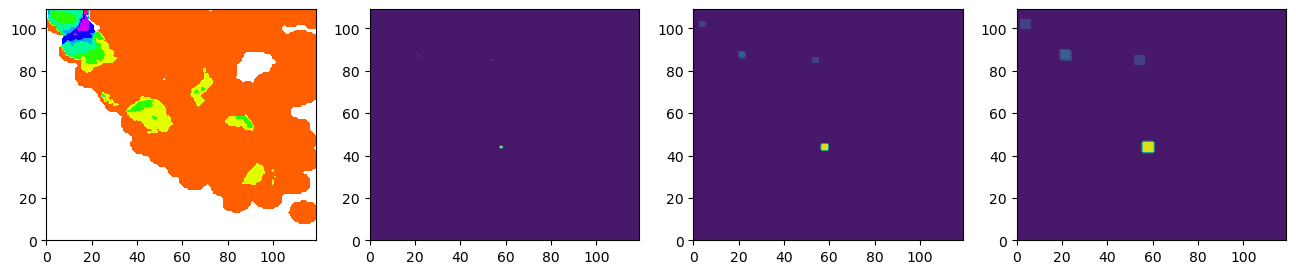

613
2023-09-08 17:24:38+00:00


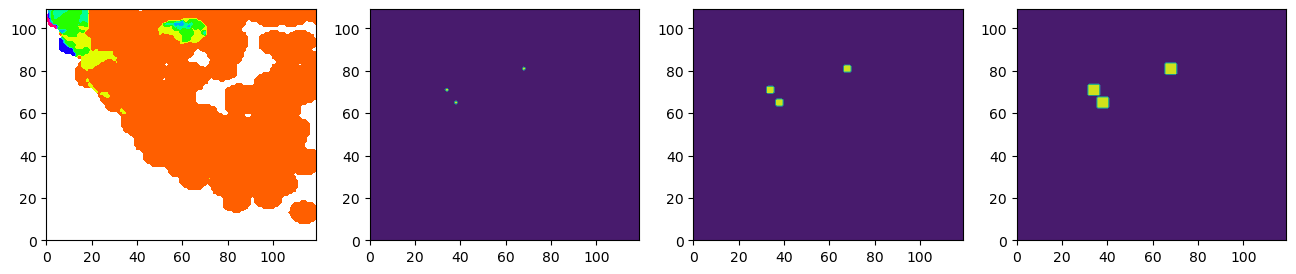

611
japan
2003-05-26 09:24:33+00:00


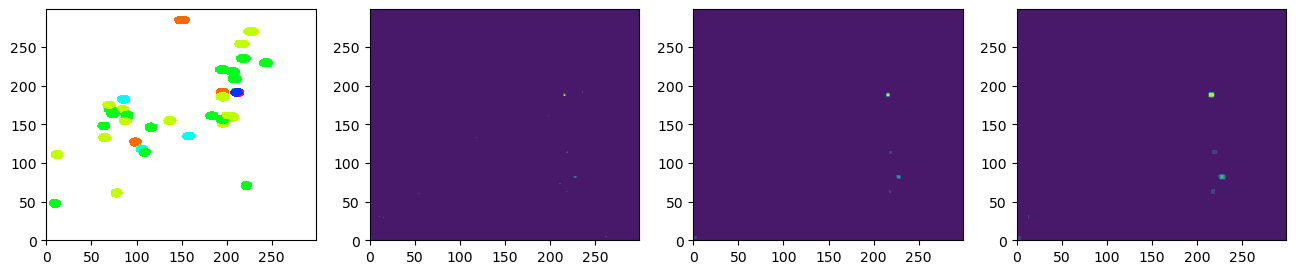

43
2003-07-27 06:25:31+00:00


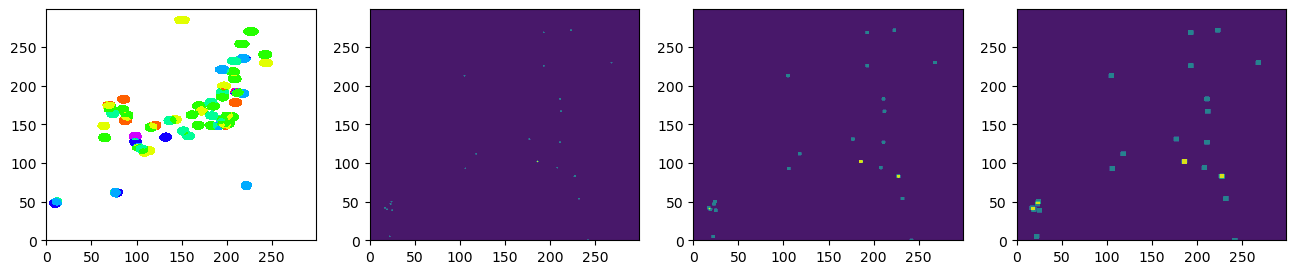

69
2003-09-25 19:50:07+00:00


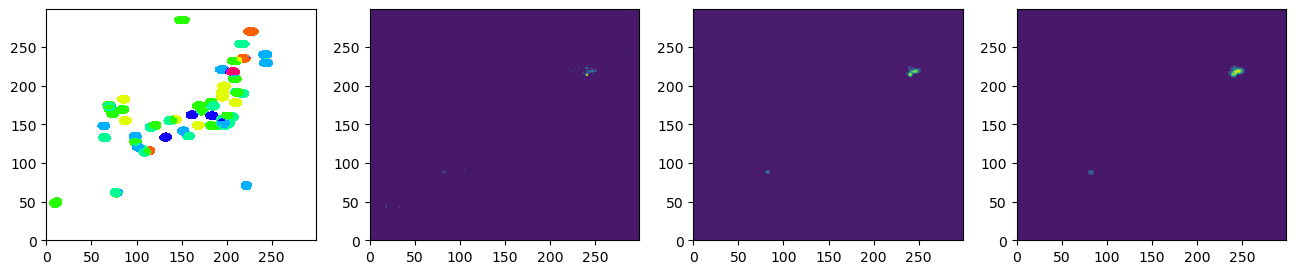

67
2003-09-25 21:07:59+00:00


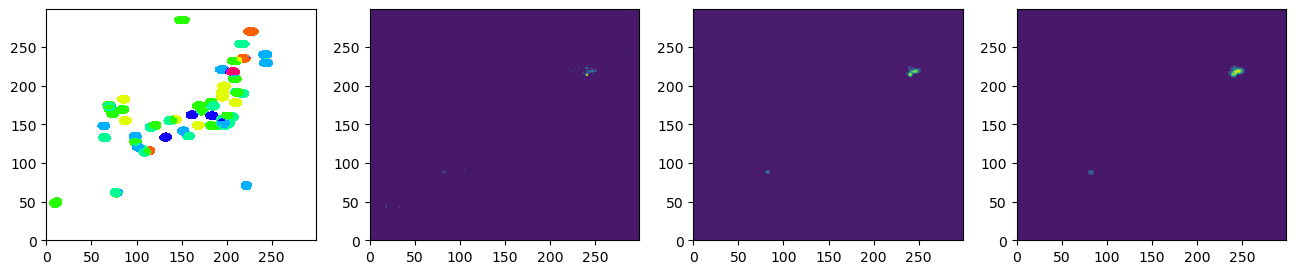

67
2003-09-29 02:36:55+00:00


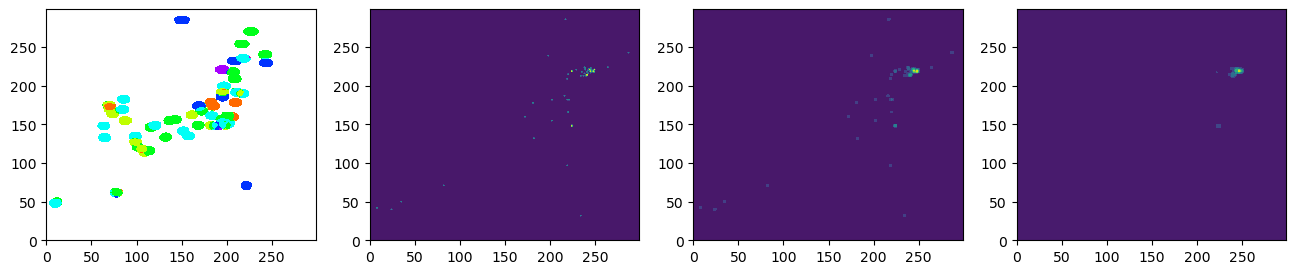

68
2003-10-08 09:06:56+00:00


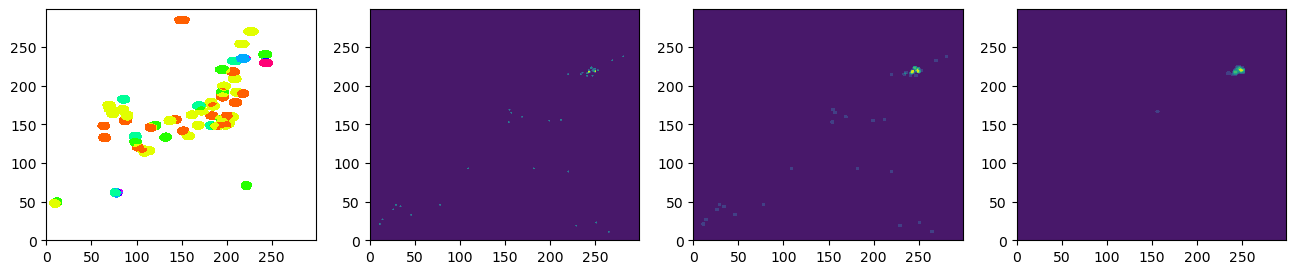

69
2003-10-31 01:06:30+00:00


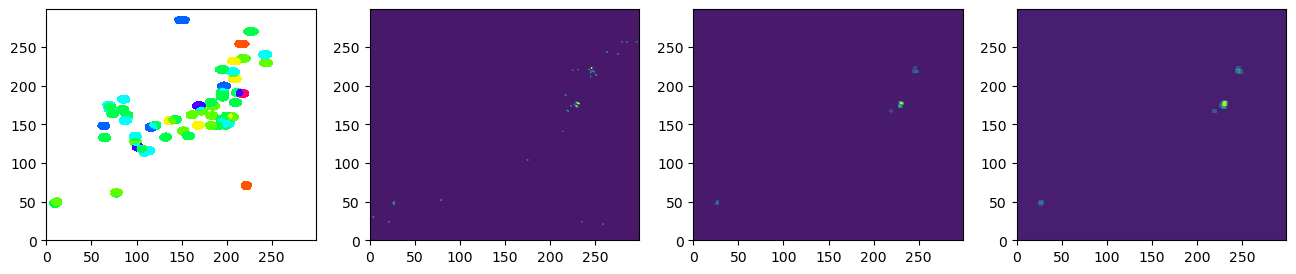

69
2003-12-10 04:38:14+00:00


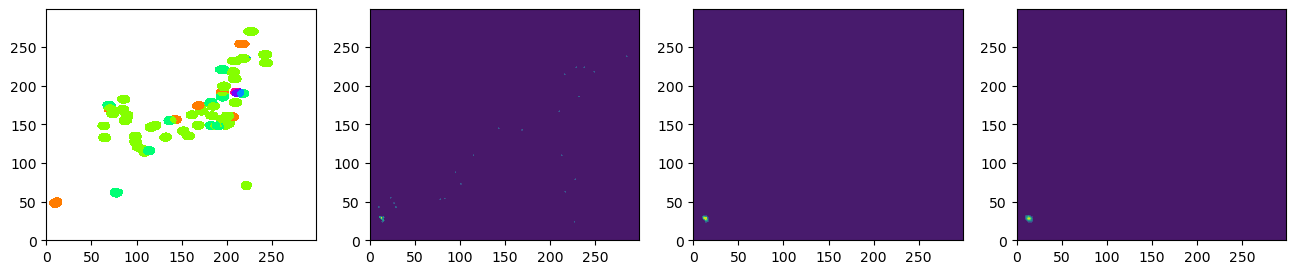

68
2004-09-05 10:07:07+00:00


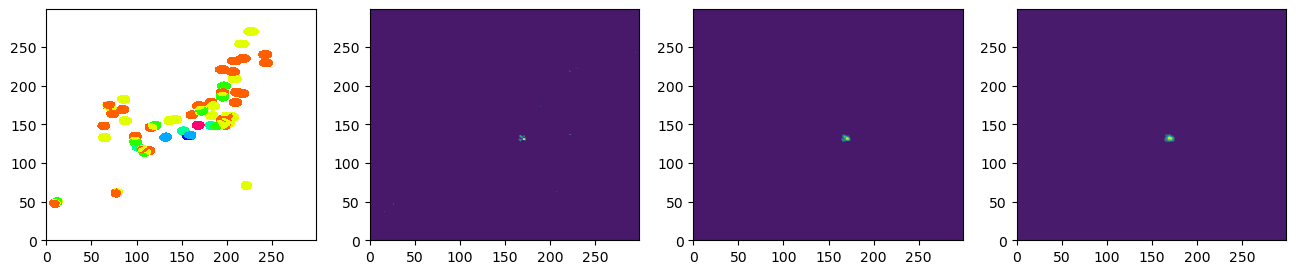

67
2004-09-05 14:57:17+00:00


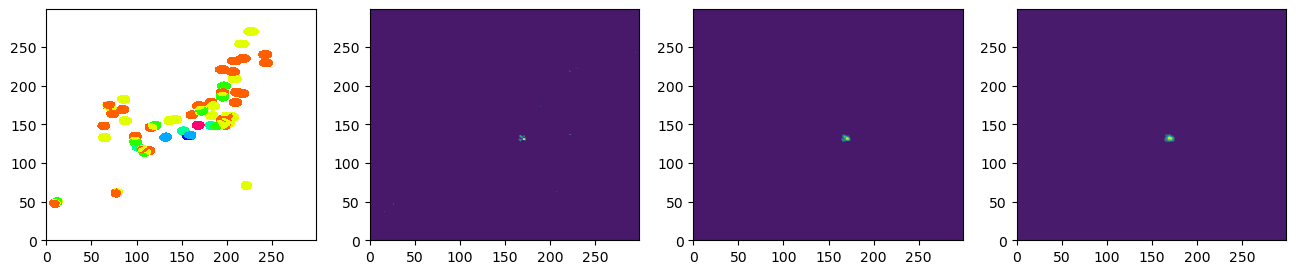

67
2004-09-06 23:29:34+00:00


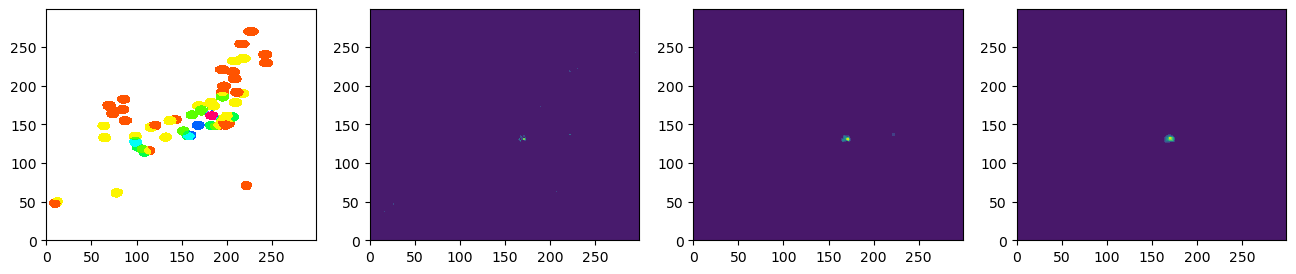

66
2004-10-15 04:08:49+00:00


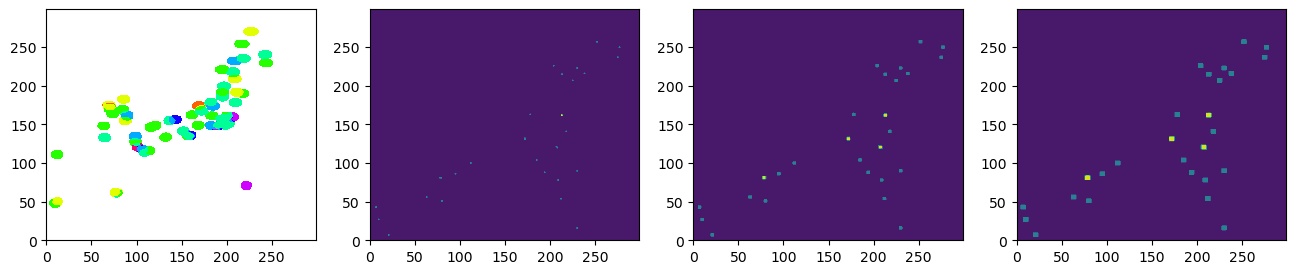

70
2004-10-23 08:55:58+00:00


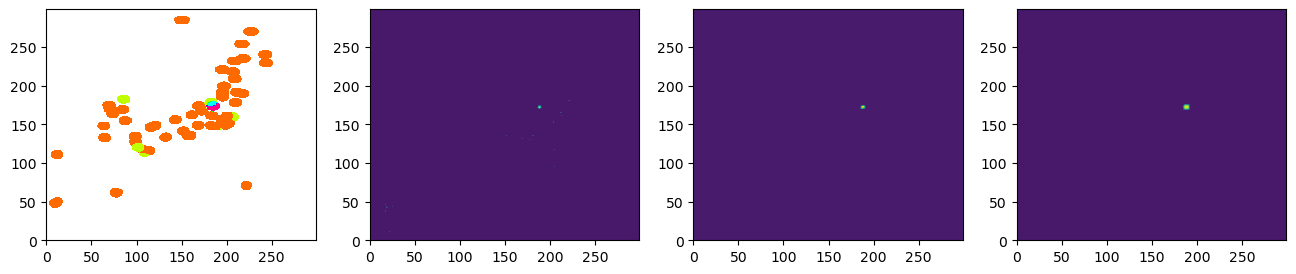

70
2004-11-28 18:32:12+00:00


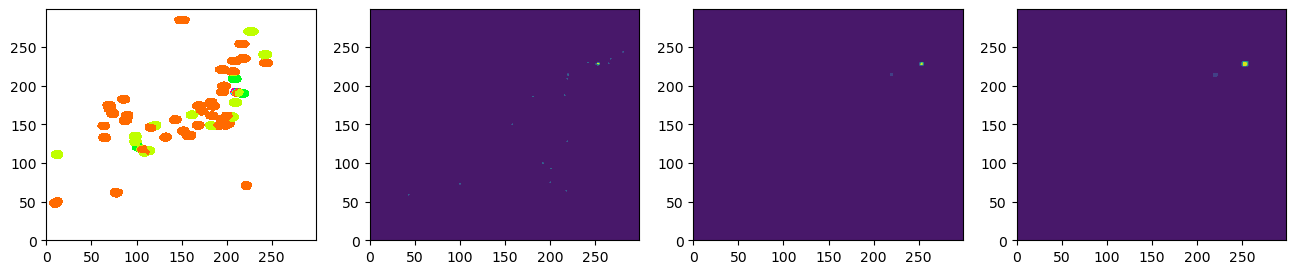

67
2004-12-06 14:15:10+00:00


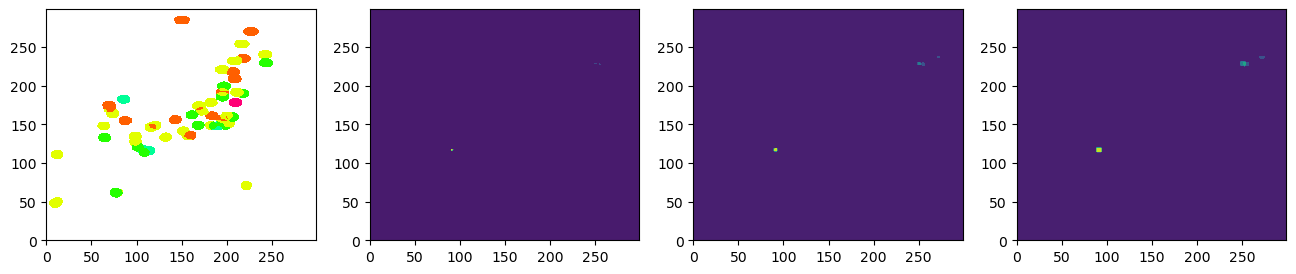

68
2005-01-19 06:11:32+00:00


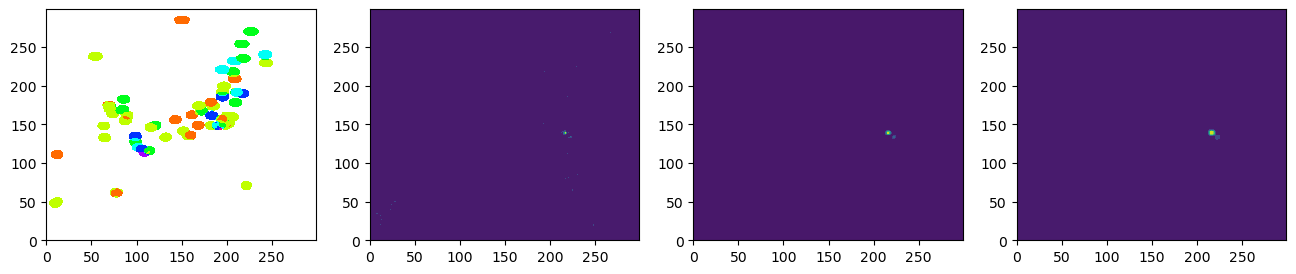

71
2005-03-20 01:53:41+00:00


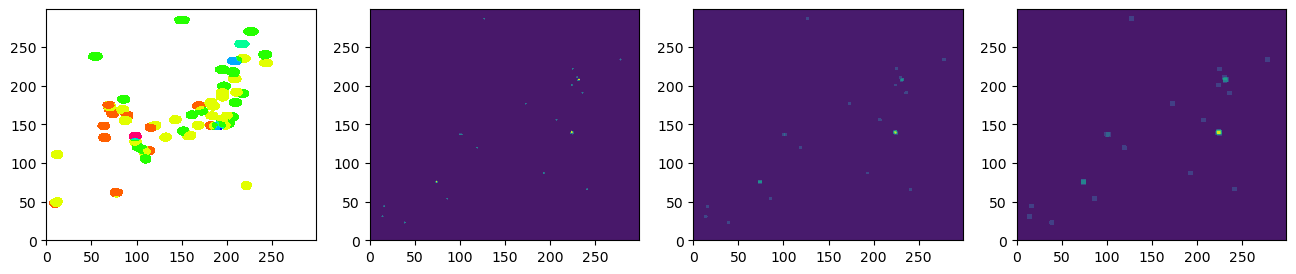

73
2005-08-16 02:46:26+00:00


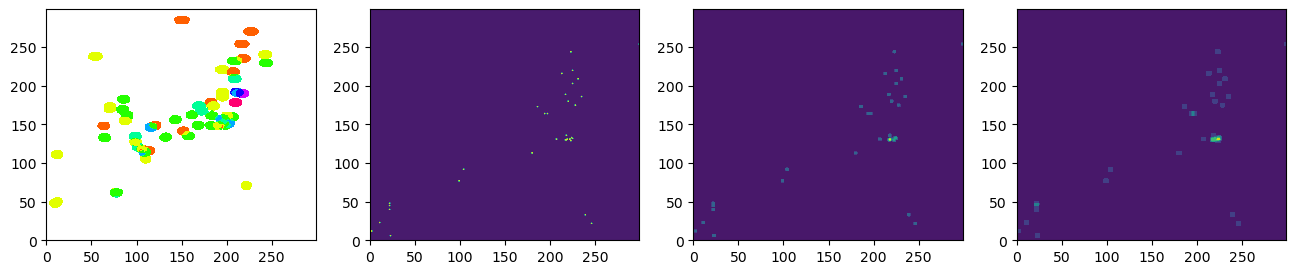

67
2005-11-14 21:38:50+00:00


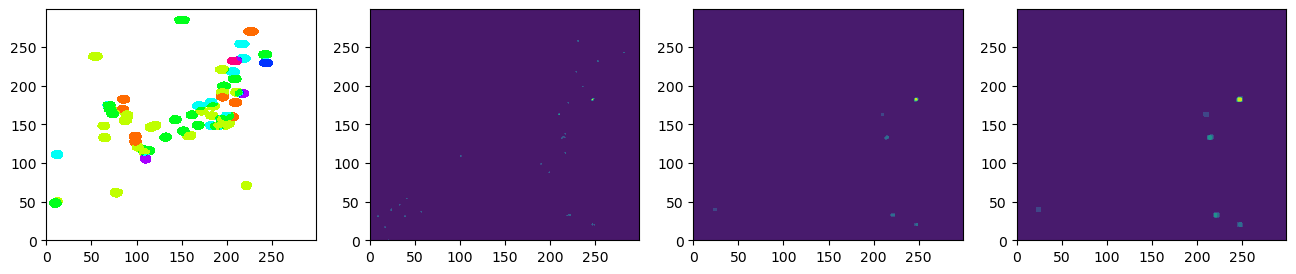

73
2005-12-02 13:13:09+00:00


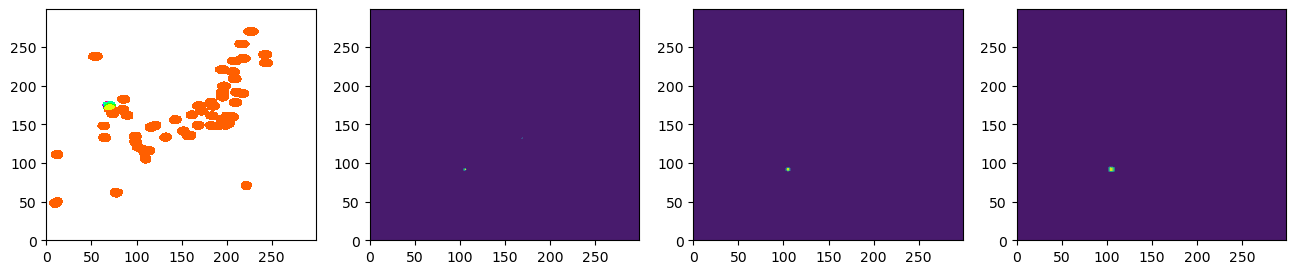

72
2006-12-26 12:26:21+00:00


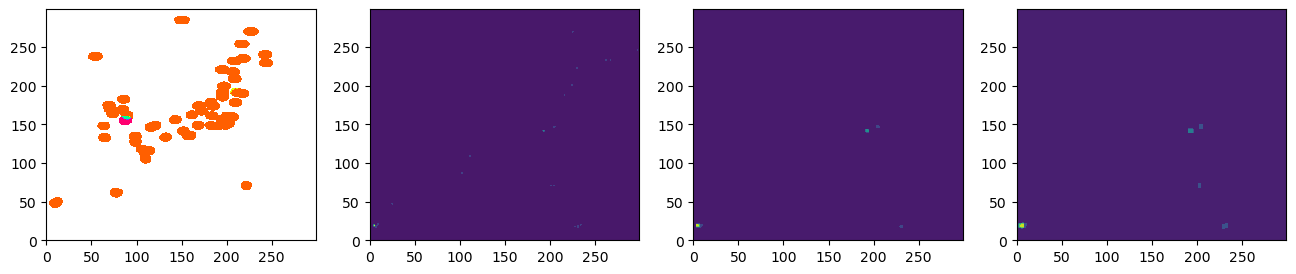

72
2006-12-26 12:34:17+00:00


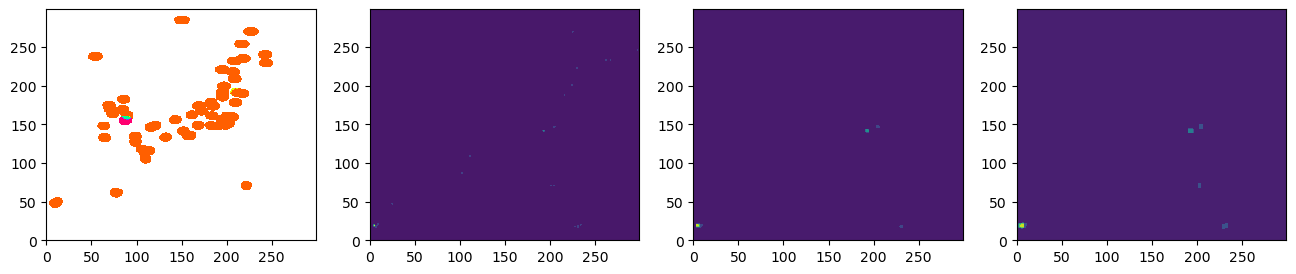

72
2007-01-30 21:37:50+00:00


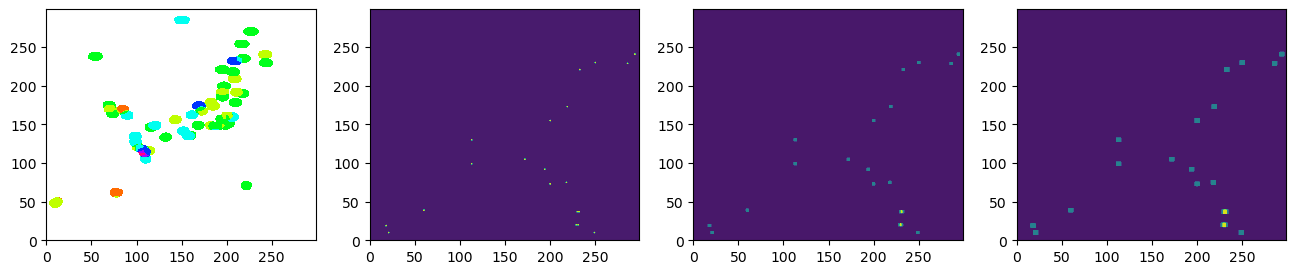

66
2007-03-25 00:41:57+00:00


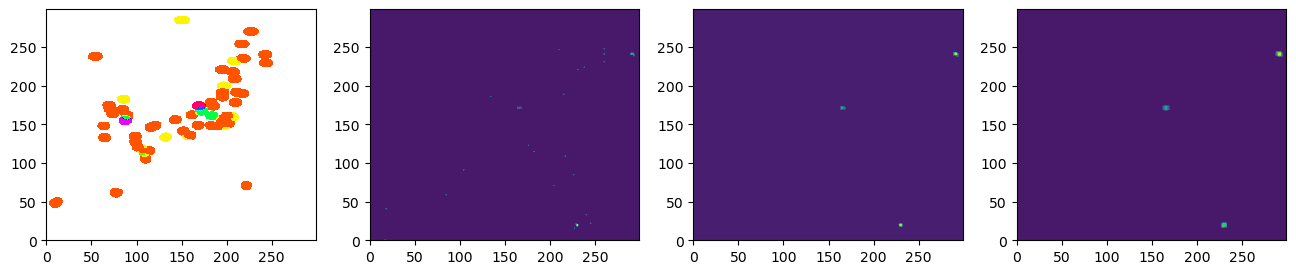

71
2007-07-16 01:13:21+00:00


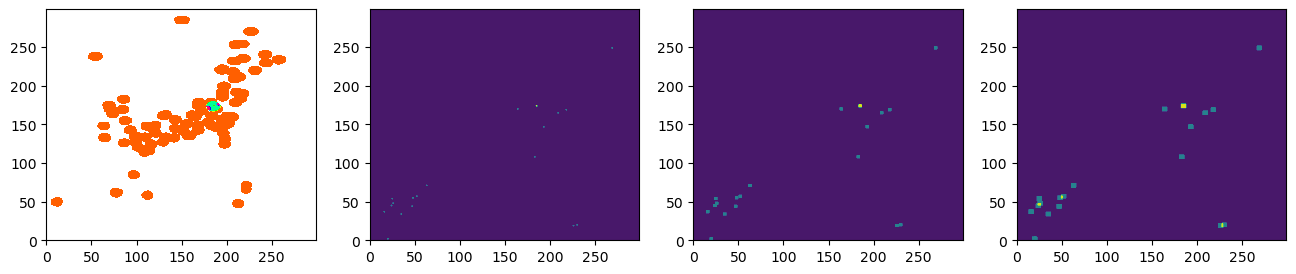

103
2007-07-16 14:17:37+00:00


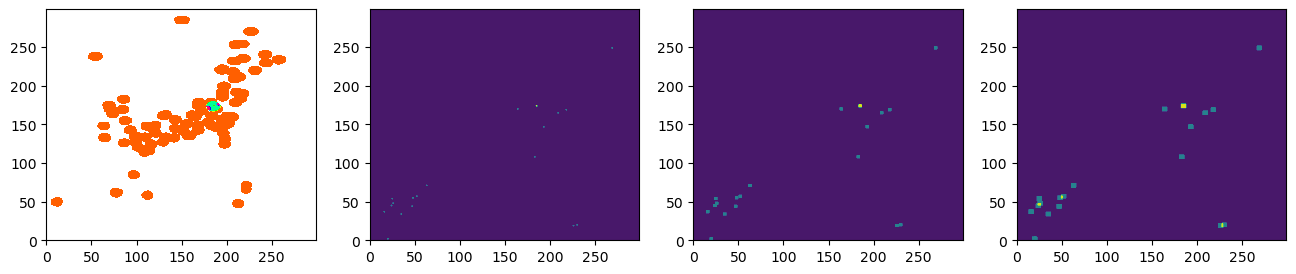

103
2007-09-28 13:38:57+00:00


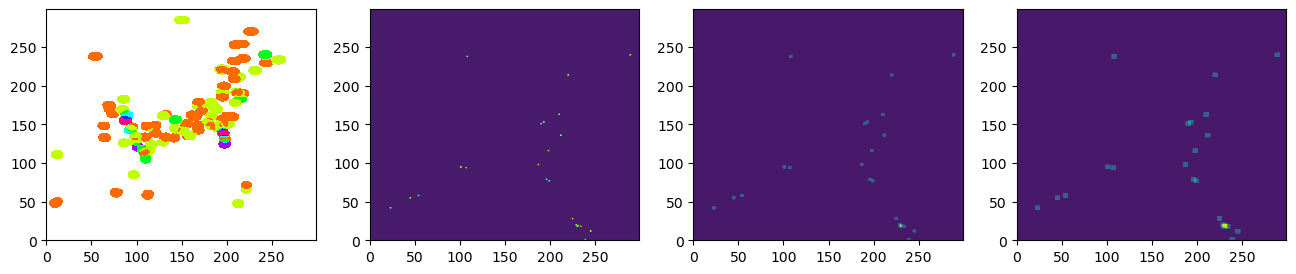

113
2008-05-07 16:45:21+00:00


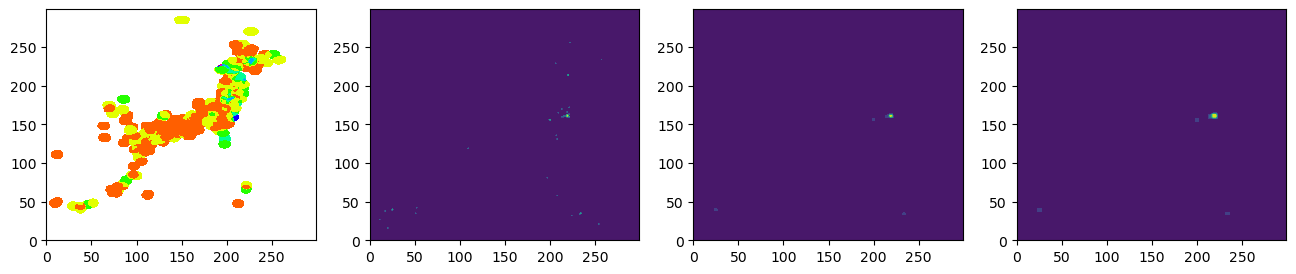

201
2008-06-13 23:43:46+00:00


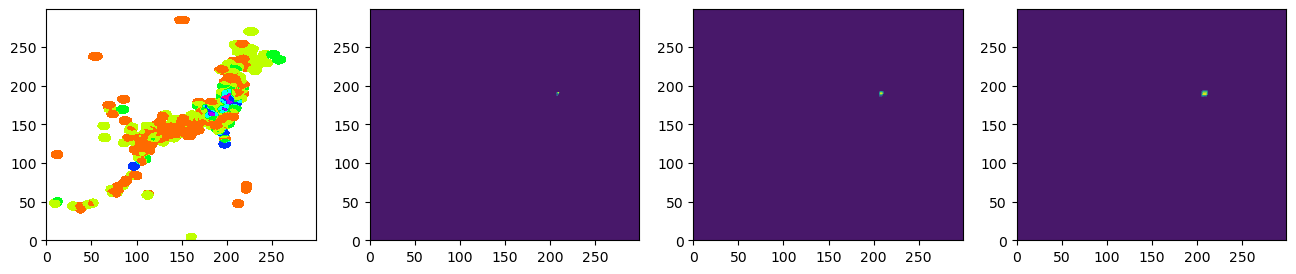

205
2008-07-19 02:39:29+00:00


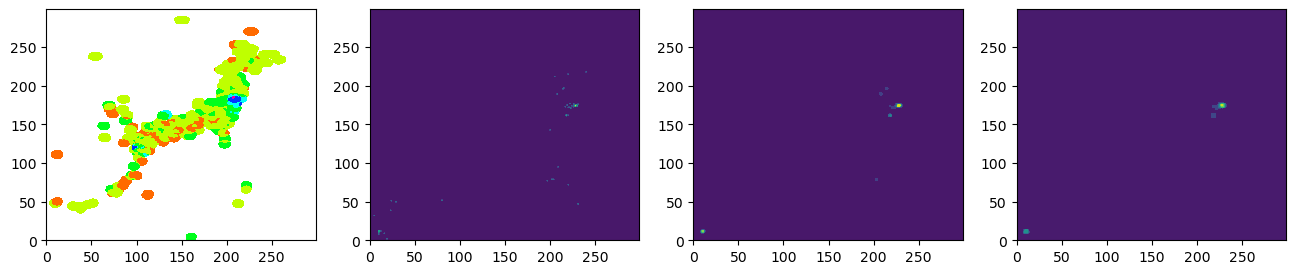

204
2008-07-23 15:26:20+00:00


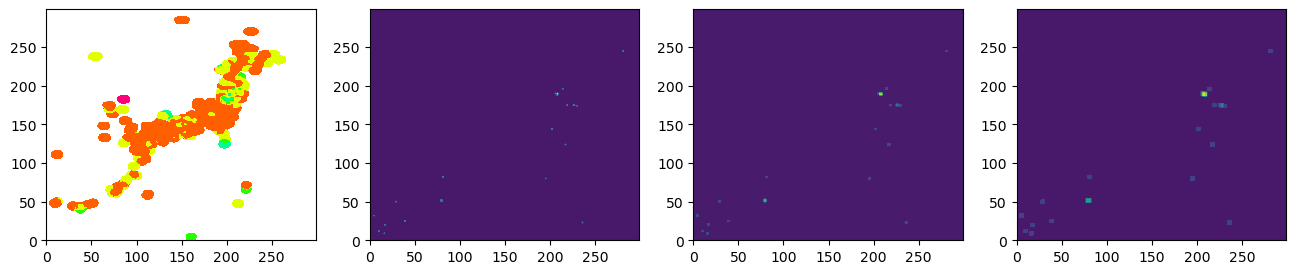

204
2008-09-11 00:20:52+00:00


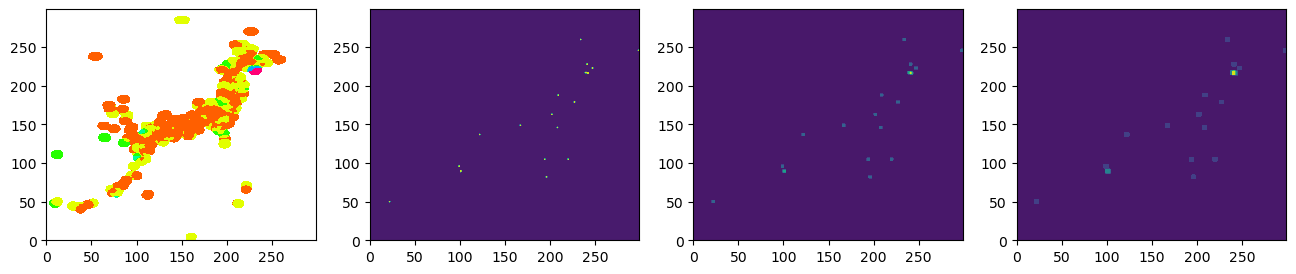

206
2009-08-09 10:55:56+00:00


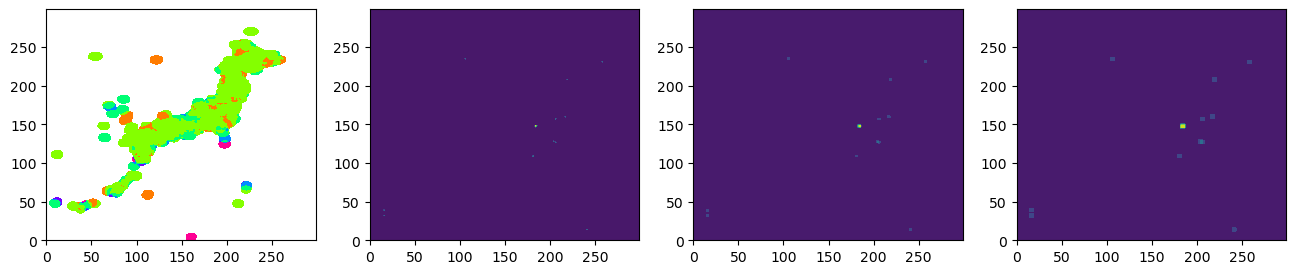

1296
2009-08-12 22:48:52+00:00


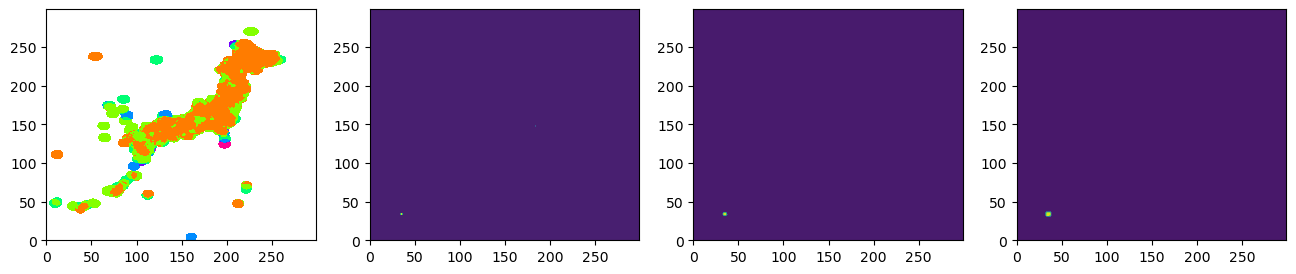

1295
2009-08-17 00:05:48+00:00


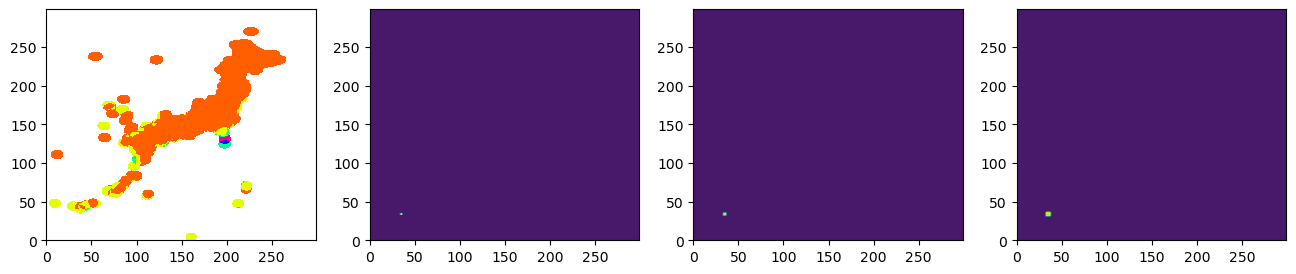

1292
2009-10-30 07:03:39+00:00


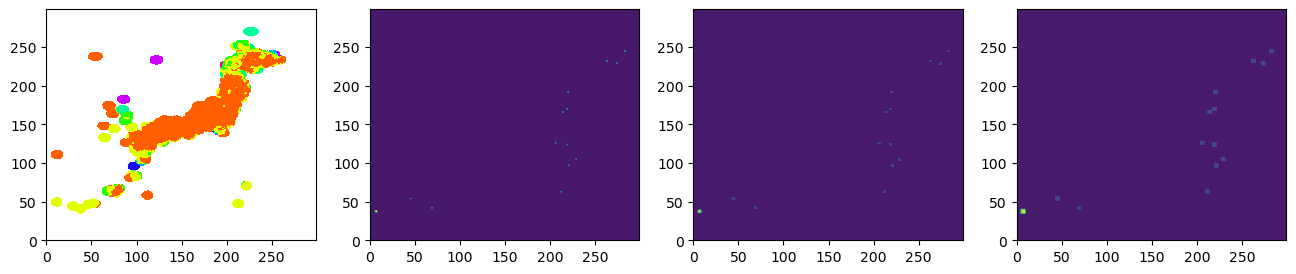

757
2010-02-18 01:13:18+00:00


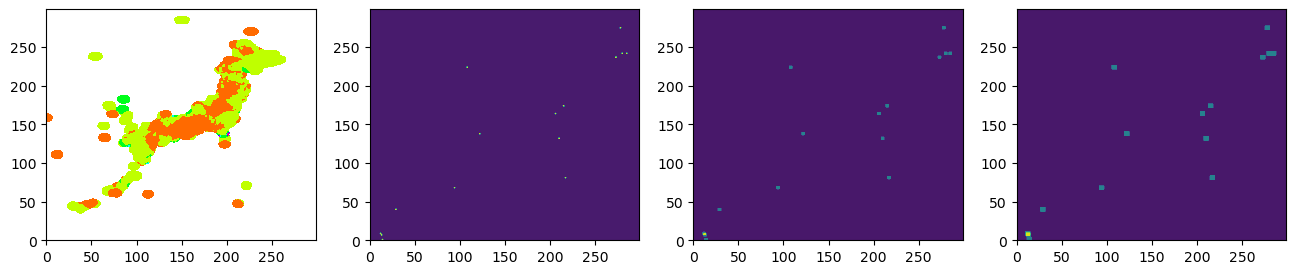

1279
2010-02-26 20:31:26+00:00


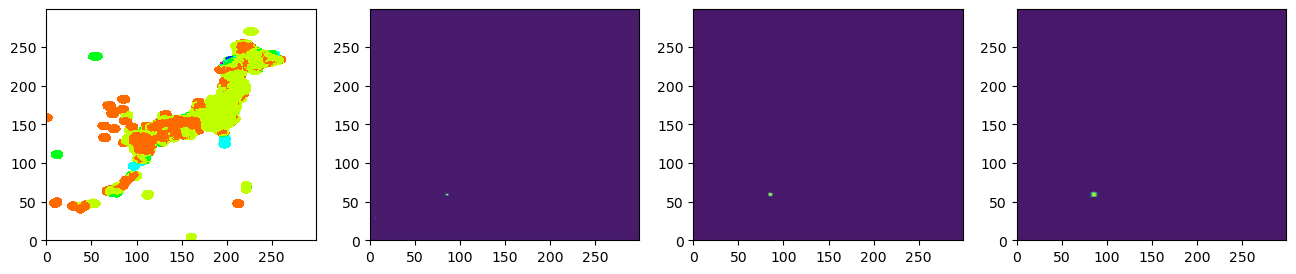

1281
2010-03-14 08:08:05+00:00


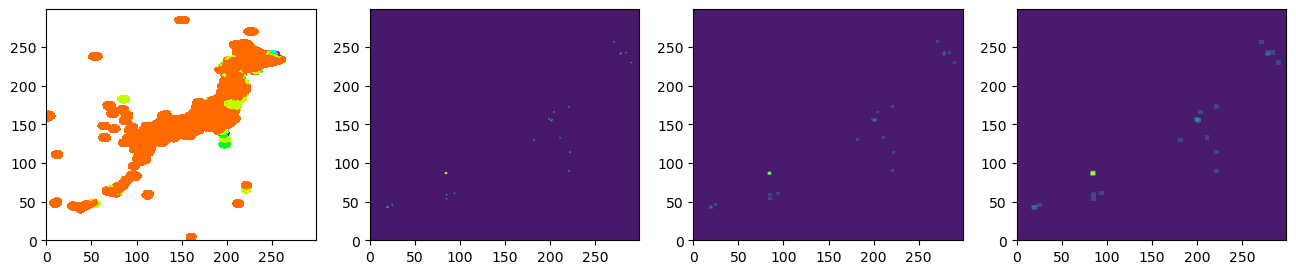

1282
2010-04-26 02:59:52+00:00


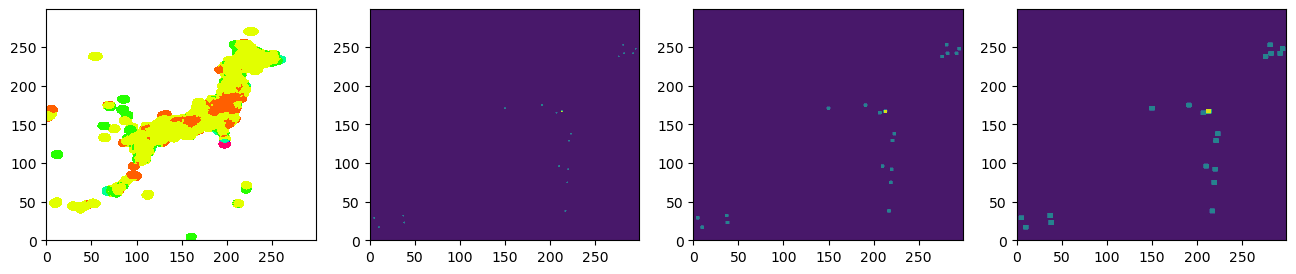

1293
2010-11-30 03:24:41+00:00


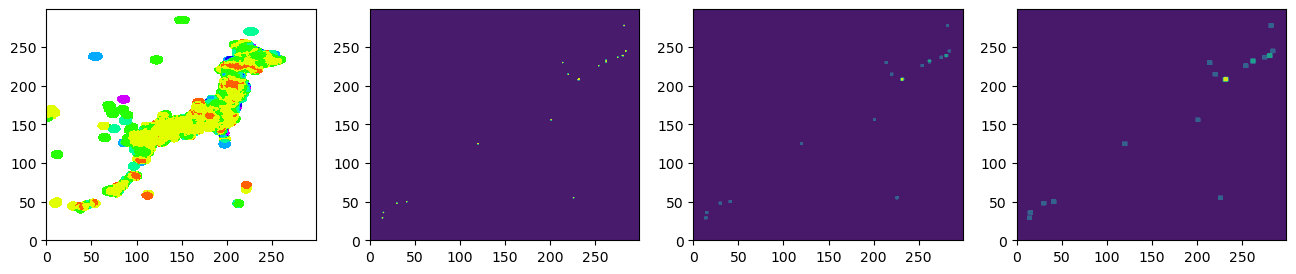

1282
2010-12-21 17:19:41+00:00


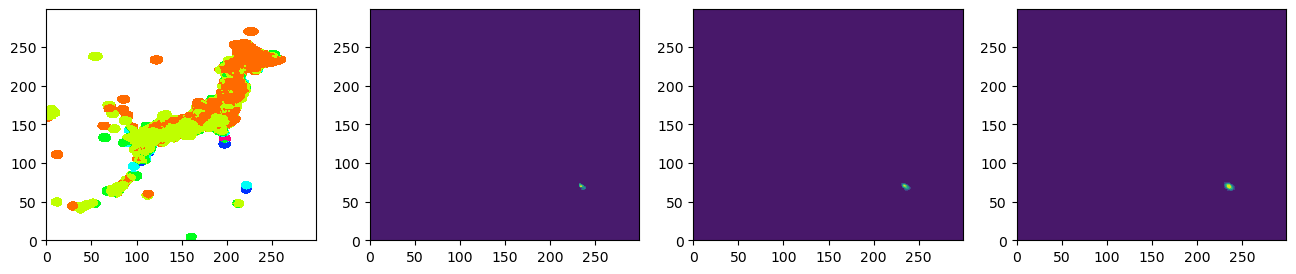

1307
2011-01-12 21:32:54+00:00


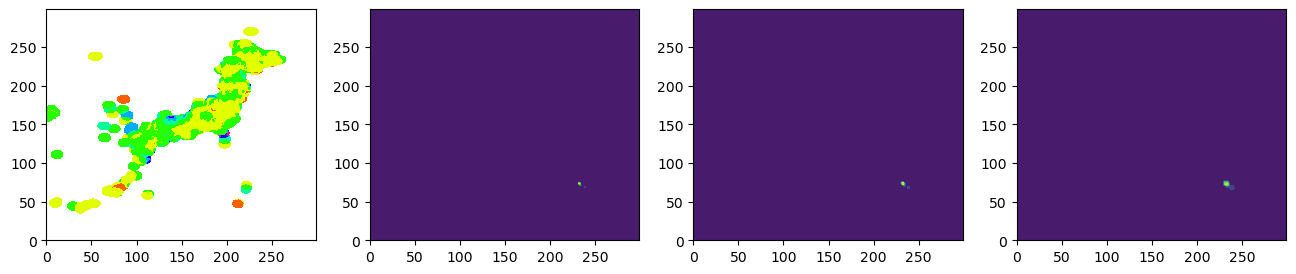

1307
2011-03-09 02:45:19+00:00


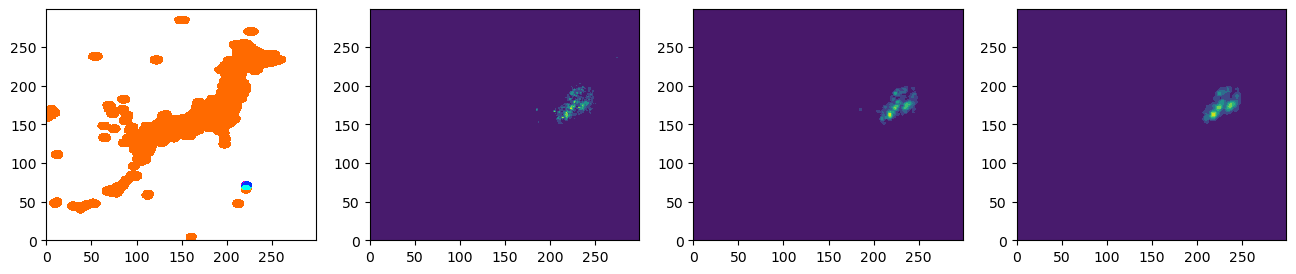

1308
2011-03-09 21:24:01+00:00


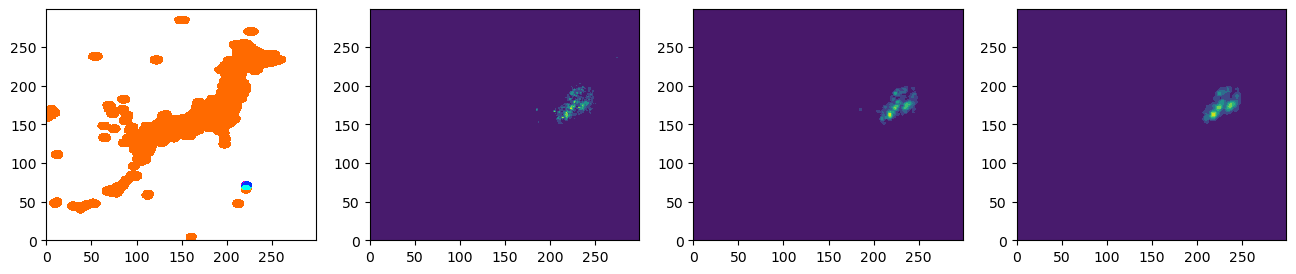

1308
2011-03-11 05:46:23+00:00


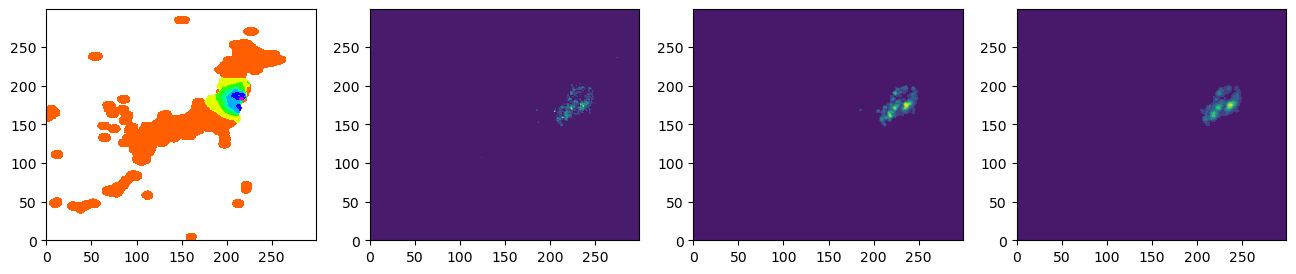

1292
2011-03-11 06:08:32+00:00


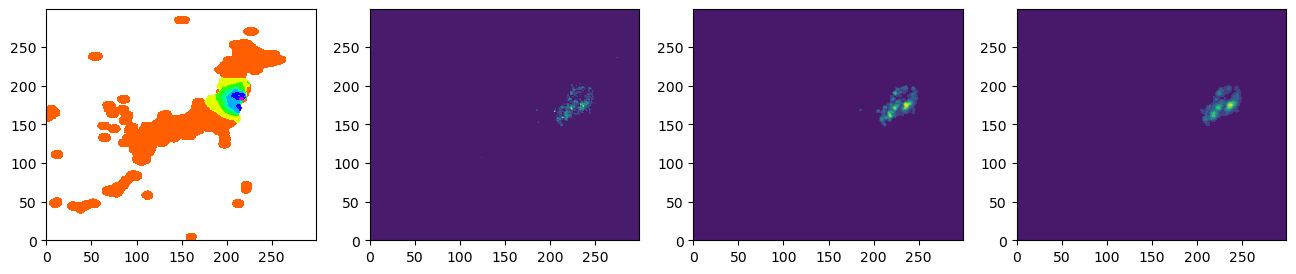

1292
2011-03-11 06:15:37+00:00


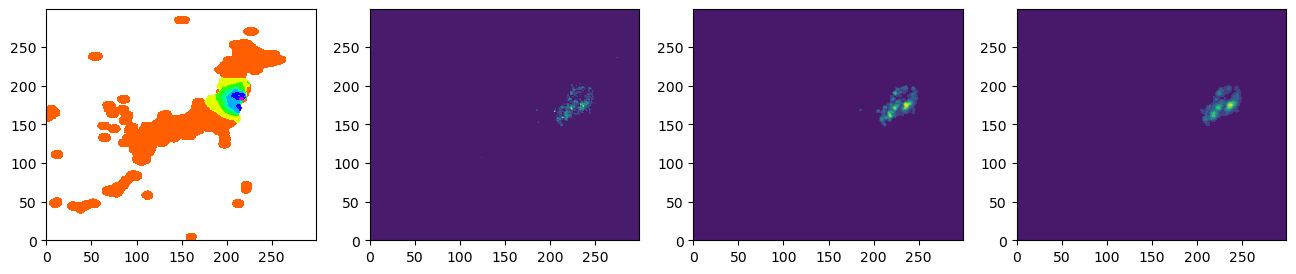

1292
2011-03-11 06:18:51+00:00


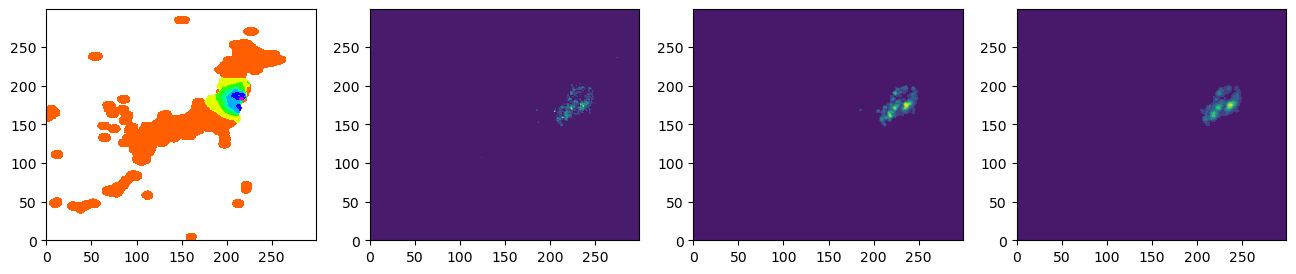

1292
2011-03-11 06:20:02+00:00


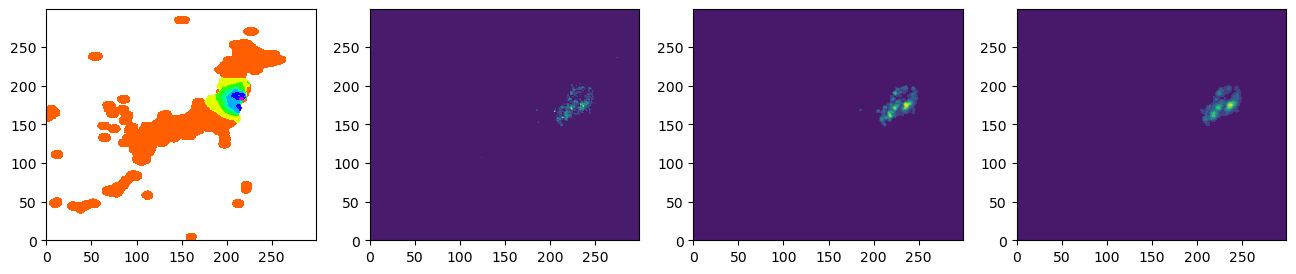

1292
2011-03-11 06:25:50+00:00


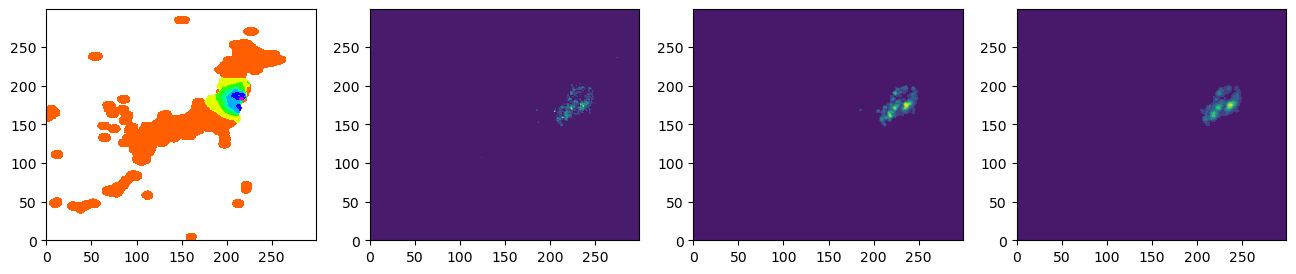

1292
2011-03-11 08:19:27+00:00


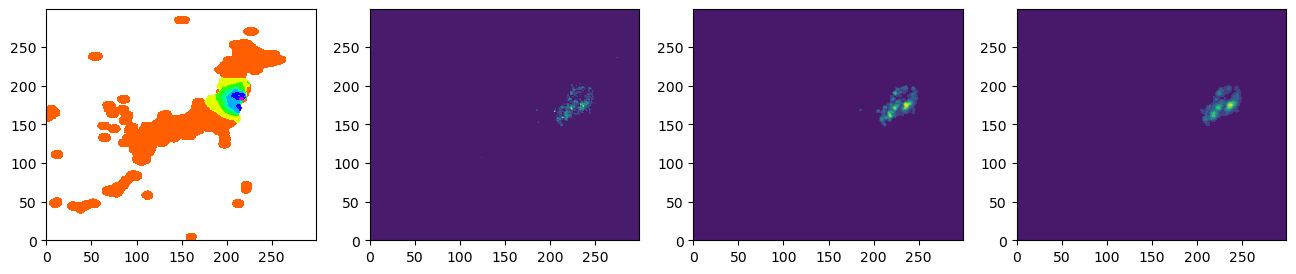

1292
2011-03-11 11:36:40+00:00


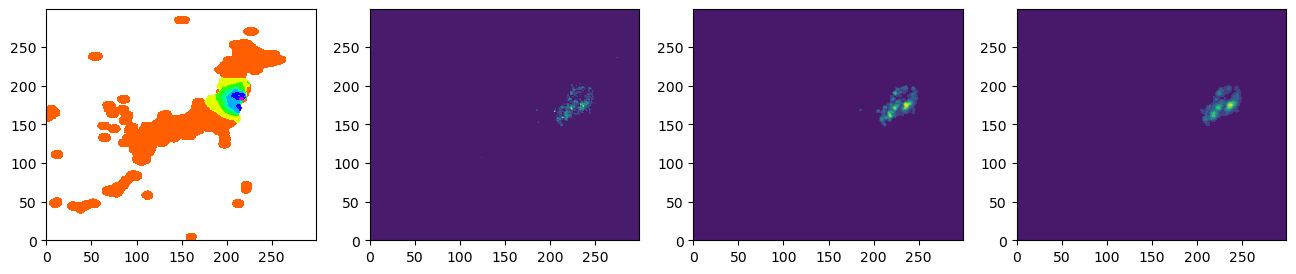

1292
2011-03-11 19:46:35+00:00


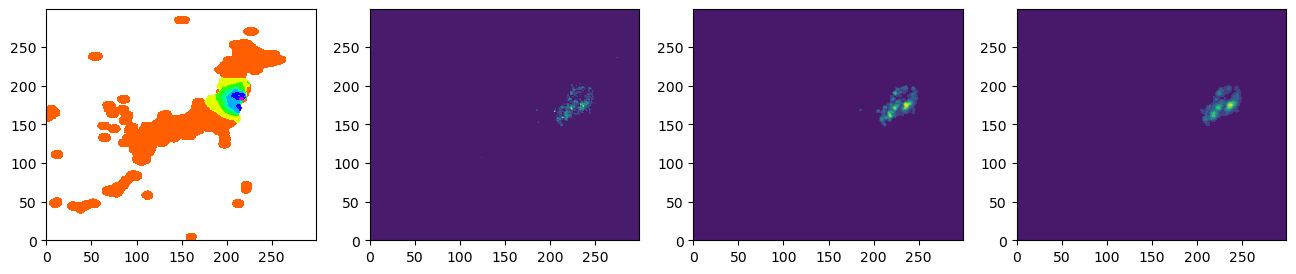

1292
2011-03-12 01:47:16+00:00


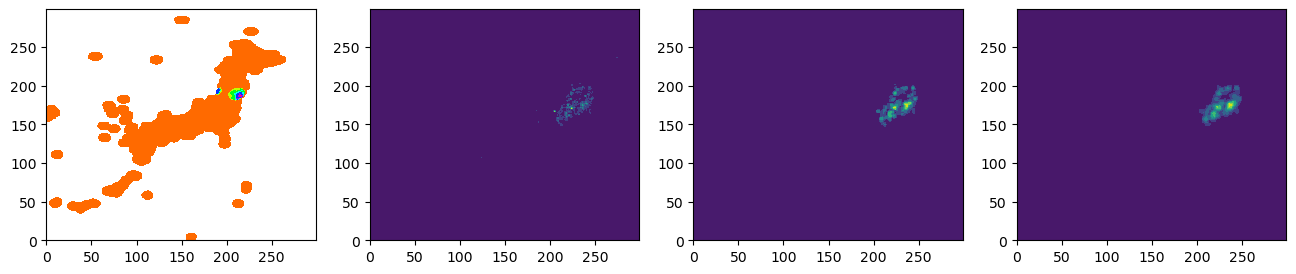

1266
2011-04-07 14:32:44+00:00


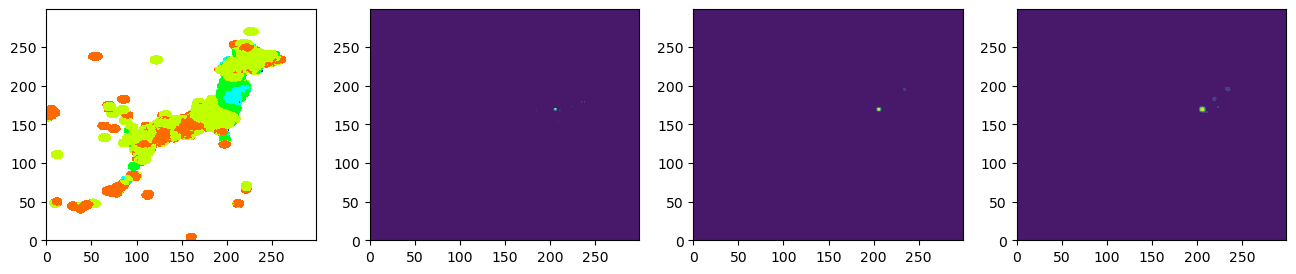

1300
2011-04-11 08:16:12+00:00


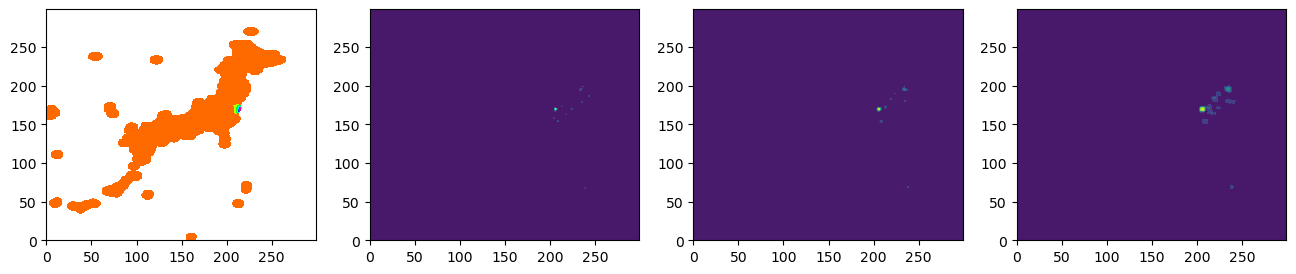

1288
2011-06-22 21:50:51+00:00


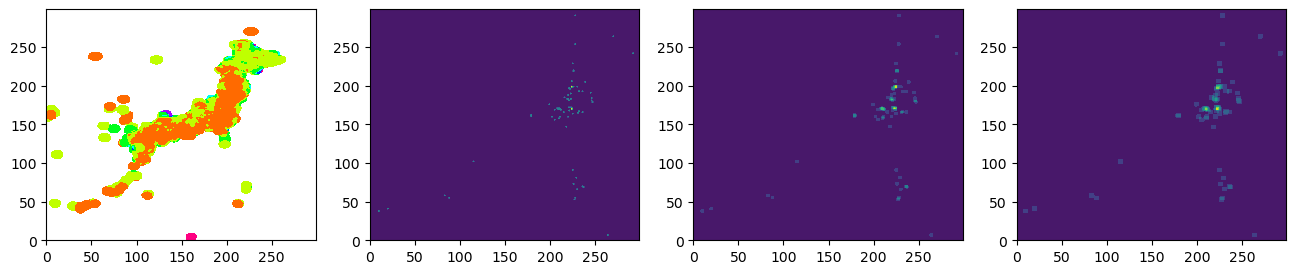

1300
2011-07-10 00:57:10+00:00


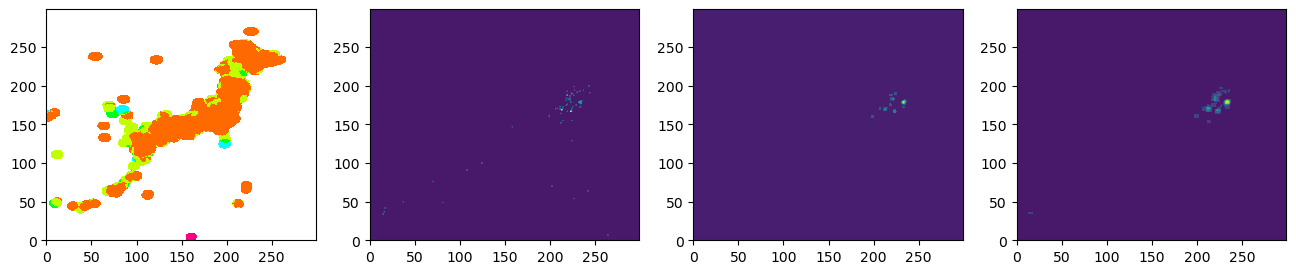

1302
2011-09-16 19:26:40+00:00


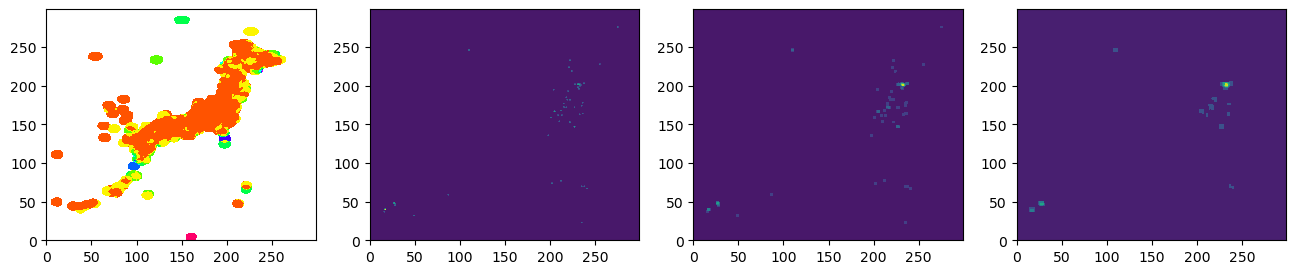

1294
2011-11-08 02:59:08+00:00


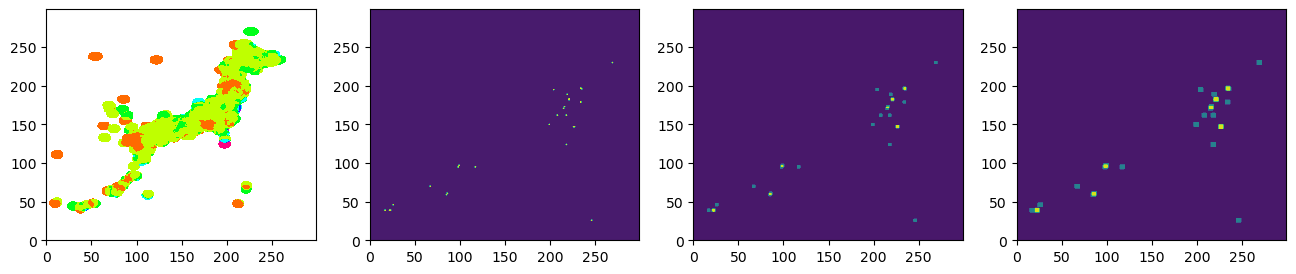

1297
2012-01-01 05:27:55+00:00


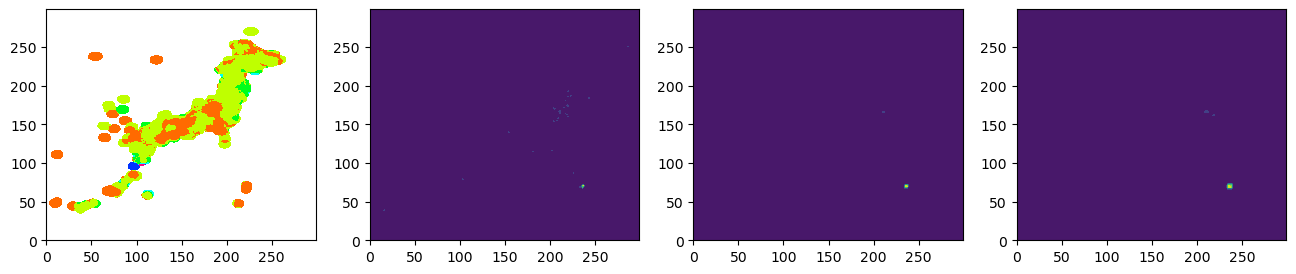

1290
2012-03-14 09:08:36+00:00


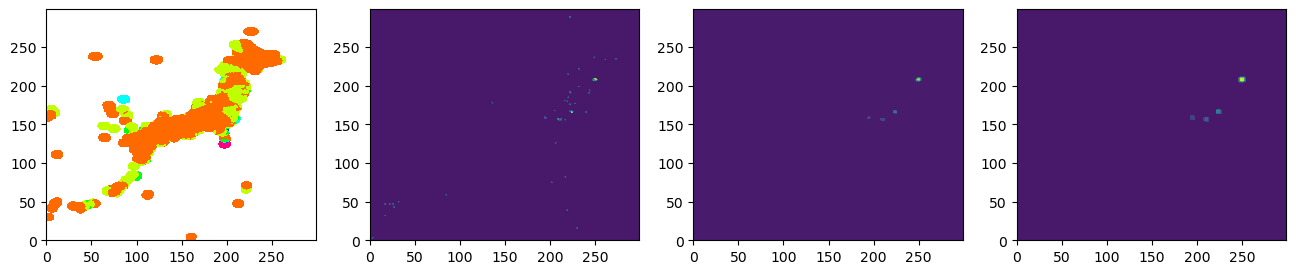

1267
2012-08-14 02:59:38+00:00


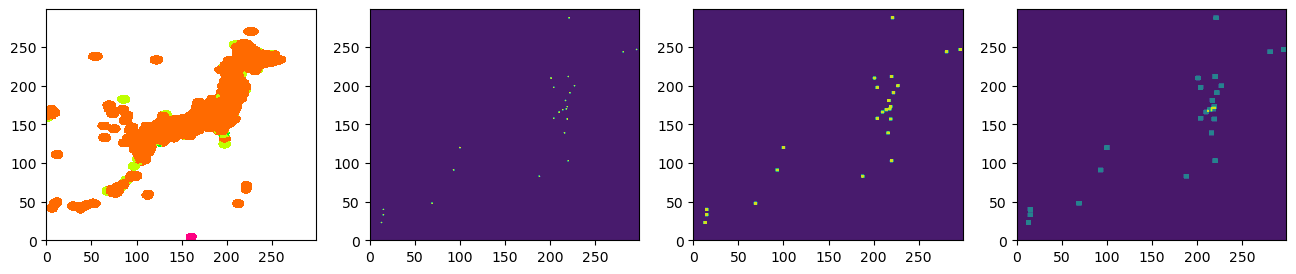

1302
2012-12-07 08:18:23+00:00


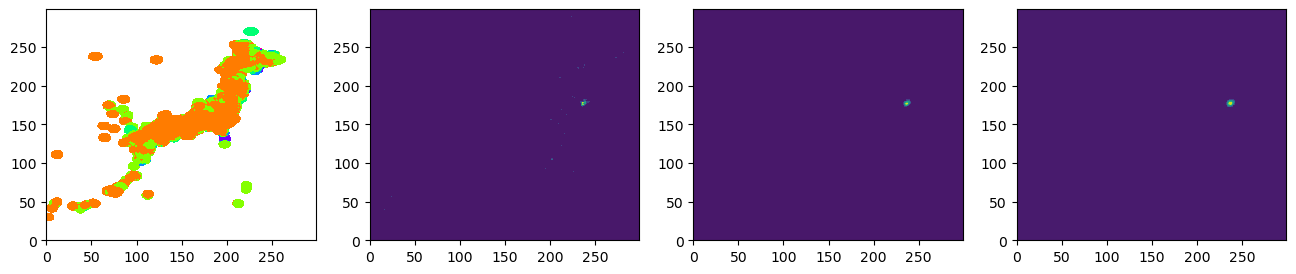

1269
2013-02-02 14:17:34+00:00


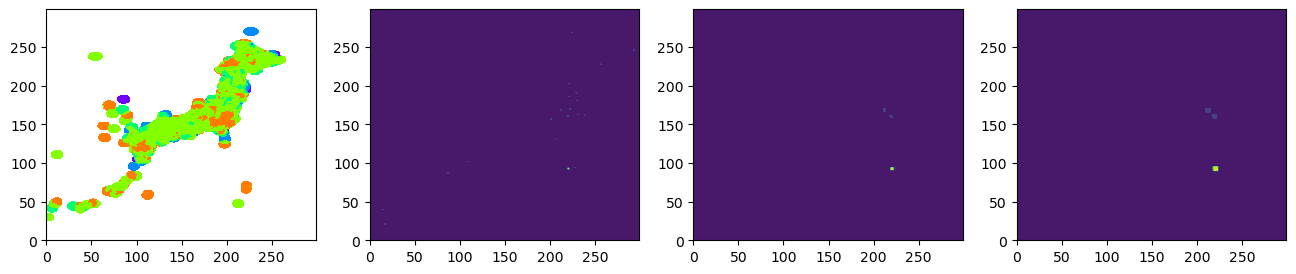

1271
2013-09-04 00:18:24+00:00


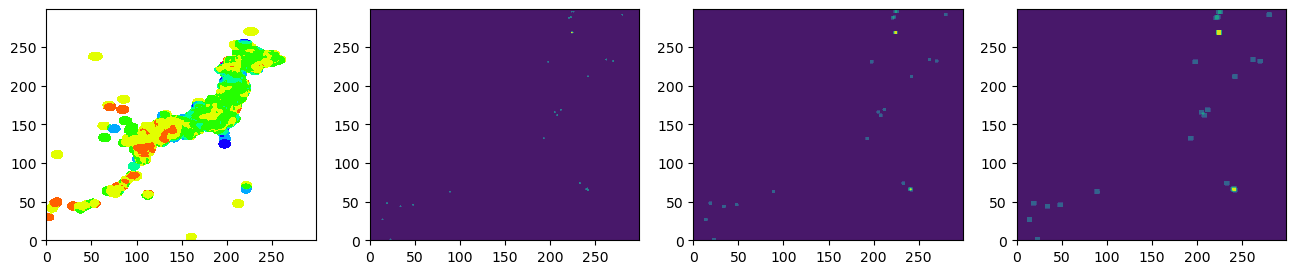

1300
2013-10-11 09:28:47+00:00


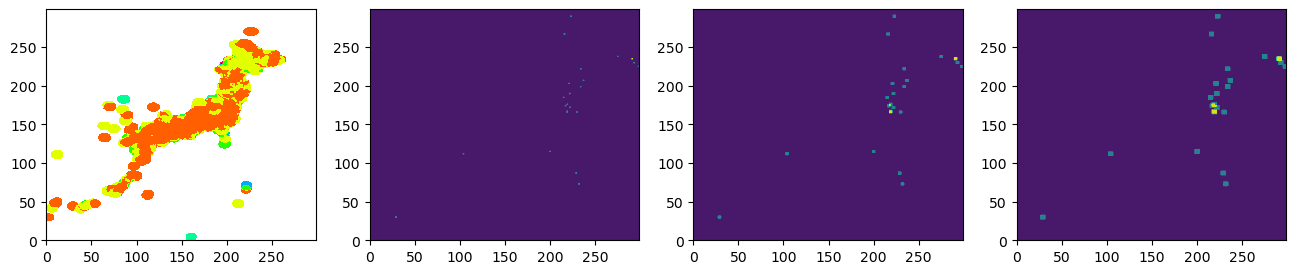

1299
2013-10-25 17:10:17+00:00


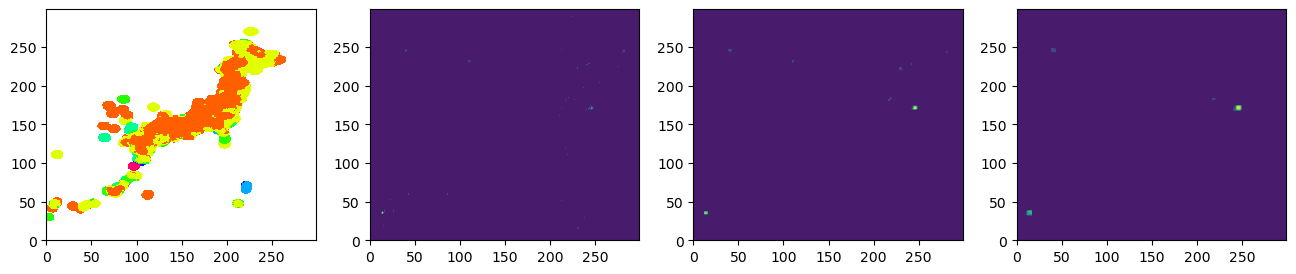

1298
2014-03-02 20:11:22+00:00


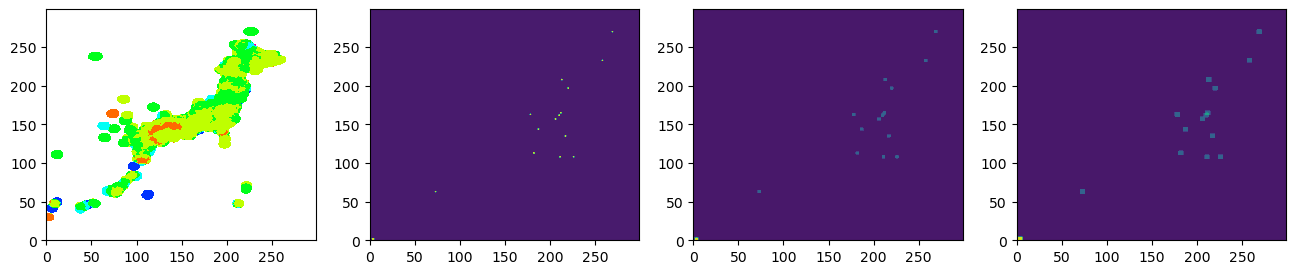

1272
2014-07-11 19:22:00+00:00


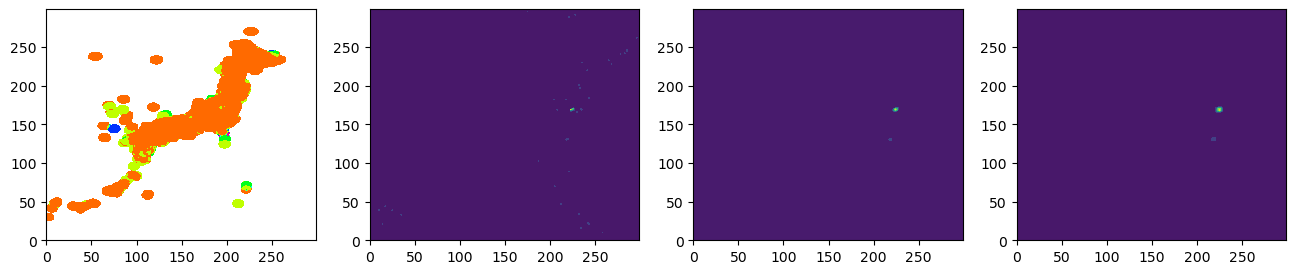

1327
2014-07-11 19:22:05+00:00


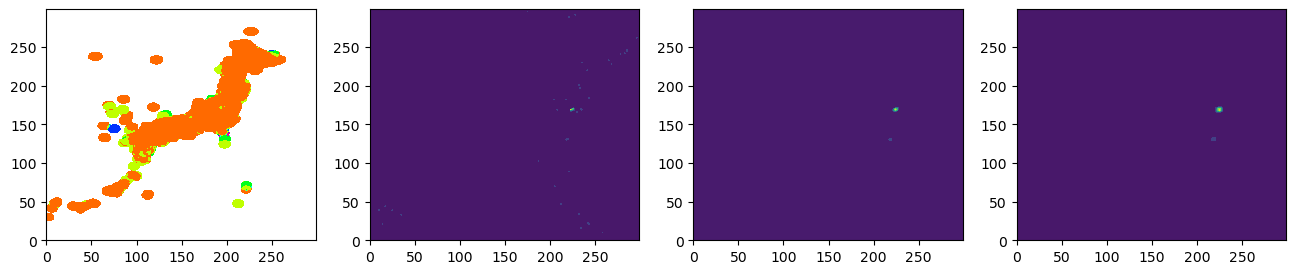

1327
2014-11-09 14:38:15+00:00


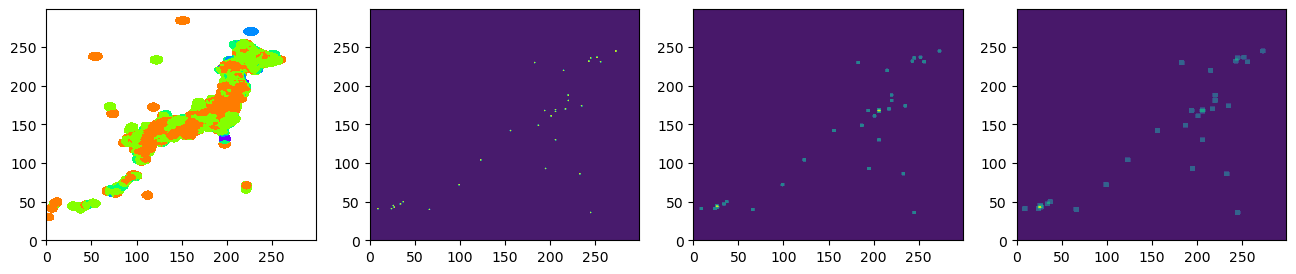

1281
2015-02-16 23:06:28+00:00


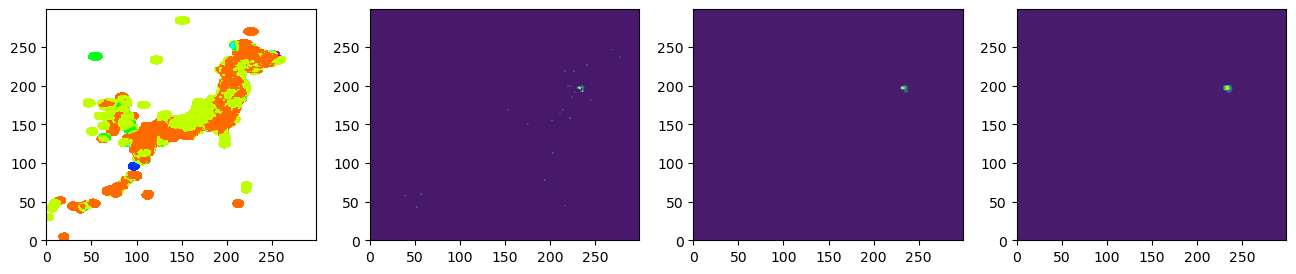

1372
2015-05-12 21:12:58+00:00


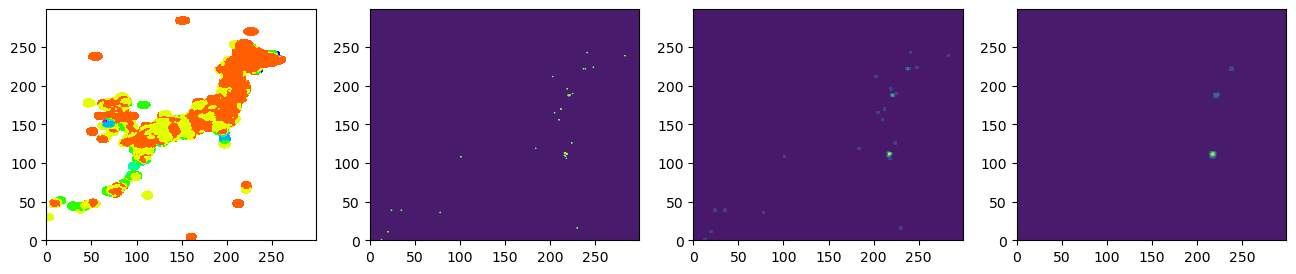

1365
2015-05-30 11:23:02+00:00


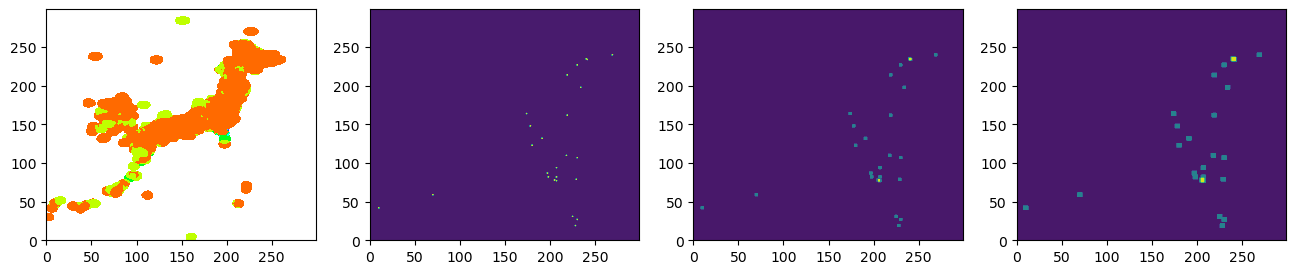

1375
2015-06-23 12:18:30+00:00


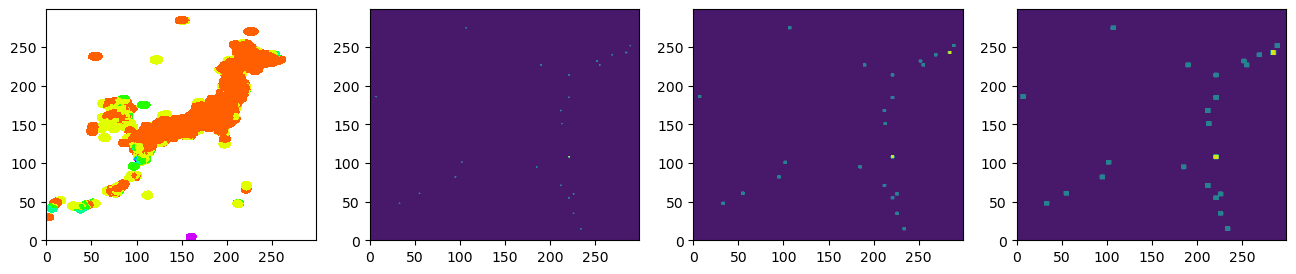

1359
2015-11-13 20:51:31+00:00


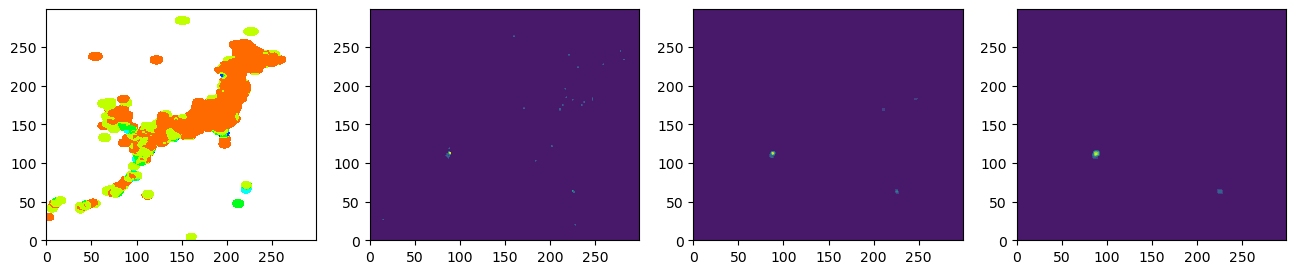

1374
2016-01-14 03:25:33+00:00


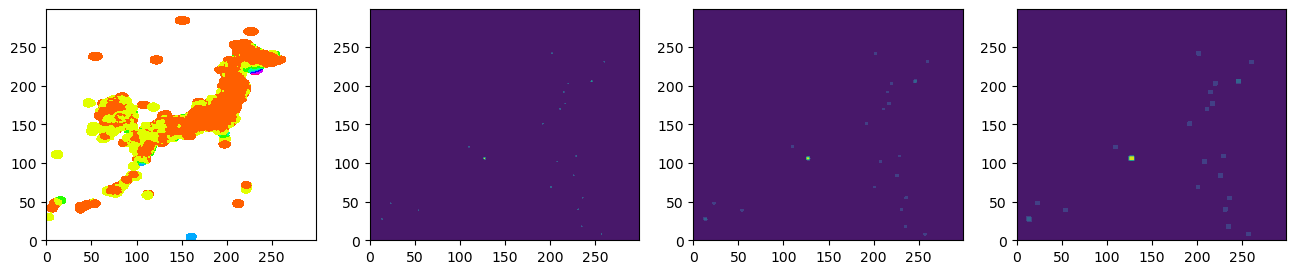

1447
2016-04-15 16:25:06+00:00


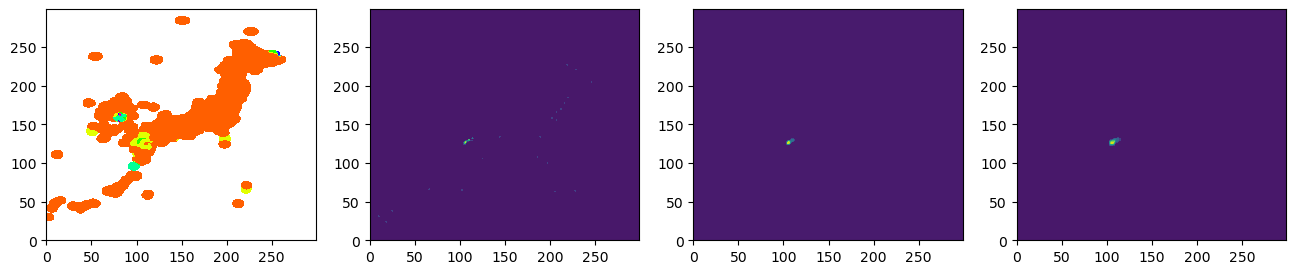

1406
2016-11-21 20:59:49+00:00


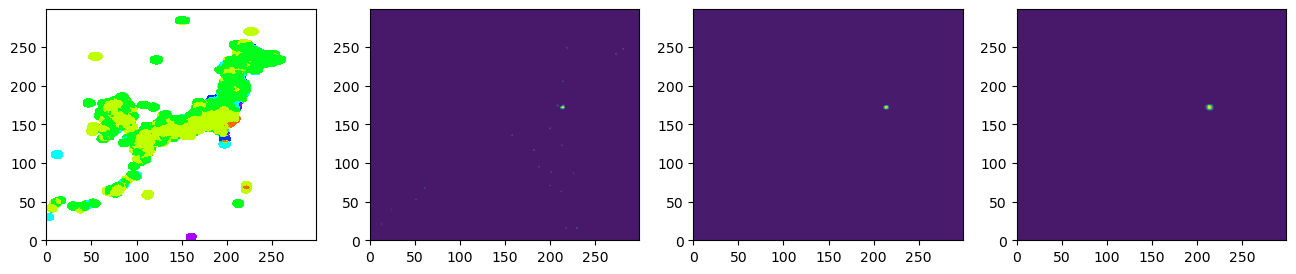

1445
2018-09-05 18:07:59+00:00


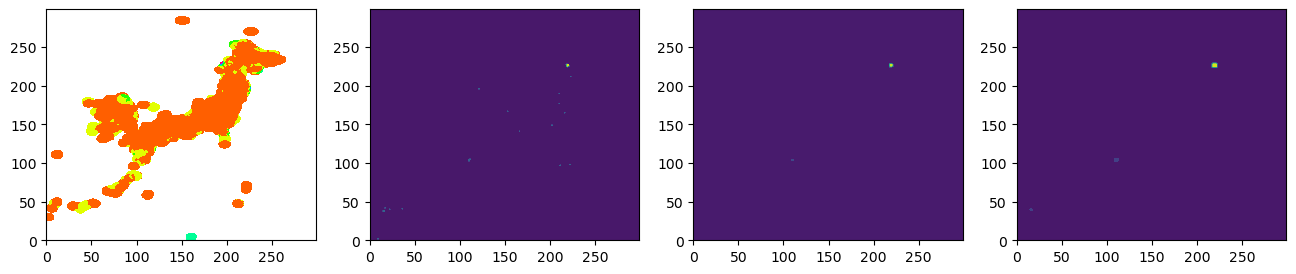

1517
2020-02-13 10:33:44+00:00


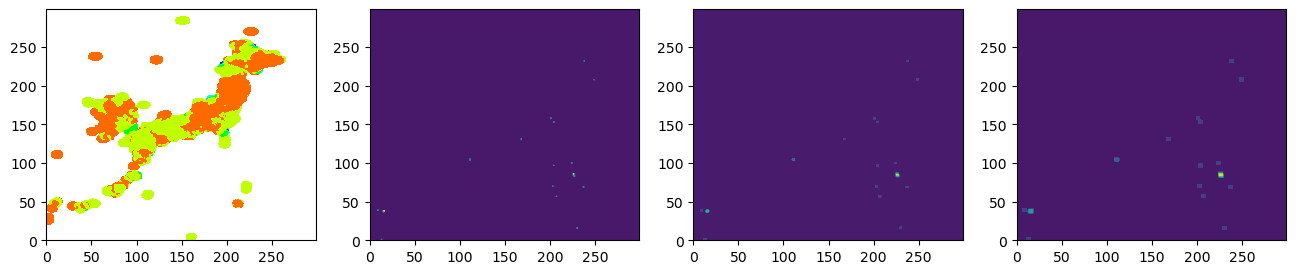

1471
2020-04-18 08:25:37+00:00


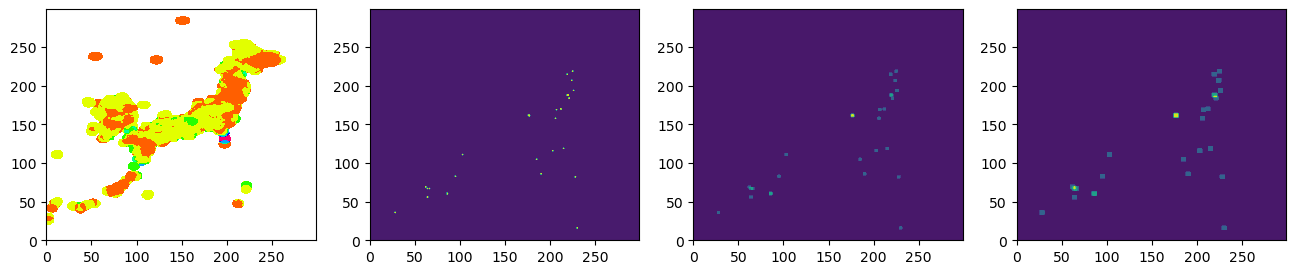

1463
2020-06-13 15:51:24+00:00


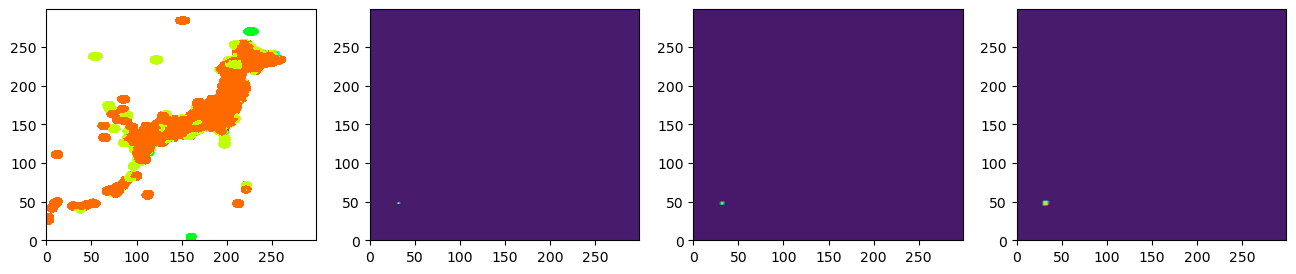

1335
2021-02-13 14:07:50+00:00


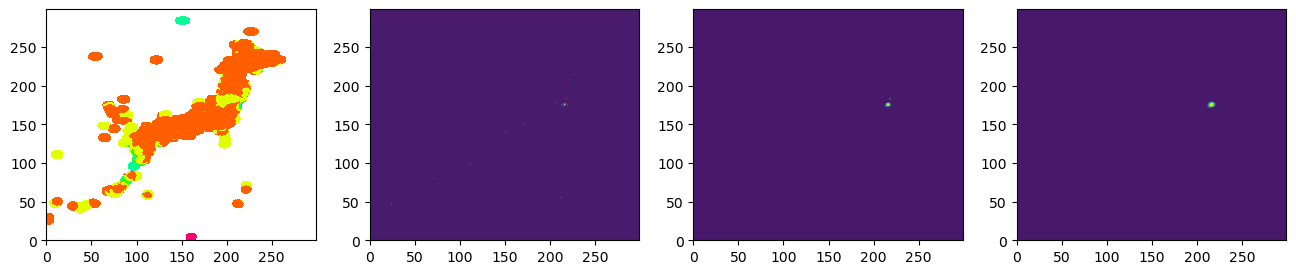

1334
2021-03-20 09:09:44+00:00


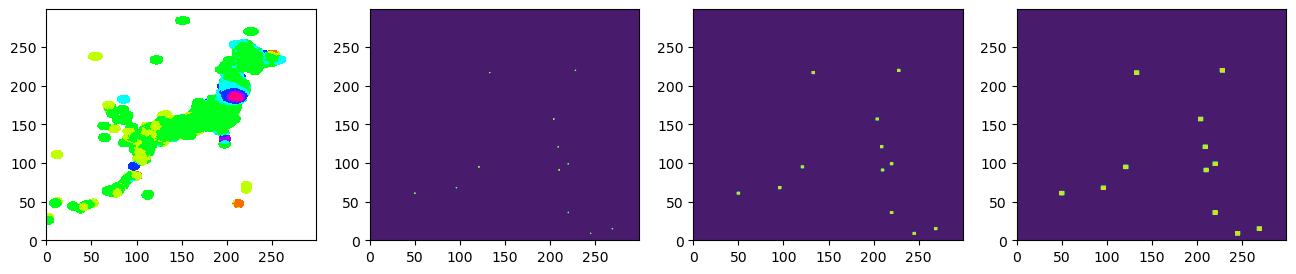

1328
2021-05-01 01:27:27+00:00


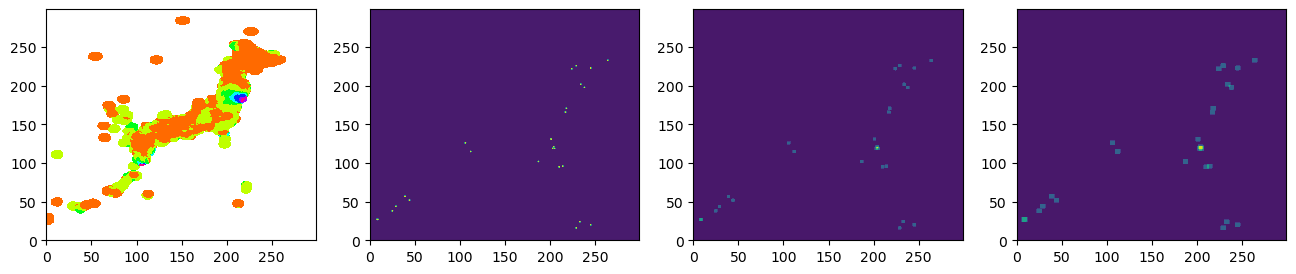

1375
2021-11-10 15:45:13+00:00


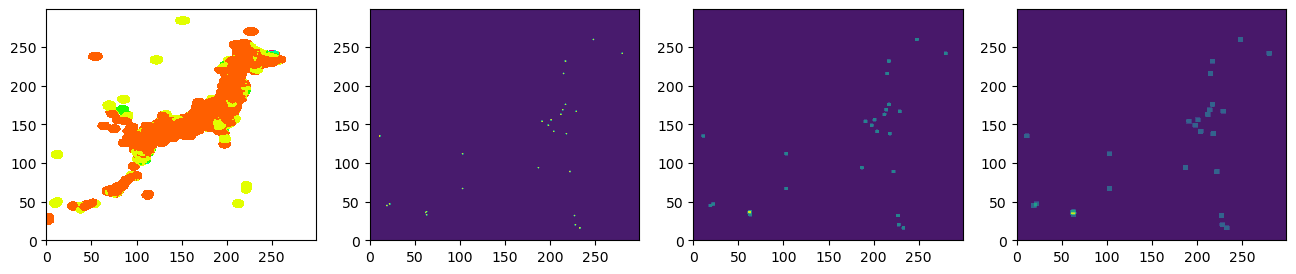

1366
2021-11-10 15:45:17+00:00


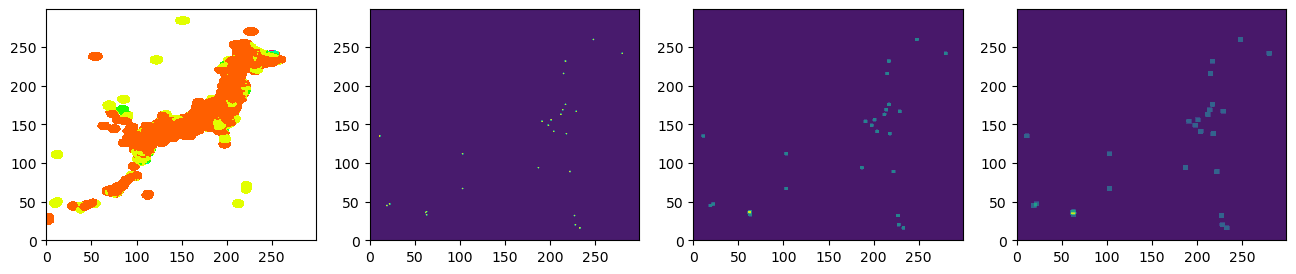

1366
2021-11-29 12:40:49+00:00


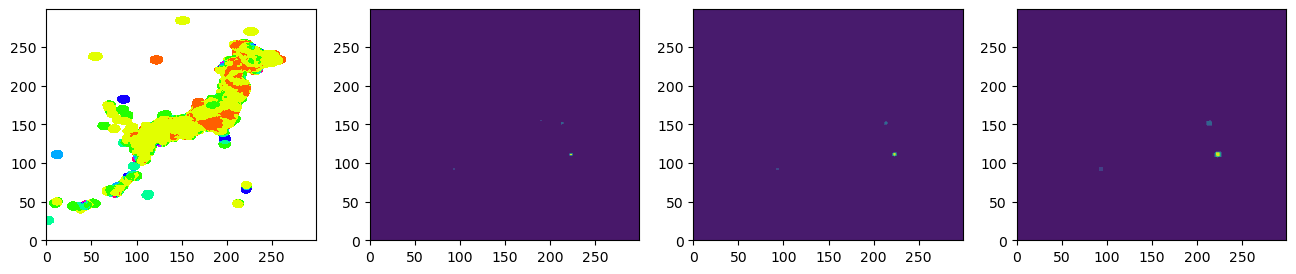

1370
2022-03-16 14:36:33+00:00


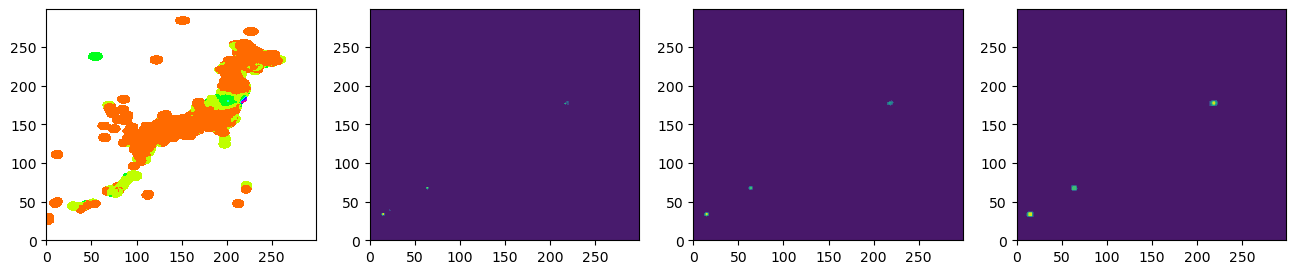

1376
2022-03-22 17:41:38+00:00


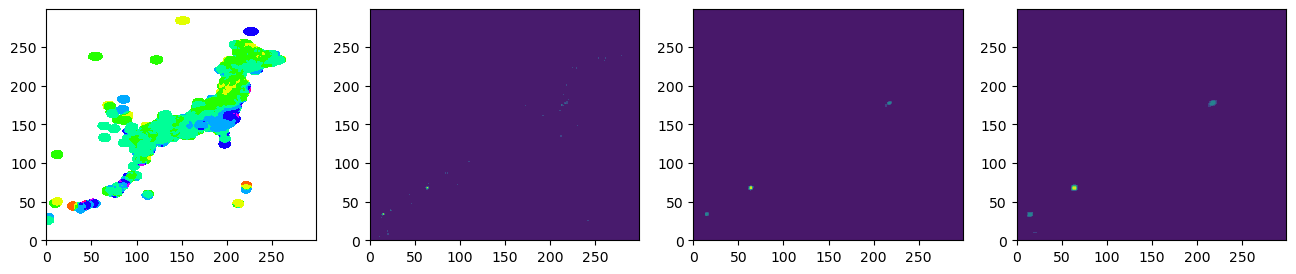

1375
2022-09-17 13:41:17+00:00


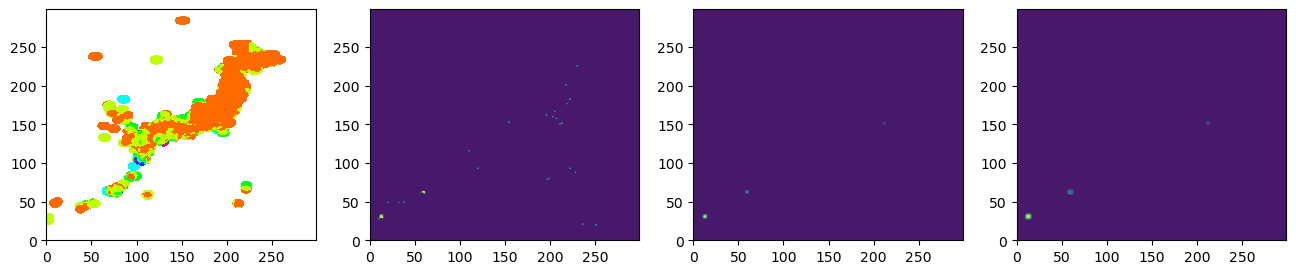

908
2022-09-18 06:44:13+00:00


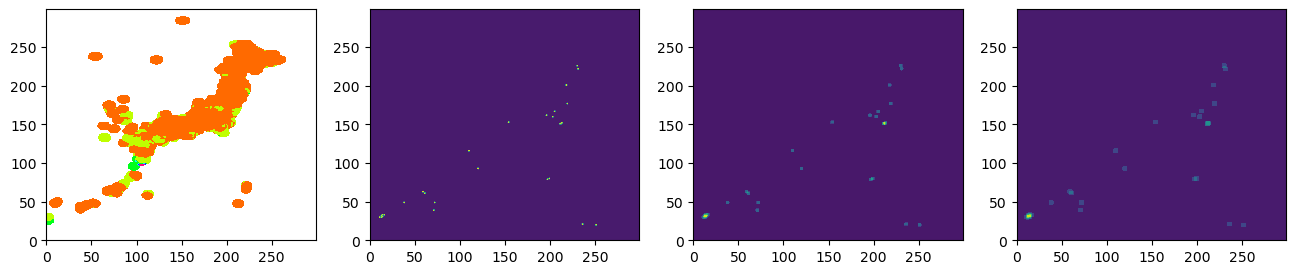

910
italy
2003-03-29 17:42:13+00:00


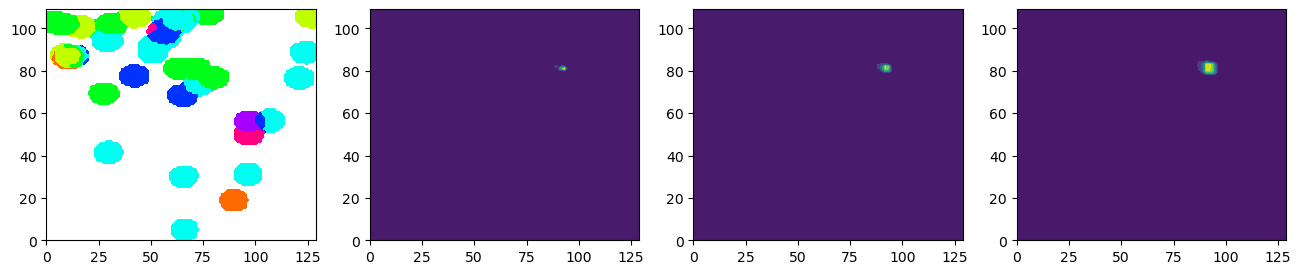

43
2003-04-11 09:26:56+00:00


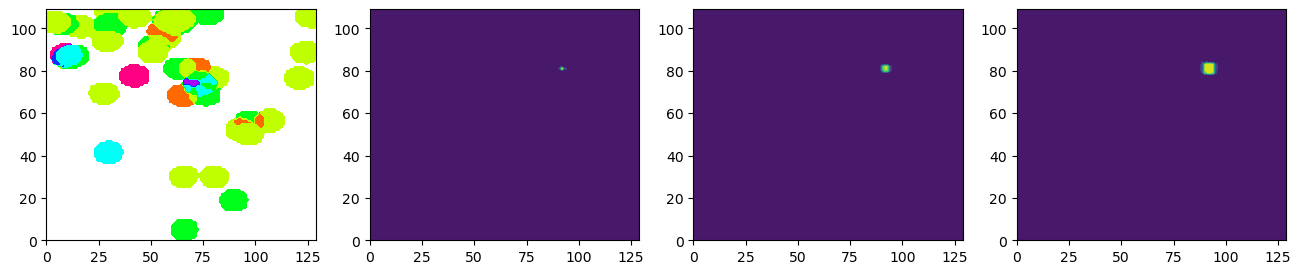

46
2003-09-14 21:42:52+00:00


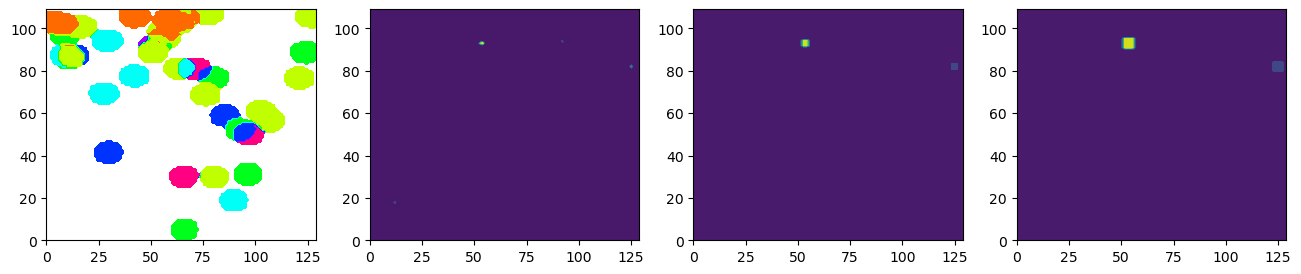

42
2004-05-05 13:39:42+00:00


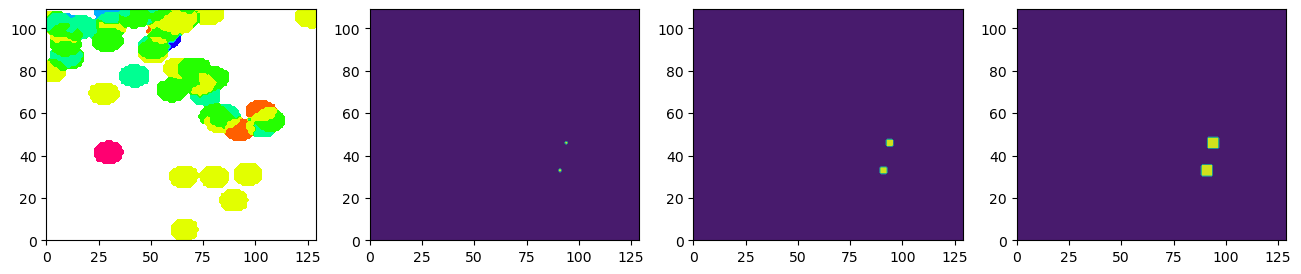

53
2004-05-23 15:19:06+00:00


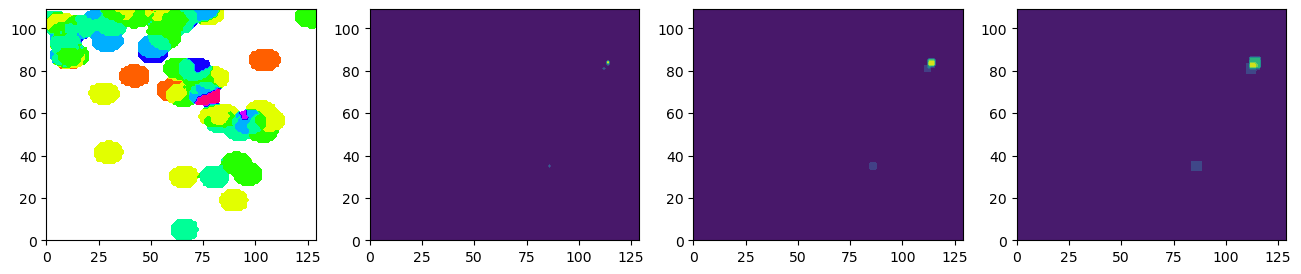

64
2004-11-24 22:59:37+00:00


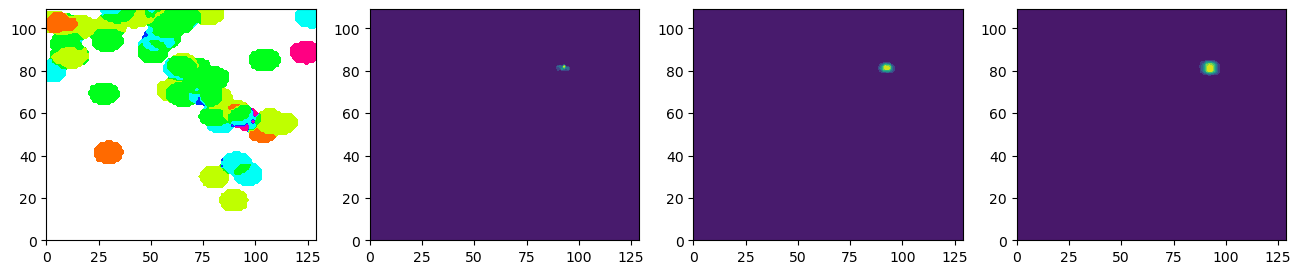

64
2004-11-25 06:21:15+00:00


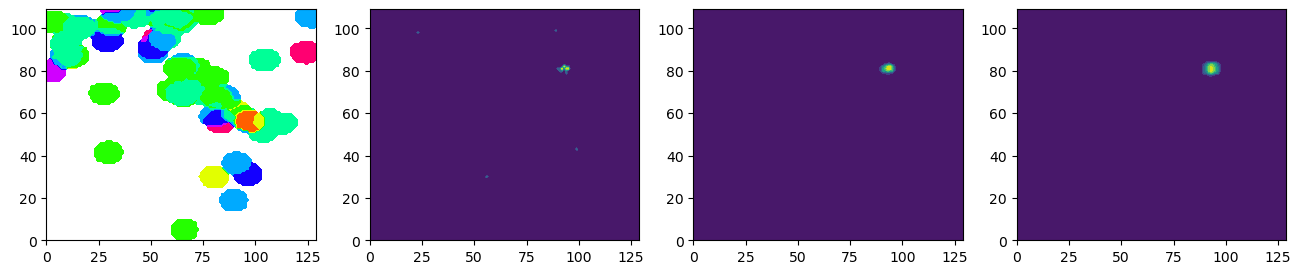

65
2004-12-18 09:12:46+00:00


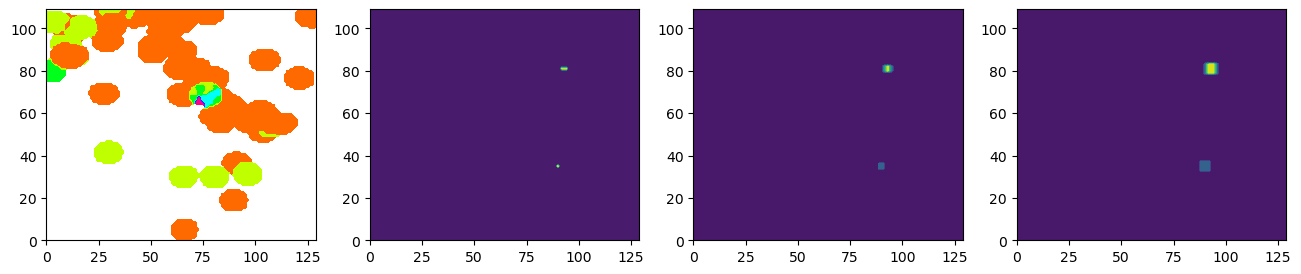

69
2005-07-26 03:32:18+00:00


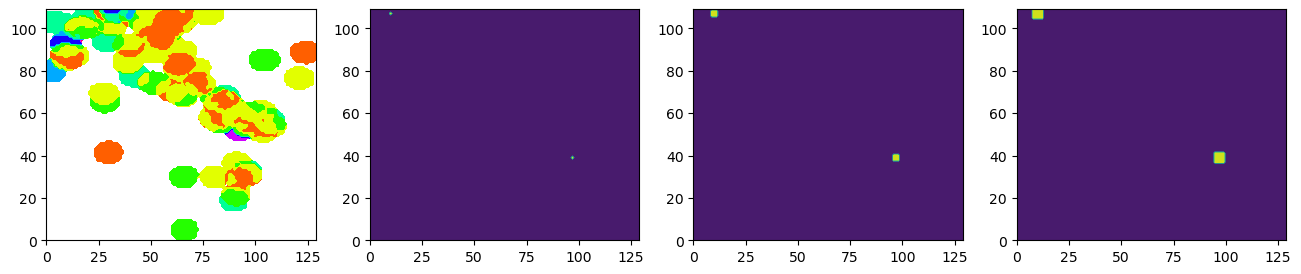

95
2005-09-27 00:25:33+00:00


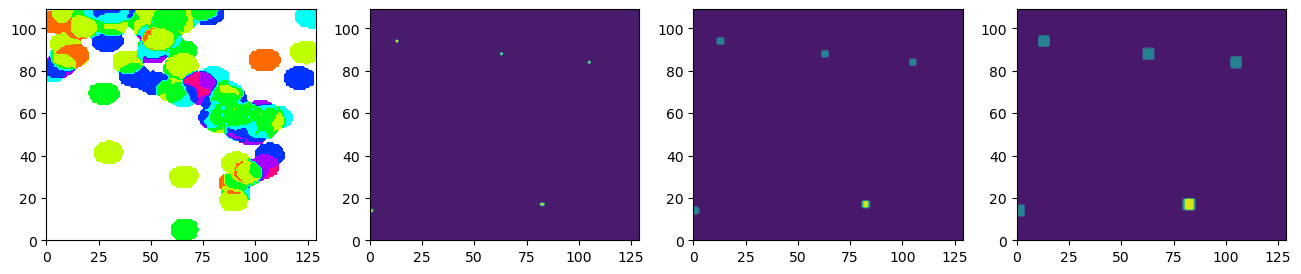

100
2006-10-26 14:28:38+00:00


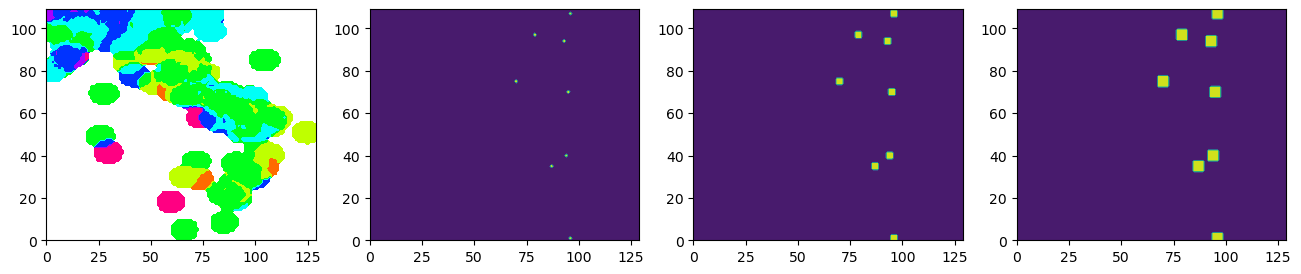

173
2006-11-05 17:15:00+00:00


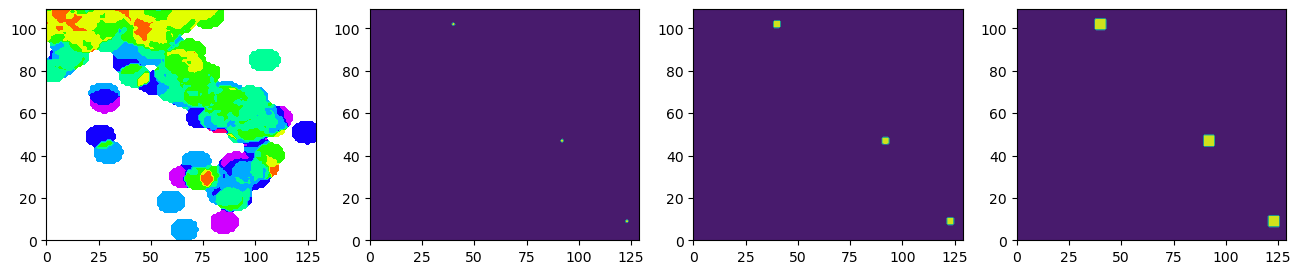

171
2007-07-04 23:55:35+00:00


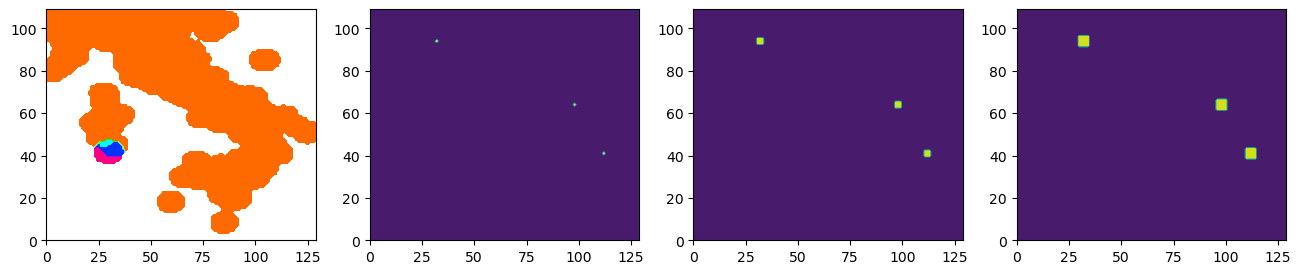

214
2008-12-17 21:57:45+00:00


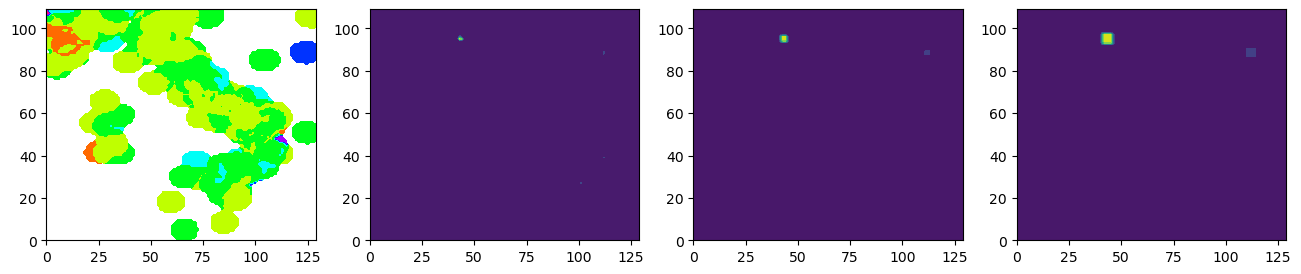

215
2008-12-23 15:24:22+00:00


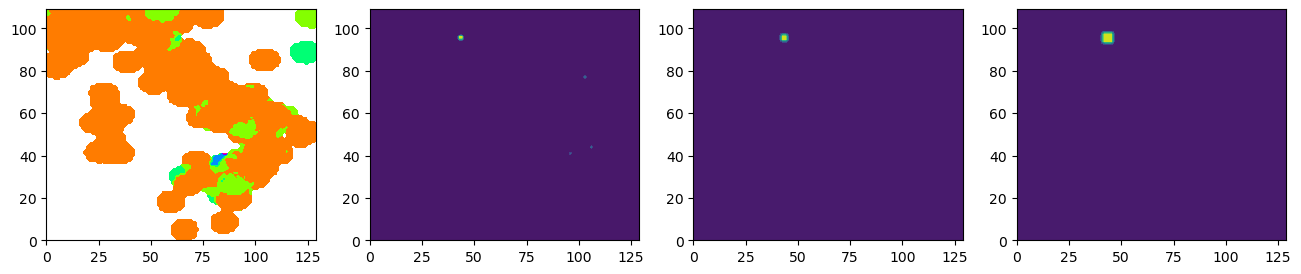

243
2008-12-23 21:58:27+00:00


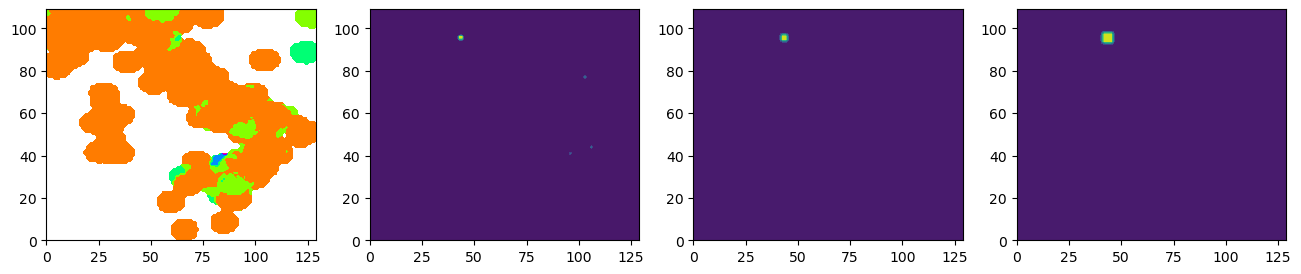

243
2009-04-06 01:32:42+00:00


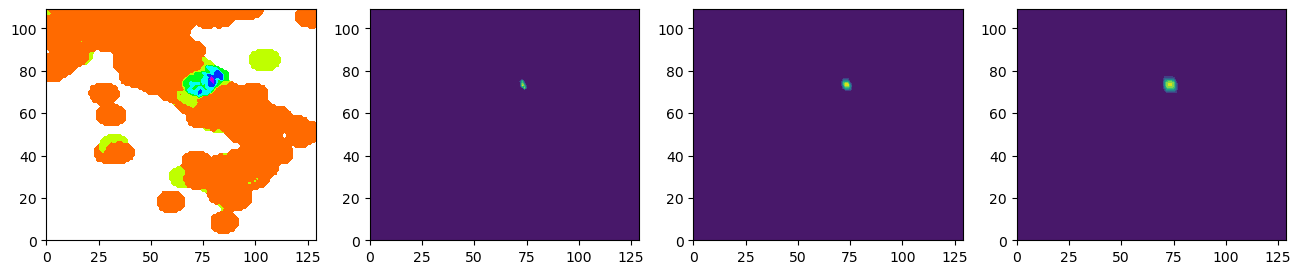

261
2009-04-06 23:15:38+00:00


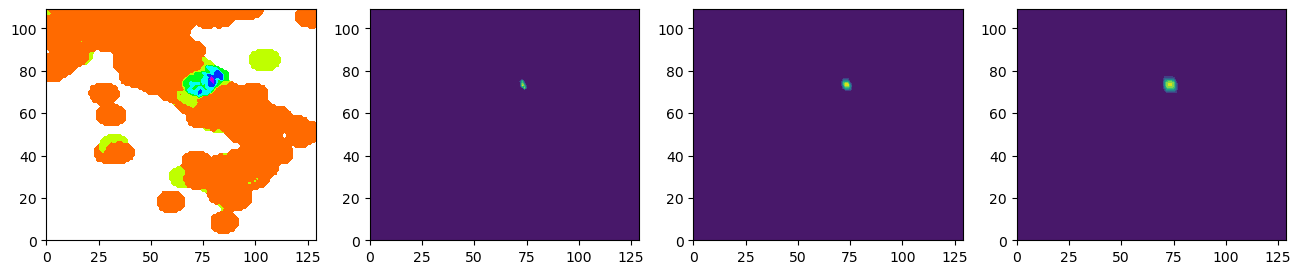

261
2009-04-07 17:47:38+00:00


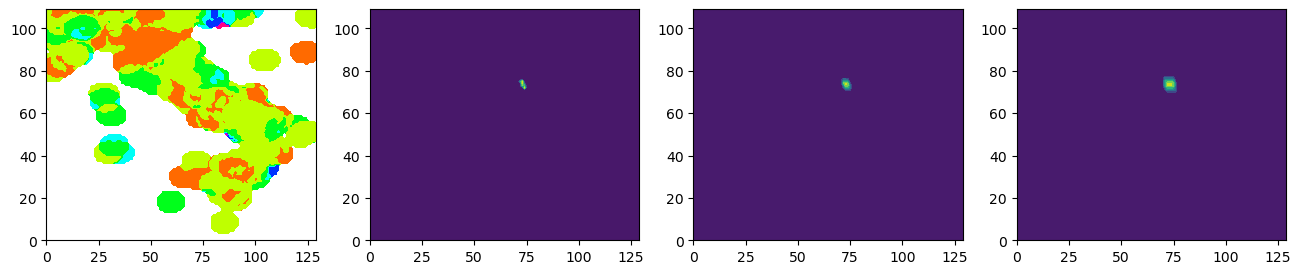

259
2009-04-09 00:53:01+00:00


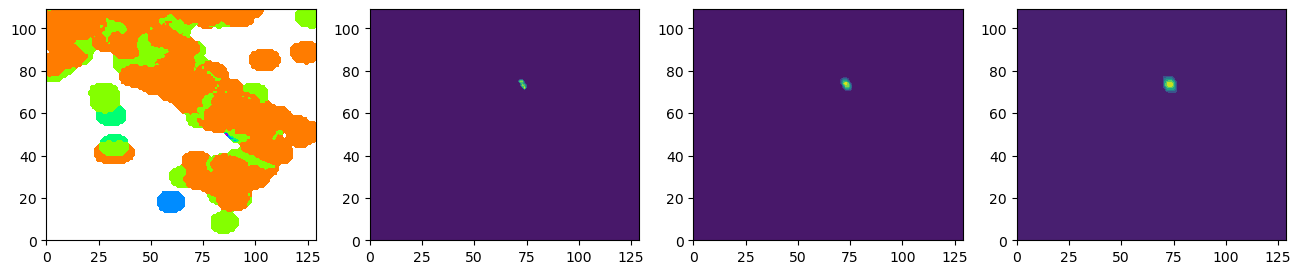

268
2009-04-09 19:38:18+00:00


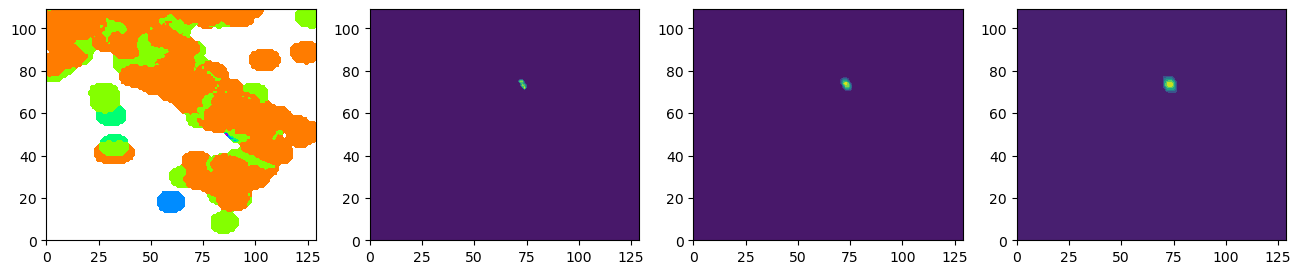

268
2009-04-13 21:14:26+00:00


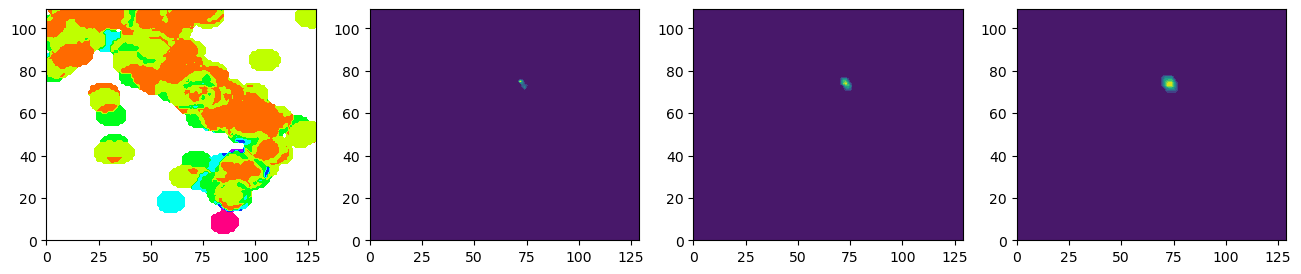

247
2010-11-03 18:13:10+00:00


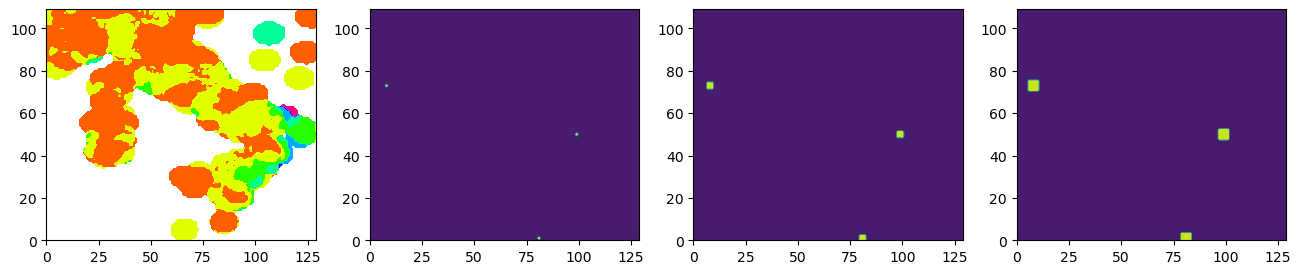

423
2011-07-07 19:21:47+00:00


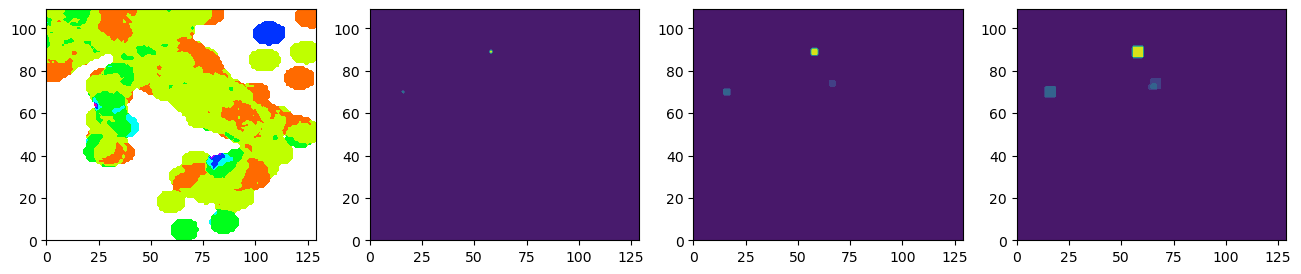

408
2012-01-25 08:06:37+00:00


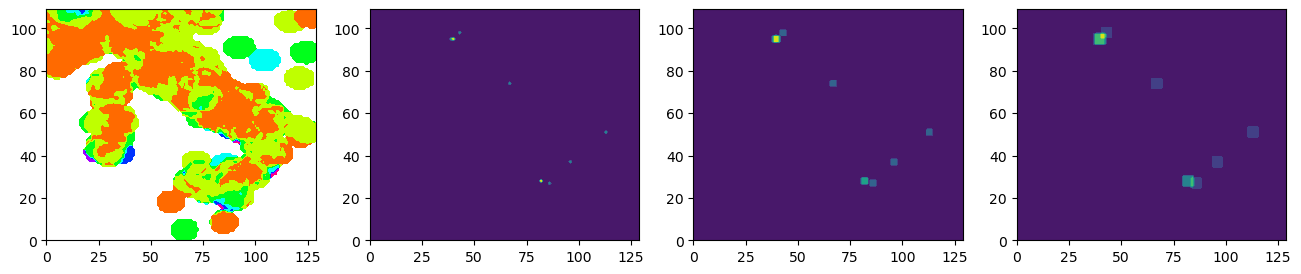

468
2012-01-27 14:53:13+00:00


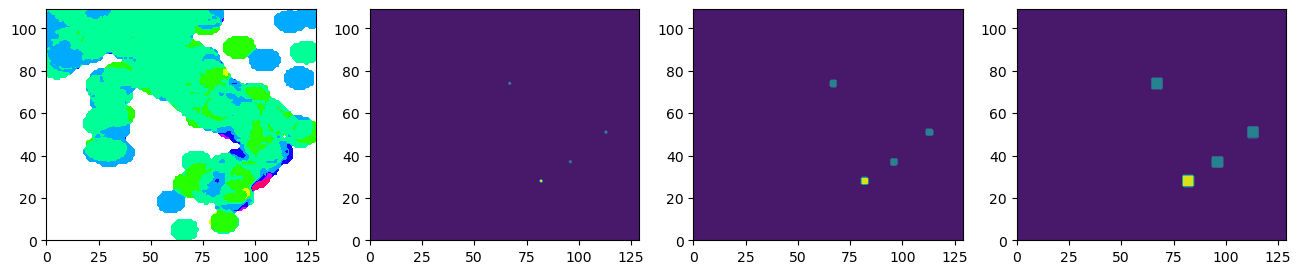

446
2012-05-20 02:03:53+00:00


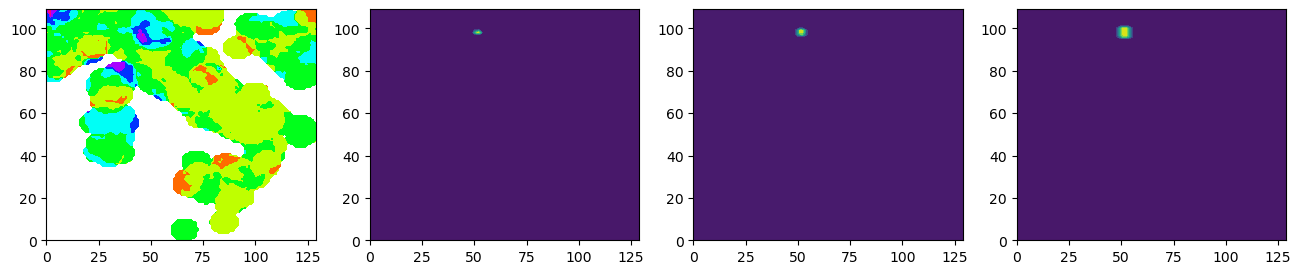

474
2012-05-20 02:07:28+00:00


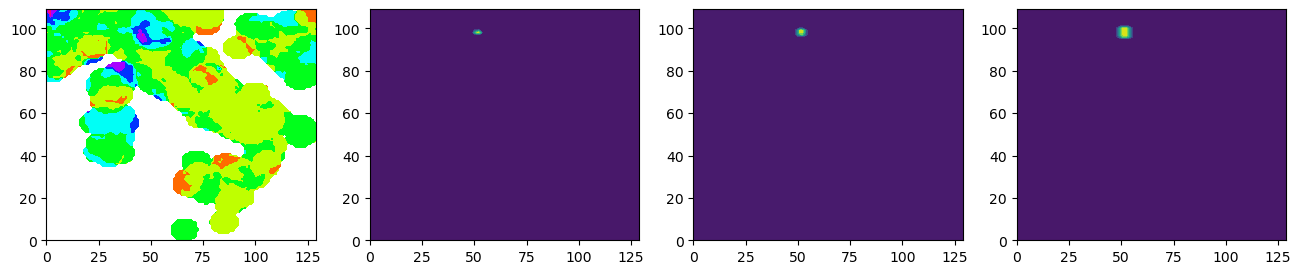

474
2012-05-20 03:02:50+00:00


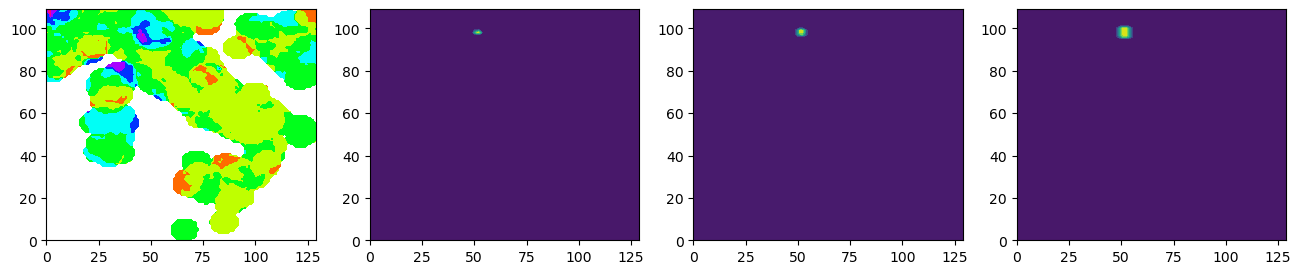

474
2012-05-20 06:32:19+00:00


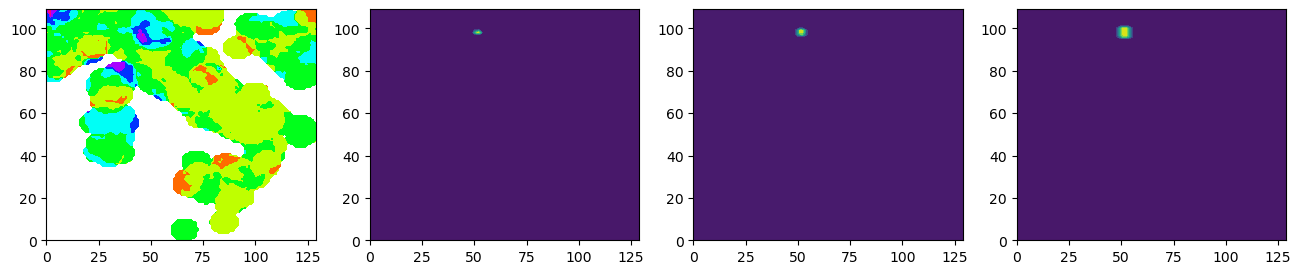

474
2012-05-20 13:18:03+00:00


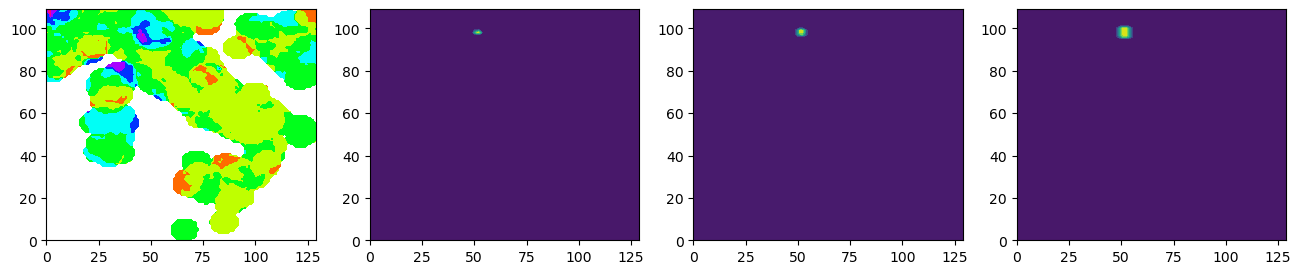

474
2012-05-29 07:00:04+00:00


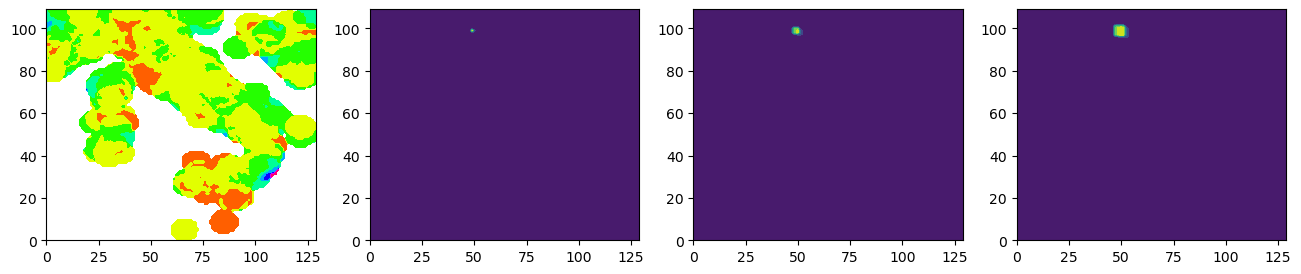

471
2012-05-29 10:55:57+00:00


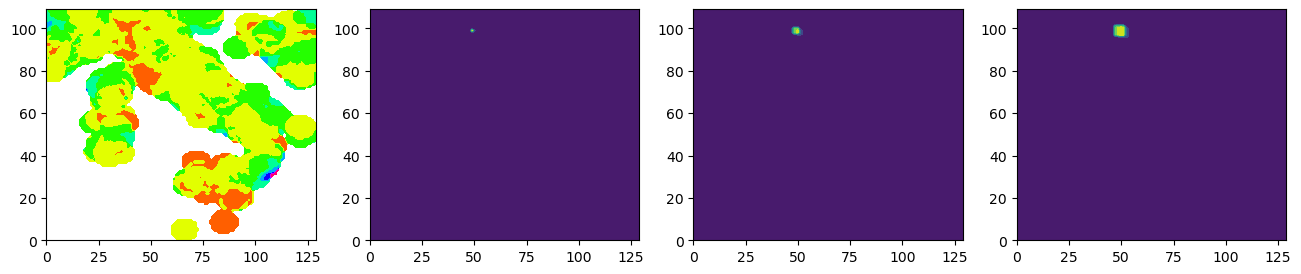

471
2012-06-03 19:20:44+00:00


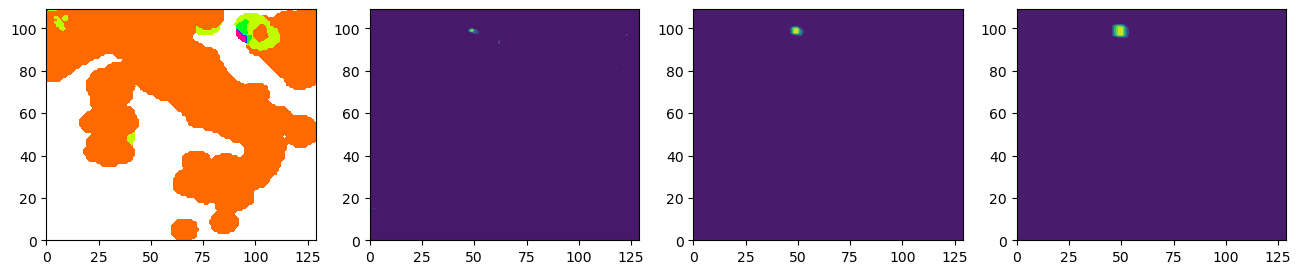

476
2012-10-25 23:05:26+00:00


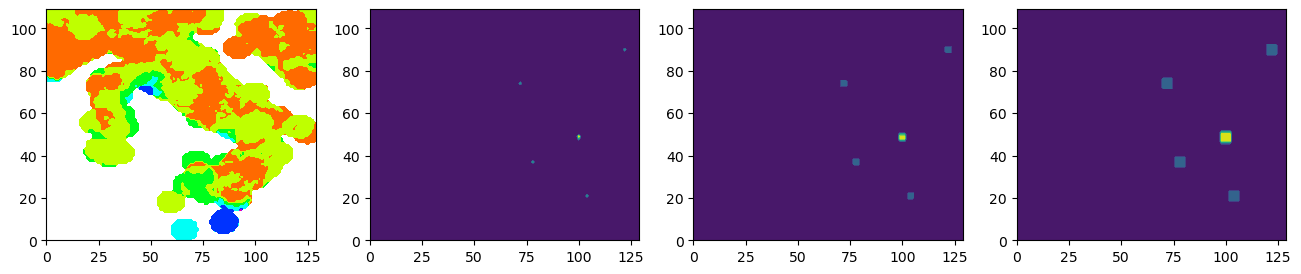

470
2013-01-25 14:48:19+00:00


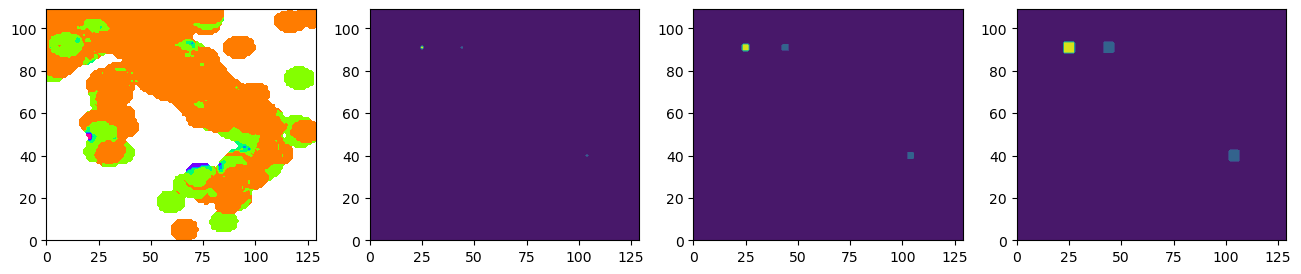

388
2013-02-06 01:36:50+00:00


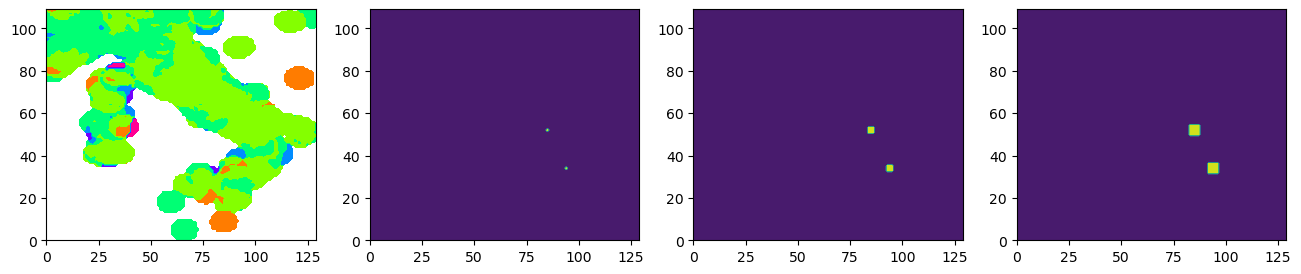

421
2013-02-16 21:16:10+00:00


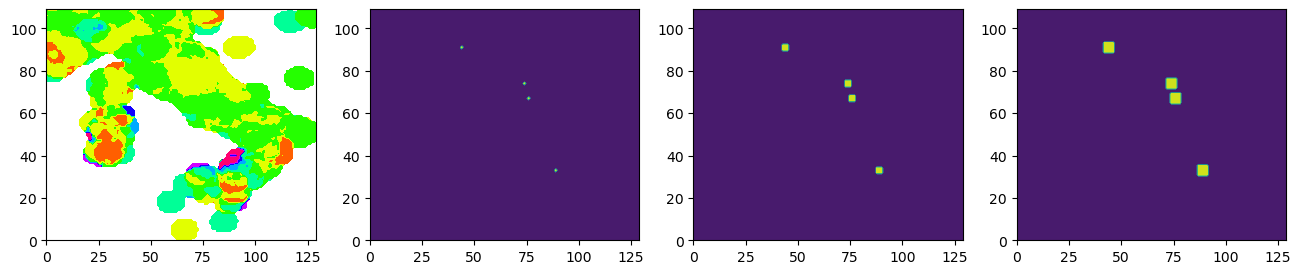

424
2013-04-22 03:51:25+00:00


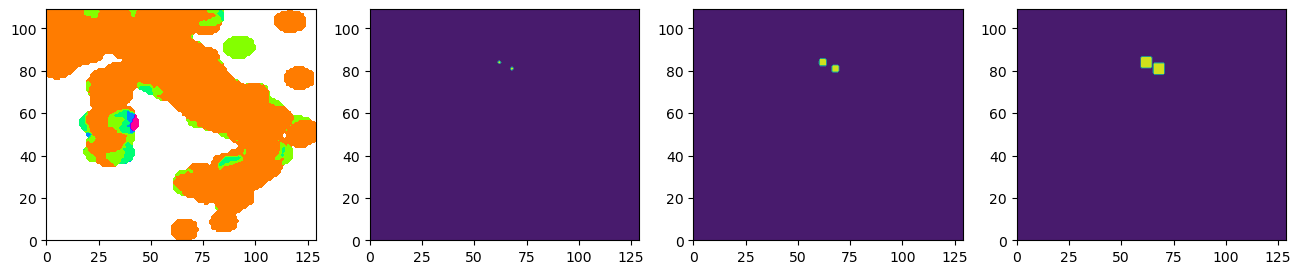

465
2013-06-21 10:33:57+00:00


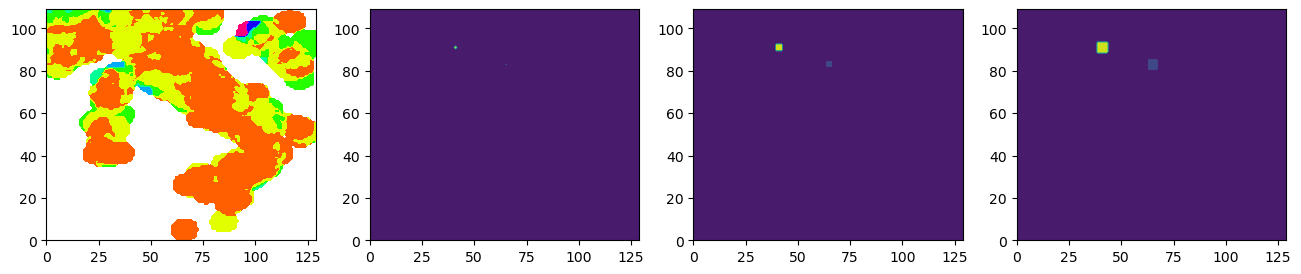

480
2013-07-21 01:32:25+00:00


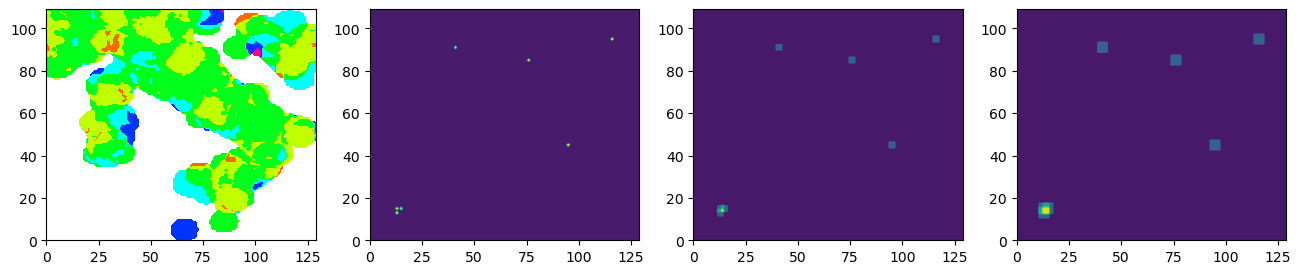

493
2013-12-29 17:08:43+00:00


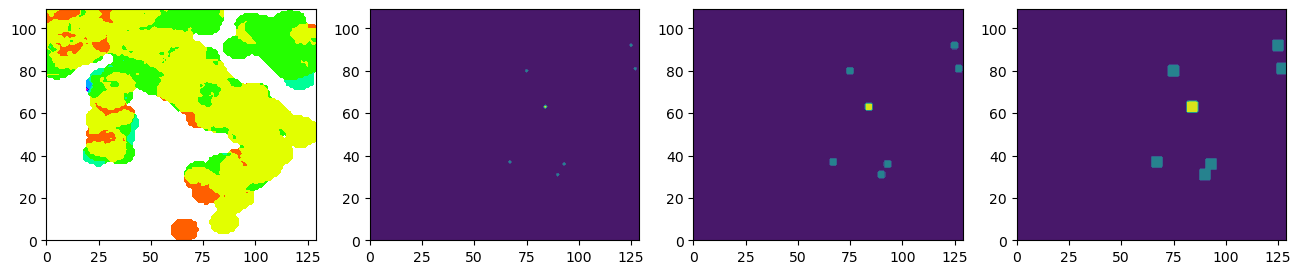

470
2014-04-07 19:27:00+00:00


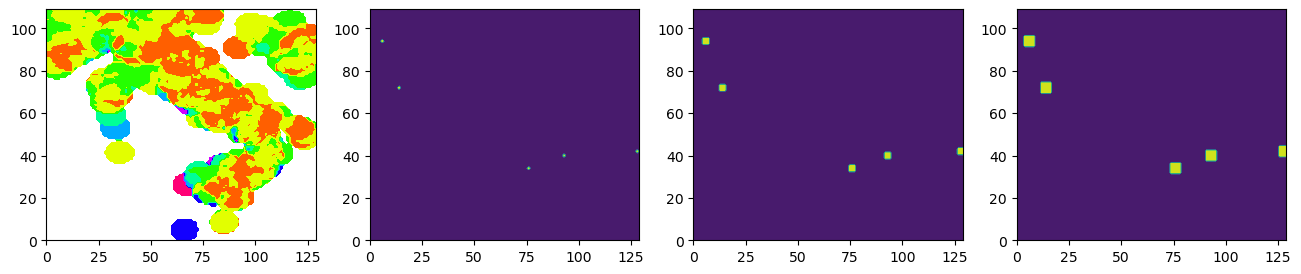

378
2016-10-26 17:10:37+00:00


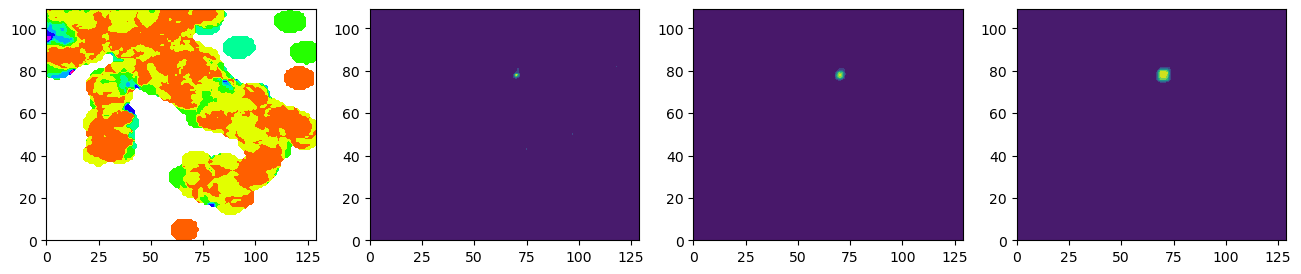

500
2016-10-26 19:18:08+00:00


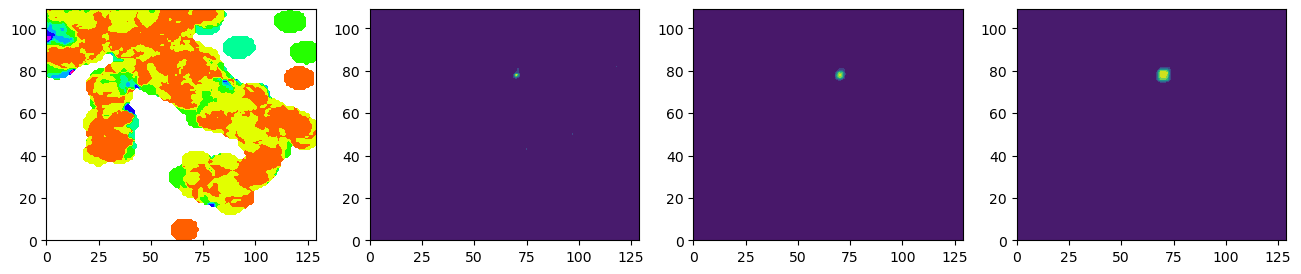

500
2016-10-28 20:02:48+00:00


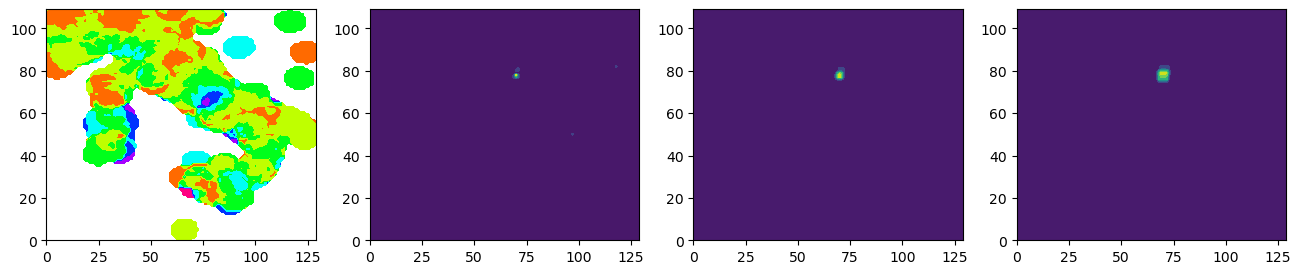

496
2016-10-30 06:40:19+00:00


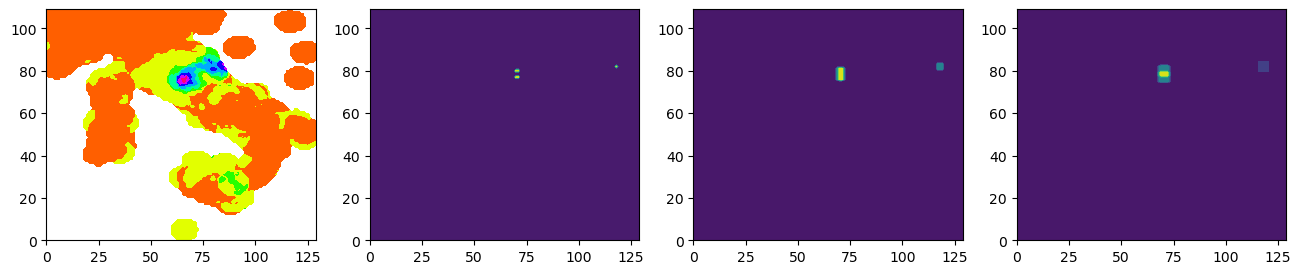

496
2017-01-18 09:25:41+00:00


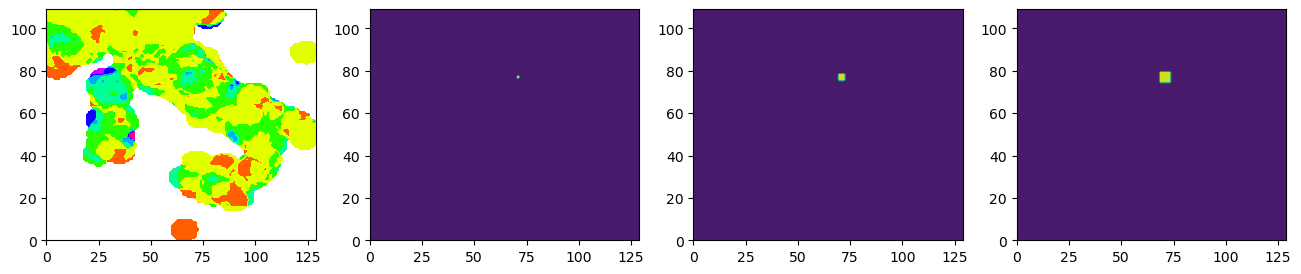

433
2017-01-18 10:25:25+00:00


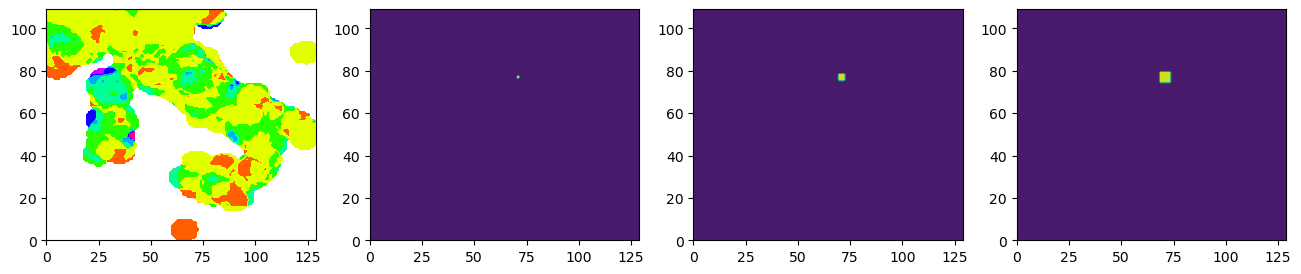

433
2017-01-18 13:33:38+00:00


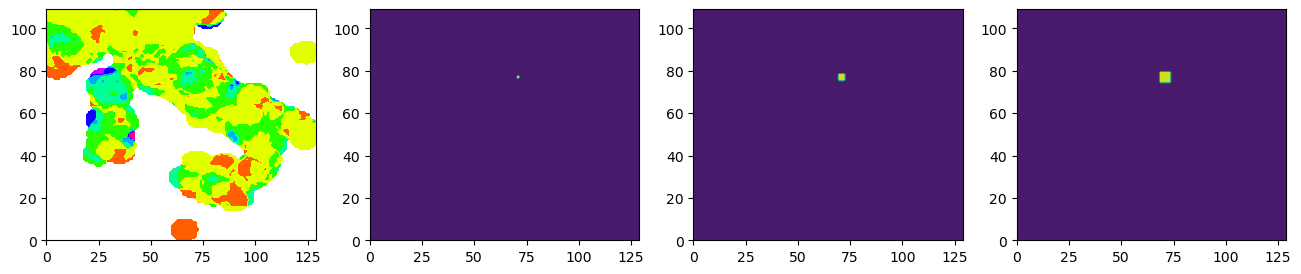

433
2018-08-16 18:19:05+00:00


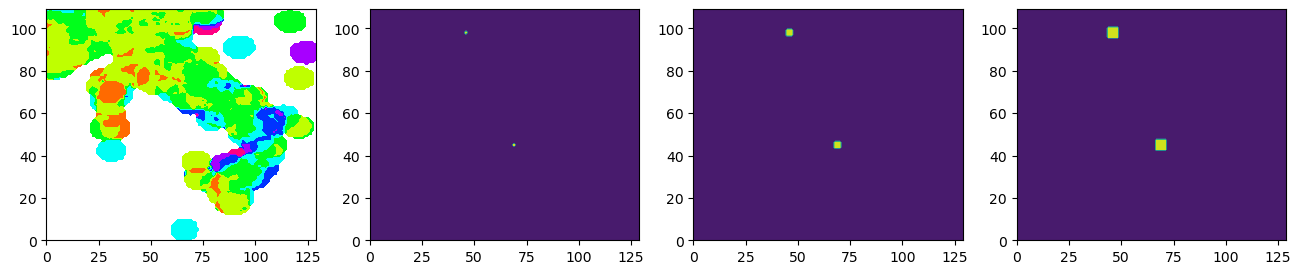

319
2018-12-26 02:19:14+00:00


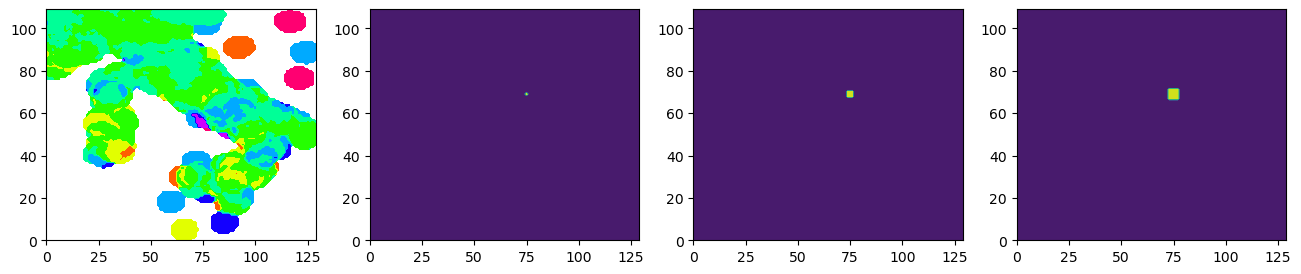

491
2019-11-26 09:19:26+00:00


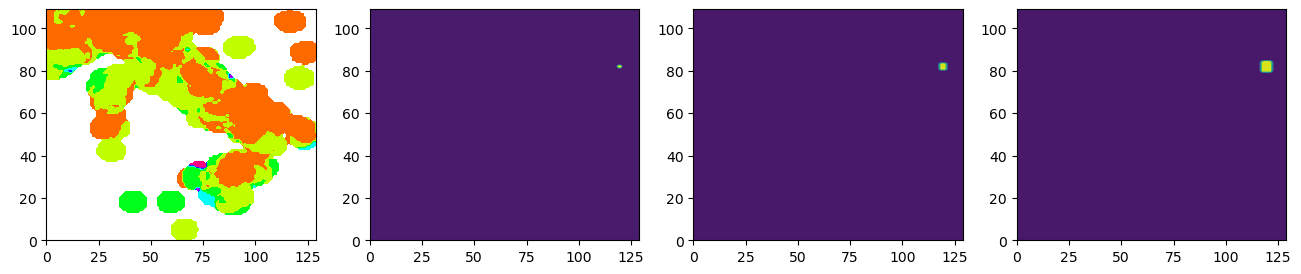

357
2020-03-22 05:24:03+00:00


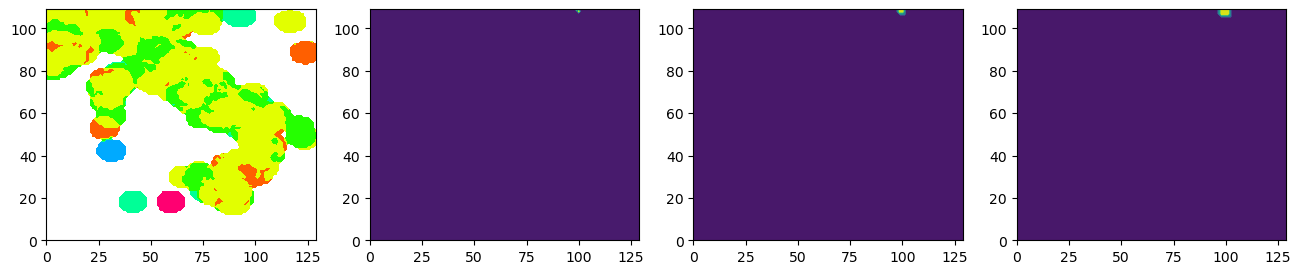

347
2020-11-22 03:53:08+00:00


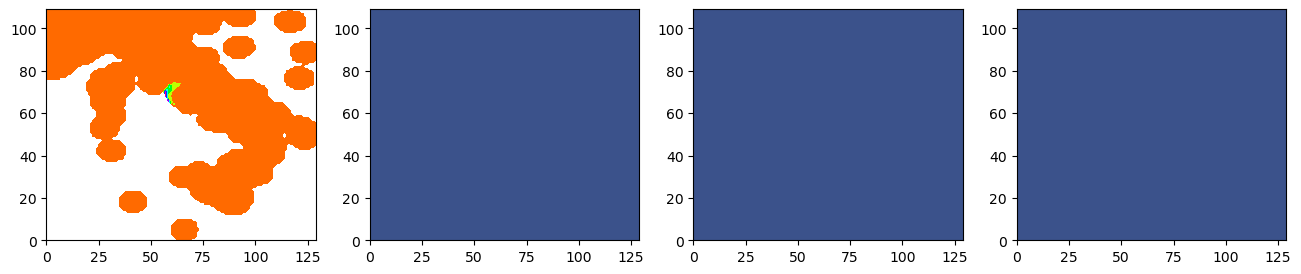

327
2020-12-29 11:19:54+00:00


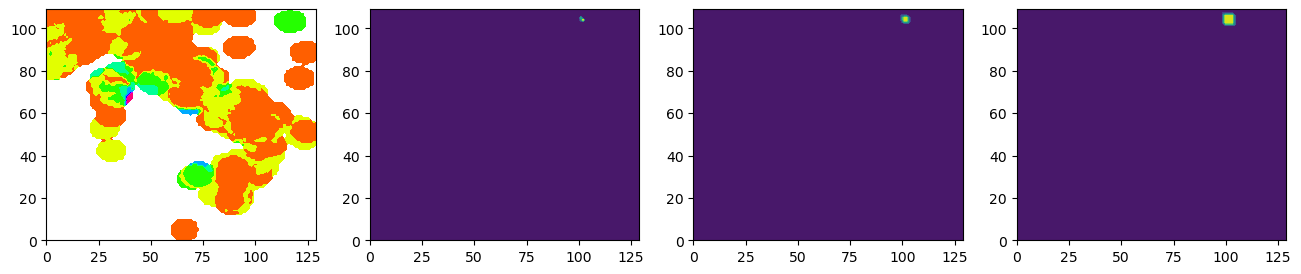

308
2021-03-27 13:47:55+00:00


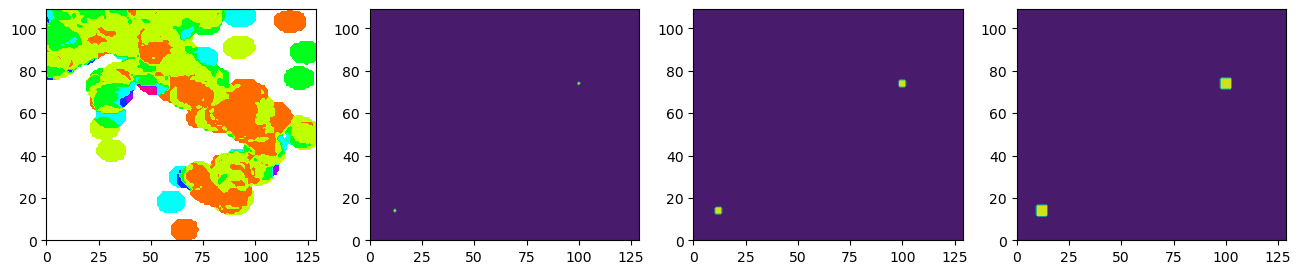

327
2022-04-22 21:07:48+00:00


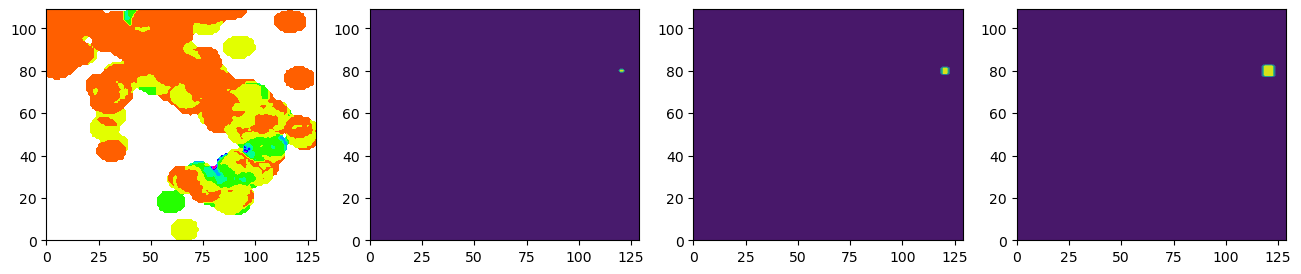

355
2022-10-31 21:42:50+00:00


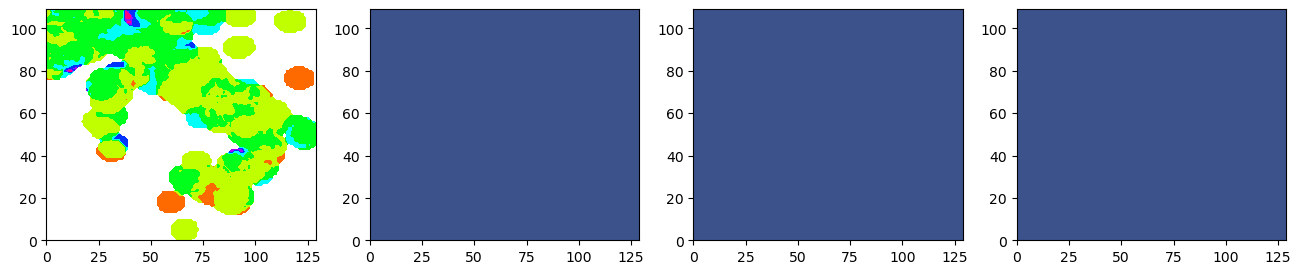

374
2022-11-09 06:07:26+00:00


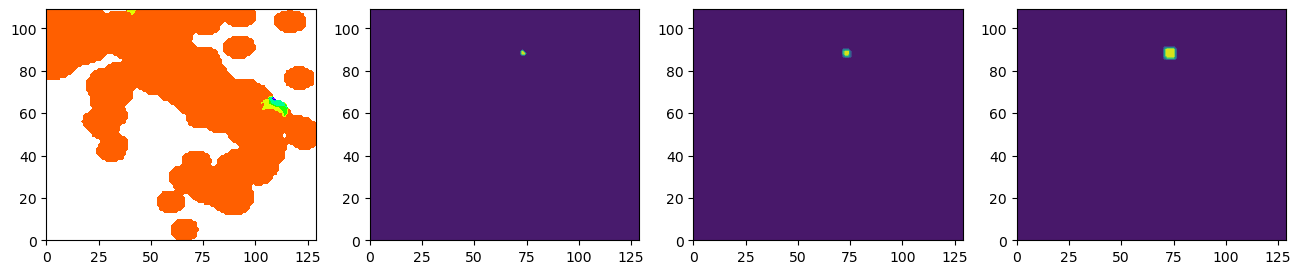

362
2023-01-23 10:37:52+00:00


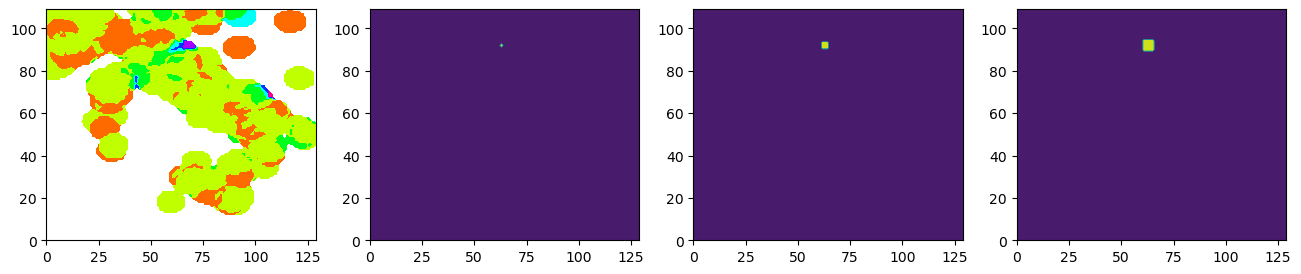

354
2023-04-21 22:19:48+00:00


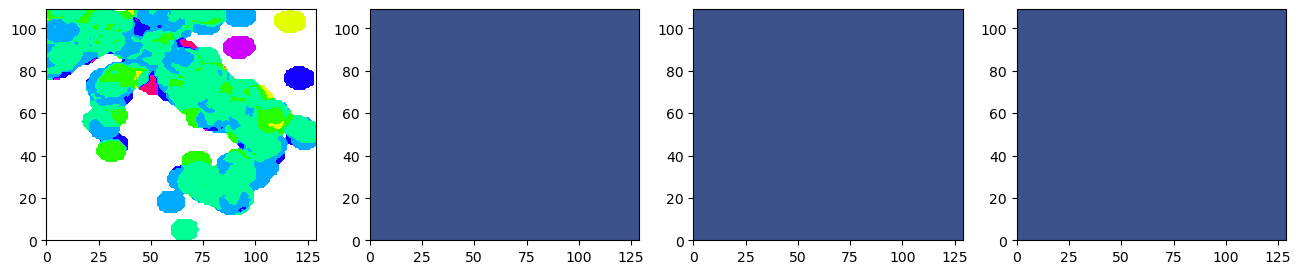

361
2023-05-01 02:41:26+00:00


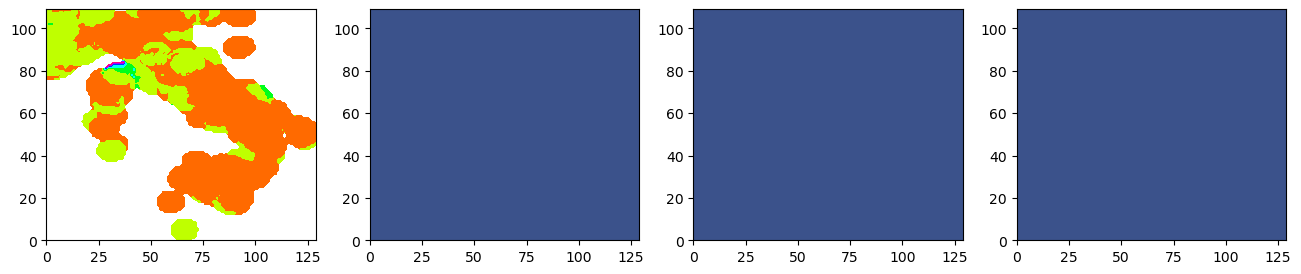

365
2023-09-18 03:10:14+00:00


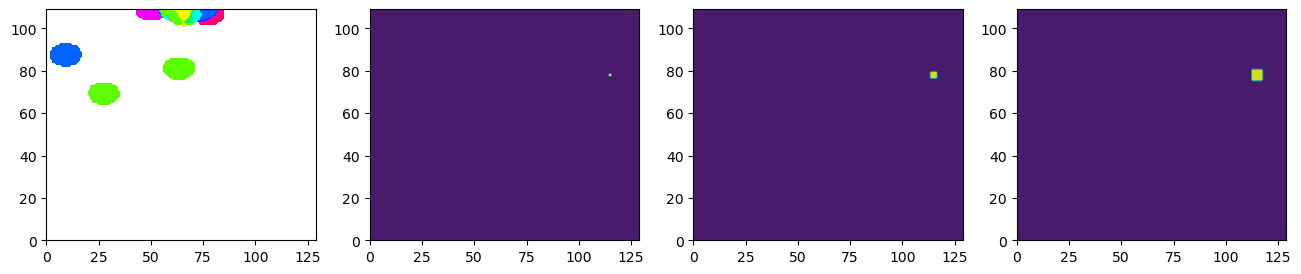

11


In [12]:
maximal_time_shift = np.timedelta64(7, 'D')
minimal_time_shift = np.timedelta64(1, 'D')
dlat = 0.1
dlon = 0.1
datasets = {}
for name, catalog in catalogs.items():
    dataset = []
    print(name)
    # discretization of the region
    region = regions[name]
    N_lat = int((region[1]-region[0])/dlat)
    N_lon = int((region[3]-region[2])/dlon)
    grid_latlat, grid_lonlon = np.meshgrid( region[0] + np.arange(0, N_lat)*dlat, region[2] + np.arange(0, N_lon)*dlon, indexing='ij')
    grid_latlat = grid_latlat.flatten()
    grid_lonlon = grid_lonlon.flatten()
    grid = np.hstack([grid_latlat[:,None], grid_lonlon[:,None]])
    stations_coords = np.hstack([station_info[name][1][:,None], station_info[name][2][:,None]])
    grid_stations_dists = haversine_distances(np.radians(grid), np.radians(stations_coords))
    grid_stations_dists = grid_stations_dists.reshape((N_lat, N_lon, -1))
    

    # earthquakes identification
    large_shocks = catalog[catalog.Magnitude >= regions_m[name][0]]
    large_shocks_days = large_shocks.Time
    large_shocks_coords =  large_shocks[['Latitude','Longitude']].values
    for day_time, coord in zip(large_shocks_days, large_shocks_coords):
        print(day_time)
        day = np.datetime64(datetime.datetime(day_time.year, day_time.month, day_time.day))
        aftershocks = catalog[ (catalog.Magnitude >= regions_m[name][1])* (catalog.Time.values.astype('datetime64[D]') >=  day + minimal_time_shift)*(catalog.Time.values.astype('datetime64[D]') <= pd.to_datetime(day) +maximal_time_shift ) ]
        aftershocks_coords = aftershocks[['Latitude','Longitude']].values
        #aftershocks_map = construct_aftershocks_map(region, aftershocks_coords, dlat, dlon)
        aftershocks_maps = [construct_aftershocks_map_steps(region, aftershocks_coords, dlat, dlon, steps) for steps in [0,1,2] ]
        # daily data
        data = []
        indices = []
        for cnt, (s_name, _,__) in  enumerate(zip(*station_info[name])):
            df = station_data[s_name]
            row = df[df.date==  day]
            row_p = df[df.date==  day - np.timedelta64(1, 'D')]
            if(len(row) > 0 and len(row_p) > 0):
                u_n = row.lat.values[0]-row_p.lat.values[0]
                u_e = row.lon.values[0]-row_p.lon.values[0]
                u_v = row.height.values[0] - row_p.height.values[0]
                data.append((u_n, u_e, u_v))
                indices.append(cnt)
        if(len(indices) > 0):
            data = np.array(data)
            indices = np.array(indices)
            
            u_map = construct_map(data, indices, grid_stations_dists)
            dataset.append((day_time, coord,u_map, aftershocks_maps))
            #print(data)
            fig, ax = plt.subplots(ncols=4, figsize=(16,3))
            ax[0].contourf(np.sqrt(u_map[:,:,0]**2+u_map[:,:,1]**2), cmap='hsv')
            for am_c, am in enumerate(aftershocks_maps):
                ax[am_c+1].contourf(am)
            #locs = np.argwhere(aftershocks_map>0)
            #ax[0].contour(aftershocks_map, cmap='Greys', levels=2)
            #ax.scatter(locs[:,1], locs[:,0], color='black', s=5)
            plt.show()
            print(len(indices))
    datasets[name] = dataset

In [13]:
# x_... and y_... are images
# x_train has shape (N_train, N_lat, N_lon, 3 ~ N, E, V)
study_name = "japan"
dataset = datasets[study_name]
x_train = []
x_test = []
y_train = []
y_test = []
limit_date = datetime.datetime(2015,1,1,0,0,0, tzinfo=datetime.timezone.utc)
for data in dataset:
    if(data[0]  > limit_date):
        y_test.append(data[3][-1]) # data[3] is a list of aftershocks map, we keep one of them
        x_test.append(data[2]) # extract the u_map
    else:
        y_train.append(data[3][-1]) # data[3] is a list of aftershocks map, we keep one of them
        x_train.append(data[2]) # extract the u_map
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train = np.array(x_train)
x_test = np.array(x_test)
np.savez(study_name + ".npz", x_train=x_train, x_test=x_test, y_train = y_train, y_test=y_test)